# Final Project Submission

Please fill out:
* Student name: 
* Student pace: self paced / part time / full time:
* Scheduled project review date/time: 
* Instructor name: 
* Blog post URL:
* Video of 5-min Non-Technical Presentation:

## TABLE OF CONTENTS 

*Click to jump to matching Markdown Header.*<br><br>
 
- **[Introduction](#INTRODUCTION)<br>**
- **[OBTAIN](#OBTAIN)**<br>
- **[SCRUB](#SCRUB)**<br>
- **[EXPLORE](#EXPLORE)**<br>
- **[MODEL](#MODEL)**<br>
- **[iNTERPRET](#iNTERPRET)**<br>
- **[Conclusions/Recommendations](#CONCLUSIONS-&-RECOMMENDATIONS)<br>**
___

In [534]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import hashlib
import json
import pickle
import gzip
import re
from ml_tools import model_eval, nlp_prep, eda

import nltk
from nltk.probability import FreqDist
from nltk.tokenize import TweetTokenizer, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.tag import StanfordPOSTagger

from wordcloud import WordCloud

import spacy

from sklearn import metrics
from sklearn.base import clone
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier

In [535]:
#nltk.download('averaged_perceptron_tagger')

# INTRODUCTION

> Explain the point of your project and what question you are trying to answer with your modeling.

## Business Problem

Summary of the business problem you are trying to solve, and the data questions that you plan to answer to solve them.

***
Questions to consider:
* What are the business's pain points related to this project?
* How did you pick the data analysis question(s) that you did?
* Why are these questions important from a business perspective?
***



# OBTAIN

## Data Understanding

I started with a [found dataset](https://data.world/martinchek/2012-2016-facebook-posts) of about 48,000 Facebook posts from the New York Times' account covering the time period from late 2012 to late 2016.

Given Facebook's policies around what can be pulled from pages unless you control it, it wasn't possible for me to gather any more recent data myself.

I wanted to try to match the Facebook posts up to actual articles from the NYT using their API. It was my hope that I could both compare the level of engagement on Facebook versus the Times' main site (comment counts) as well as get additional article metadata to use in modeling, such as word counts of the articles, news desk/section, and the keywords the Times has assigned to people, places, and topics addressed in each article.

See the separate notebook [data_gathering](data_gathering.ipynb) for the steps I took to query the Times' article API to get basic metadata for all articles during the desired time frame, and then attempted to match Facebook Posts to articles accurately. It proved somewhat challenging for a few reasons:
- There was no hard and fast rule to map the Facebook post metadata (name, message, and description) to the article metadata (such as snippet, abstract, and main headline).
- Descriptions and titles were often changed for the Facebook post (or perhaps the article info changed over time as well) so exact matches were often not possible.
- The article links seem to occasionally have changed since articles were posted to Facebook, as links were not reliable matches. Some Facebook posts were links to videos that were uploaded to Facebook directly and not links to the Times' main site, so these could also not be matched directly.
- Many Facebook links were shortened, so I had to go through and use `urllib` to follow them and record the final expanded link to attempt using these for matching.
- An article may have been shared on Facebook on a different date than when the article was first published, so this could not be used reliably to match either.
- Not all articles may have been included in the Article API results, such as recipes. This may be due to type of content, but also may be due to some recipes or articles having been published before the time period I searched for, but shared to Facebook later (for instance, the same Thanksgiving recipes may be shared year after year).
- The Times has some recurring features such as daily information to start your day, which tended to have the same name, message and description. These had to be matched on text information as well as date.
- There were sometimes legitimately multiple versions of NYT features listed in its API results due to there being a written article, an interactive feature, and a slideshow, for instance. Where a single Facebook post matched on multiple articles, I manually reviewed and judged the best match.

Ultimately, I was able to match 43k out of 48k, which I considered to be pretty good.

My target variable will be some version of an engagement score based on number of shares, likes, and comments on Facebook. I'm not yet sure how I want to build the target variable, and whether I want to focus on just one of these engagement metrics, or attempt to engineer a target variable that captures all three.

I'm going to do initial scrubbing and exploration and see if any natural patterns jump out at me.

In [536]:
df = pd.read_csv('data/the-new-york-times-5281959998.csv', encoding='utf_16_le', 
                 engine='python')
df.head()

id     page_id                           name  \
0    5281959998_416259568436280  5281959998    Did Barack Obama Save Ohio?   
1    5281959998_268320586619940  5281959998  The Weatherman Is Not a Moron   
2    5281959998_467433813289503  5281959998              The Organic Fable   
3  5281959998_10150252974589999  5281959998                Timeline Photos   
4    5281959998_463550620334374  5281959998                Pot for Parents   

                                             message  \
0  'There are several pivotal states — Ohio, Flor...   
1  In 1940, the chance of an American being kille...   
2  'Organic has long since become an ideology, th...   
3  Our special Arts & Leisure section 'The New Se...   
4  'When I’m rolling around the floor with my gig...   

                                         description      caption post_type  \
0  Why the battle to take credit for Ohio’s ever-...  nytimes.com      link   
1  In the hocus-pocus realm of predicting the fut...  nytimes.com      link   
2  A study exposes the hype behind a pseudoscient...  nytimes.com      link   
3                                                NaN          NaN     photo   
4  I am a more loving, attentive and patient fath...  nytimes.com      link   

    status_type  likes_count  comments_count  shares_count  love_count  \
0  shared_story          413              44            68           0   
1  shared_story          338              14            78           0   
2  shared_story          812             290           421           0   
3  added_photos          513              17            99           0   
4  shared_story          502              83           170           0   

   wow_count  haha_count  sad_count  thankful_count  angry_count  \
0          0           0          0               0            0   
1          0           0          0               0            0   
2          0           0          0               0            0   
3          0           0          0               0            0   
4          0           0          0               0            0   

                                                link  \
0  http://www.nytimes.com/2012/09/09/magazine/ohi...   
1  http://www.nytimes.com/2012/09/09/magazine/the...   
2  http://www.nytimes.com/2012/09/07/opinion/roge...   
3  https://www.facebook.com/nytimes/photos/a.2835...   
4  http://www.nytimes.com/2012/09/08/opinion/how-...   

                                             picture            posted_at  
0  https://external.xx.fbcdn.net/safe_image.php?d...  2012-09-08 15:16:55  
1  https://external.xx.fbcdn.net/safe_image.php?d...  2012-09-08 16:01:13  
2  https://external.xx.fbcdn.net/safe_image.php?d...  2012-09-08 16:44:02  
3  https://scontent.xx.fbcdn.net/v/t1.0-0/s130x13...  2012-09-08 17:32:18  
4  https://external.xx.fbcdn.net/safe_image.php?d...  2012-09-08 19:14:51

In [537]:
# import NYT article metadata matched to Facebook posts in separate notebook
f = gzip.open('data/final_matches.pickle.gz','rb')
df_matches = pickle.load(f)
f.close()

In [538]:
df_matches.head()

id  \
0    5281959998_416259568436280   
1    5281959998_268320586619940   
2    5281959998_463550620334374   
3  5281959998_10150253031069999   
4    5281959998_437214569655310   

                                                 _id print_section print_page  \
0  nyt://article/b122515f-2281-5ca8-8749-7a64f317...            MM         28   
1  nyt://article/c45ee260-62ac-52cf-8937-29d1f731...            MM         34   
2  nyt://article/18ecc9e3-6e52-5c51-a7c2-9a788727...             A         21   
3  nyt://article/686b0747-bbe4-5436-86ad-ada41713...           NaN        NaN   
4  nyt://article/28e0313f-8660-56b8-9ed8-db9be898...             A          1   

                                             snippet  \
0  Why the battle to take credit for Ohio’s ever-...   
1  In the hocus-pocus realm of predicting the fut...   
2  I am a more loving, attentive and patient fath...   
3  Introduced to a boy born in Hawaii, President ...   
4  In 2011 the Department of Education paid $1.4 ...   

                                      lead_paragraph  \
0  The way John Kasich sees it, he is fulfilling ...   
1  From the inside, the National Centers for Envi...   
2                                      San Francisco   
3  ORLANDO, Fla. — Birthers, you’re not going to ...   
4  At a protest last year at New York University,...   

                                 main_headline  \
0                  Did Barack Obama Save Ohio?   
1                The Weatherman Is Not a Moron   
2                              Pot for Parents   
3           Obama Makes Birth Certificate Joke   
4  Debt Collectors Cashing In on Student Loans   

                                            keywords news_desk  section_name  \
0  [{'name': 'glocations', 'value': 'Ohio', 'rank...  Magazine      Magazine   
1  [{'name': 'persons', 'value': 'Richardson, Lew...  Magazine      Magazine   
2  [{'name': 'subject', 'value': 'Medical Marijua...      OpEd       Opinion   
3  [{'name': 'subject', 'value': 'Presidential El...                    U.S.   
4  [{'name': 'subject', 'value': 'Series', 'rank'...  Business  Business Day   

  type_of_material  word_count  
0             News        7113  
1             News        3915  
2            Op-Ed         855  
3             News         114  
4             News        2508

# SCRUB

## Article Metadata

In [539]:
df_matches.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43448 entries, 0 to 43447
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                43448 non-null  object
 1   _id               43448 non-null  object
 2   print_section     31714 non-null  object
 3   print_page        31714 non-null  object
 4   snippet           43448 non-null  object
 5   lead_paragraph    43448 non-null  object
 6   main_headline     43448 non-null  object
 7   keywords          43448 non-null  object
 8   news_desk         43448 non-null  object
 9   section_name      42711 non-null  object
 10  type_of_material  43443 non-null  object
 11  word_count        43448 non-null  int64 
dtypes: int64(1), object(11)
memory usage: 4.0+ MB


### Fill Nulls

In [540]:
# print section and print page have the same number of nulls, are the nulls
# happening on the same records?
df_matches.loc[df_matches['print_section'].isna(), 'print_page'].value_counts()

Series([], Name: print_page, dtype: int64)

In [541]:
df_matches.loc[df_matches['print_section'].isna(), 'type_of_material'].value_counts()

News                   6796
Interactive Feature    2358
Recipe                  737
Video                   605
Op-Ed                   568
briefing                172
Slideshow               164
Review                  156
Question                 58
Editorial                42
Special Report           14
Series                   12
List                     12
News Analysis             7
Text                      7
Letter                    7
Web Log                   3
Brief                     3
recipe                    2
Interview                 2
Obituary (Obit)           2
Schedule                  1
Quote                     1
Name: type_of_material, dtype: int64

No patterns emerged in terms of missing print info. I will just populate with a null placeholder.

In [542]:
df_matches.loc[df_matches['print_section'].isna(), 'print_section'] = 'None'
df_matches.loc[df_matches['print_page'].isna(), 'print_page'] = 'None'

In [543]:
df_matches['news_desk'].value_counts()[:40]

National             7719
Foreign              6844
Business             3482
OpEd                 2959
Sports               2655
Metro                2433
Culture              2370
                     2273
Science              1888
Styles               1520
Editorial            1351
Magazine             1155
Travel                763
Arts&Leisure          613
Dining                526
U.S.                  483
Upshot                465
Politics              425
Weekend               388
SundayBusiness        331
The Upshot            326
World                 321
TStyle                214
BookReview            213
NYTNow                182
RealEstate            167
Opinion               129
Society               107
Arts                   99
New York               98
EdLife                 83
Fashion & Style        79
Metropolitan           73
Business Day           57
Blogs                  57
Home                   57
Well                   44
NODESK                 38
Multimedia/P

Hmmm, there are definitely some news_desk values that are empty. I also see a `'NODESK'` placeholder further down.

In [544]:
df_matches.loc[df_matches['news_desk']=='', 'type_of_material'].value_counts()

News      1452
Recipe     737
Video       80
Name: type_of_material, dtype: int64

Going to replace those empty strings with `'None'` to be consistent.

In [545]:
df_matches.loc[(df_matches['news_desk']=='') | (df_matches['news_desk']=='NODESK'), 
               'news_desk'] = 'None'

In [546]:
df_matches['section_name'].value_counts()

U.S.                          8319
World                         6823
Opinion                       4620
Sports                        2666
New York                      2588
Arts                          2504
Business Day                  2411
Health                        1614
Fashion & Style               1384
Science                       1280
The Upshot                    1230
Magazine                      1154
Technology                    1061
Travel                         762
Movies                         657
Food                           581
Multimedia/Photos              453
Books                          428
T Magazine                     287
Style                          283
Theater                        253
Blogs                          204
Education                      189
Your Money                     188
Real Estate                    180
NYT Now                        144
Sunday Review                   79
Well                            74
Home & Garden       

In [547]:
df_matches.loc[df_matches['section_name'].isna(), 'news_desk'].value_counts()

None    737
Name: news_desk, dtype: int64

Interesting, so the articles that don't have a section_name also don't have a news_desk.

In [548]:
df_matches.loc[df_matches['section_name'].isna(), 'type_of_material'].value_counts()

Recipe    737
Name: type_of_material, dtype: int64

And they're all recipes. None of the recipes marked as such as `type of material` seem to be classified in either `section_name` or `news_desk`. I'll make a new category for these, since I know the Times does have a separate Cooking section that's a subsection of Food and is dedicated to recipes and articles about cooking.

In [549]:
df_matches.loc[df_matches['type_of_material'] == 'Recipe', 
               ['news_desk', 'section_name']] = 'Cooking'

In [550]:
df_matches.loc[df_matches['type_of_material'] == 'Recipe']

id  \
42451  5281959998_10150276934359999   
42481  5281959998_10150406016844999   
42511  5281959998_10150458674129999   
42532  5281959998_10150463643909999   
42535  5281959998_10150464102119999   
...                             ...   
43443  5281959998_10150954475304999   
43444  5281959998_10150953811444999   
43445   5281959998_1301608653216932   
43446  5281959998_10150953848459999   
43447  5281959998_10150958024099999   

                                                     _id print_section  \
42451  nyt://recipe/383cbf04-9dec-5ad8-a653-1fd686b42631          None   
42481  nyt://recipe/69280bcf-8ac2-5d80-8bb4-60b06abdc0b0          None   
42511  nyt://recipe/b32956e5-a287-5301-95b2-51a8070fd75d          None   
42532  nyt://recipe/8ee5bf90-d7d7-54dd-b950-3946edc5b5d4          None   
42535  nyt://recipe/66ac3312-2f89-5863-8050-9d637edc2306          None   
...                                                  ...           ...   
43443  nyt://recipe/43fa7001-6bf5-534c-a57e-4c590659346b          None   
43444  nyt://recipe/8438a62c-1e62-557d-a0d9-133f9c812614          None   
43445  nyt://recipe/1c7d9d6b-bfcf-5f1a-a9b0-5c3a13b04c9e          None   
43446  nyt://recipe/80dd0d57-acce-58ba-8eb1-264c6ac32f88          None   
43447  nyt://recipe/dad2f214-402f-57b7-9a00-59a3c5e7a3b7          None   

      print_page snippet                                     lead_paragraph  \
42451       None          The affinity that cauliflower has with black o...   
42481       None          The mint julep is, as Chris McMillian of the L...   
42511       None          This mashup of Julia Child recipes, combining ...   
42532       None          A combination of soft beans, harissa-imbued ve...   
42535       None          You probably already have a favorite pantry pa...   
...          ...     ...                                                ...   
43443       None          This hearty pumpkin bread is a sophisticated t...   
43444       None          This casserole may upset some mashed potato pu...   
43445       None          If you havenâ€™t yet figured out a go-to recip...   
43446       None          This is a classic Italian bean and pasta soup....   
43447       None          Here is a vegetarian dinner course of impressi...   

                                     main_headline keywords news_desk  \
42451  Sicilian Cauliflower and Black Olive Gratin       []   Cooking   
42481                                   Mint Julep       []   Cooking   
42511                         Bacon-Cheddar Quiche       []   Cooking   
42532          Eggs With Gigante Beans and Harissa       []   Cooking   
42535     Pasta With Fried Lemons and Chile Flakes       []   Cooking   
...                                            ...      ...       ...   
43443  Pumpkin Bread With Brown Butter and Bourbon       []   Cooking   
43444                      Mashed Potato Casserole       []   Cooking   
43445         Roasted Brussels Sprouts With Garlic       []   Cooking   
43446                              Pasta e Fagioli       []   Cooking   
43447        Whole-Roasted Stuffed Delicata Squash       []   Cooking   

      section_name type_of_material  word_count  
42451      Cooking           Recipe           0  
42481      Cooking           Recipe           0  
42511      Cooking           Recipe           0  
42532      Cooking           Recipe           0  
42535      Cooking           Recipe           0  
...            ...              ...         ...  
43443      Cooking           Recipe           0  
43444      Cooking           Recipe           0  
43445      Cooking           Recipe           0  
43446      Cooking           Recipe           0  
43447      Cooking           Recipe           0  

[737 rows x 12 columns]

In [551]:
df_matches.loc[df_matches['type_of_material'].isna()]

id  \
42464  5281959998_10150366102944999   
42510  5281959998_10150458146549999   
42650  5281959998_10150510449164999   
43039  5281959998_10150715658464999   
43286  5281959998_10150836010884999   

                                                     _id print_section  \
42464  nyt://article/bf3e968c-1bb4-5630-a5e8-5e3cccf4...          None   
42510  nyt://article/13c1a736-7484-5500-8eac-b7fede9a...          None   
42650  nyt://article/46a291e1-a27c-54c8-ae80-eb51093e...          None   
43039  nyt://interactive/59bc74fa-2f6b-4836-b5de-6a6a...          None   
43286  nyt://article/2694ca1d-a271-59a2-b296-9ca63594...          None   

      print_page                                            snippet  \
42464       None  From the Abstract City archive: An artist’s at...   
42510       None  The runway gantlet looks very familiar. The ou...   
42650       None  He knows a thing or two about nice. And, as a ...   
43039       None  As part of a series of editorials about transg...   
43286       None  The intrepid “On the Street” fashion photograp...   

                                          lead_paragraph  \
42464                                                      
42510                   Remember when hats were hattier?   
42650         “Ho, ho, ho. You got a problem with that?”   
43039  As part of a series of editorials about transg...   
43286  As anyone knows who has seen the documentary “...   

                                 main_headline  \
42464                            Let It Dough!   
42510                      When Hats Had Heart   
42650                          North Pole Noir   
43039          Transgender Lives: Your Stories   
43286  Bill Cunningham: A Rare Bird’s Feathers   

                                                keywords news_desk  \
42464                                                 []      None   
42510  [{'name': 'subject', 'value': 'Fashion and App...      None   
42650  [{'name': 'subject', 'value': 'Archives and Re...      None   
43039                                                 []   Opinion   
43286  [{'name': 'subject', 'value': 'Hats and Caps',...      None   

            section_name type_of_material  word_count  
42464            Opinion              NaN           1  
42510  Multimedia/Photos              NaN         306  
42650  Multimedia/Photos              NaN         318  
43039            Opinion              NaN           0  
43286  Multimedia/Photos              NaN         242

In [552]:
df_matches['type_of_material'].value_counts()

News                   33428
Op-Ed                   3273
Interactive Feature     2359
Review                   839
Recipe                   737
Editorial                622
Video                    605
Obituary (Obit)          510
News Analysis            289
Question                 193
briefing                 172
Slideshow                164
Biography                 66
Letter                    31
List                      29
An Appraisal              26
Interview                 22
Special Report            19
Series                    16
Text                      10
Brief                      9
Web Log                    6
Summary                    4
recipe                     3
An Analysis                2
Caption                    2
Economic Analysis          2
Quote                      1
Military Analysis          1
Chronology                 1
Correction                 1
Schedule                   1
Name: type_of_material, dtype: int64

In [553]:
df_matches.loc[df_matches['type_of_material'].isna(), 'type_of_material'] = 'None'

Some of these have a title case and a lower case version. Let's standardize to title case.

In [554]:
df_matches['type_of_material'] = df_matches['type_of_material'].map(lambda x: x.title())

In [555]:
df_matches['type_of_material'].value_counts()

News                   33428
Op-Ed                   3273
Interactive Feature     2359
Review                   839
Recipe                   740
Editorial                622
Video                    605
Obituary (Obit)          510
News Analysis            289
Question                 193
Briefing                 172
Slideshow                164
Biography                 66
Letter                    31
List                      29
An Appraisal              26
Interview                 22
Special Report            19
Series                    16
Text                      10
Brief                      9
Web Log                    6
None                       5
Summary                    4
An Analysis                2
Caption                    2
Economic Analysis          2
Military Analysis          1
Quote                      1
Correction                 1
Chronology                 1
Schedule                   1
Name: type_of_material, dtype: int64

In [556]:
df_matches.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43448 entries, 0 to 43447
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                43448 non-null  object
 1   _id               43448 non-null  object
 2   print_section     43448 non-null  object
 3   print_page        43448 non-null  object
 4   snippet           43448 non-null  object
 5   lead_paragraph    43448 non-null  object
 6   main_headline     43448 non-null  object
 7   keywords          43448 non-null  object
 8   news_desk         43448 non-null  object
 9   section_name      43448 non-null  object
 10  type_of_material  43448 non-null  object
 11  word_count        43448 non-null  int64 
dtypes: int64(1), object(11)
memory usage: 4.0+ MB


### Expand keyword list of dicts

In [557]:
df_matches.at[0, 'keywords']

[{'name': 'glocations', 'value': 'Ohio', 'rank': 1, 'major': 'N'},
 {'name': 'subject', 'value': 'Automobiles', 'rank': 2, 'major': 'N'},
 {'name': 'persons', 'value': 'Kasich, John R', 'rank': 3, 'major': 'N'},
 {'name': 'persons', 'value': 'Portman, Rob', 'rank': 4, 'major': 'N'},
 {'name': 'persons', 'value': 'Geithner, Timothy F', 'rank': 5, 'major': 'N'},
 {'name': 'persons', 'value': 'Obama, Barack', 'rank': 6, 'major': 'N'},
 {'name': 'subject',
  'value': 'Economic Conditions and Trends',
  'rank': 7,
  'major': 'N'},
 {'name': 'glocations', 'value': 'Columbus (Ohio)', 'rank': 8, 'major': 'N'},
 {'name': 'organizations', 'value': 'JobsOhio', 'rank': 9, 'major': 'N'},
 {'name': 'persons', 'value': 'Strickland, Ted', 'rank': 10, 'major': 'N'},
 {'name': 'glocations', 'value': 'Lorain (Ohio)', 'rank': 11, 'major': 'N'},
 {'name': 'subject',
  'value': 'American Recovery and Reinvestment Act (2009)',
  'rank': 12,
  'major': 'N'},
 {'name': 'subject',
  'value': 'Presidential Elect

Looks like the same schema for each dictionary in the list, and that they're ranked by importance. I'm not sure what `major` stands for, but looking through a bunch, I don't see any populated with any value other than `N`.

I may not want every single keyword entry, maybe just the top 10 or something. I probably also want to keep them separated by `name`, so I can separate the subject from geolocations, people, organizations, etc.

In [558]:
# create list to hold all reorganized keyword values, entry per df row
kws_list = []

for i in df_matches.index:
    
    # get raw keywords list of dicts
    kws = df_matches.at[i, 'keywords']
    
    # new dict to hold reorganized keywords, with df row index as first value
    entry_dict = {'index': i}
    
    # loop through the entries in the keywords dict
    # reorgnanize with name as key, and values as a list per key
    for entry in kws:
        if entry['name'] in entry_dict.keys():
            entry_dict[entry['name']].append(entry['value'].lower())
        else:
            entry_dict[entry['name']] = [entry['value'].lower()]
            
    kws_list.append(entry_dict)
    
len(kws_list)

43448

In [559]:
df_kws = pd.DataFrame(kws_list)
df_kws.head()

index                                         glocations  \
0      0  [ohio, columbus (ohio), lorain (ohio), cincinn...   
1      1                                                NaN   
2      2                                                NaN   
3      3                                          [florida]   
4      4                                                NaN   

                                             subject  \
0  [automobiles, economic conditions and trends, ...   
1  [weather, books and literature, hurricanes and...   
2  [medical marijuana, marijuana, anxiety and str...   
3                    [presidential election of 2012]   
4  [series, credit and debt, student loans, unite...   

                                             persons  \
0  [kasich, john r, portman, rob, geithner, timot...   
1     [richardson, lewis fry, lorenz, edward norton]   
2                                                NaN   
3                                    [obama, barack]   
4                                                NaN   

                                       organizations creative_works  
0                                         [jobsohio]            NaN  
1  [national center for atmospheric research, int...            NaN  
2                                                NaN            NaN  
3                                                NaN            NaN  
4                                                NaN            NaN

In [560]:
df_kws.set_index('index', inplace=True)

In [561]:
# join the original matches df to expanded kws columns
df_matches = df_matches.join(df_kws)
df_matches.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43448 entries, 0 to 43447
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                43448 non-null  object
 1   _id               43448 non-null  object
 2   print_section     43448 non-null  object
 3   print_page        43448 non-null  object
 4   snippet           43448 non-null  object
 5   lead_paragraph    43448 non-null  object
 6   main_headline     43448 non-null  object
 7   keywords          43448 non-null  object
 8   news_desk         43448 non-null  object
 9   section_name      43448 non-null  object
 10  type_of_material  43448 non-null  object
 11  word_count        43448 non-null  int64 
 12  glocations        20482 non-null  object
 13  subject           41159 non-null  object
 14  persons           30719 non-null  object
 15  organizations     21860 non-null  object
 16  creative_works    2842 non-null   object
dtypes: int64(1),

In [562]:
len(df_matches.loc[df_matches['keywords'].str.len() == 0])

1721

In [563]:
df_matches.loc[df_matches['keywords'].str.len() == 0, 'type_of_material'].value_counts()

Recipe                 737
News                   604
Interactive Feature    155
Briefing               135
Slideshow               73
Op-Ed                    5
Video                    5
Editorial                2
None                     2
Letter                   2
Text                     1
Name: type_of_material, dtype: int64

OK, so almost half of the 1600 entries without keywords populated are Cooking, which is the placeholder I added for recipes.

In [564]:
# does it looks like everything matched up correctly all the way to the end?
df_matches.tail()

id  \
43443  5281959998_10150954475304999   
43444  5281959998_10150953811444999   
43445   5281959998_1301608653216932   
43446  5281959998_10150953848459999   
43447  5281959998_10150958024099999   

                                                     _id print_section  \
43443  nyt://recipe/43fa7001-6bf5-534c-a57e-4c590659346b          None   
43444  nyt://recipe/8438a62c-1e62-557d-a0d9-133f9c812614          None   
43445  nyt://recipe/1c7d9d6b-bfcf-5f1a-a9b0-5c3a13b04c9e          None   
43446  nyt://recipe/80dd0d57-acce-58ba-8eb1-264c6ac32f88          None   
43447  nyt://recipe/dad2f214-402f-57b7-9a00-59a3c5e7a3b7          None   

      print_page snippet                                     lead_paragraph  \
43443       None          This hearty pumpkin bread is a sophisticated t...   
43444       None          This casserole may upset some mashed potato pu...   
43445       None          If you havenâ€™t yet figured out a go-to recip...   
43446       None          This is a classic Italian bean and pasta soup....   
43447       None          Here is a vegetarian dinner course of impressi...   

                                     main_headline keywords news_desk  \
43443  Pumpkin Bread With Brown Butter and Bourbon       []   Cooking   
43444                      Mashed Potato Casserole       []   Cooking   
43445         Roasted Brussels Sprouts With Garlic       []   Cooking   
43446                              Pasta e Fagioli       []   Cooking   
43447        Whole-Roasted Stuffed Delicata Squash       []   Cooking   

      section_name type_of_material  word_count glocations subject persons  \
43443      Cooking           Recipe           0        NaN     NaN     NaN   
43444      Cooking           Recipe           0        NaN     NaN     NaN   
43445      Cooking           Recipe           0        NaN     NaN     NaN   
43446      Cooking           Recipe           0        NaN     NaN     NaN   
43447      Cooking           Recipe           0        NaN     NaN     NaN   

      organizations creative_works  
43443           NaN            NaN  
43444           NaN            NaN  
43445           NaN            NaN  
43446           NaN            NaN  
43447           NaN            NaN

## Join articles to FB posts

In [565]:
# join df_matches to main df
df = df.merge(df_matches.drop(columns=['keywords', '_id']), how='left', on='id')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48088 entries, 0 to 48087
Data columns (total 34 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                48088 non-null  object 
 1   page_id           48088 non-null  int64  
 2   name              46795 non-null  object 
 3   message           46351 non-null  object 
 4   description       43619 non-null  object 
 5   caption           43110 non-null  object 
 6   post_type         48088 non-null  object 
 7   status_type       48077 non-null  object 
 8   likes_count       48088 non-null  int64  
 9   comments_count    48088 non-null  int64  
 10  shares_count      48088 non-null  int64  
 11  love_count        48088 non-null  int64  
 12  wow_count         48088 non-null  int64  
 13  haha_count        48088 non-null  int64  
 14  sad_count         48088 non-null  int64  
 15  thankful_count    48088 non-null  int64  
 16  angry_count       48088 non-null  int64 

In [566]:
# Fill in Facebook columns with placeholders to indicate which could not be
# matched to articles
# since I filled all the nulls before I can choose from a few columns to
# identify these
df.loc[df['news_desk'].isna(), ['print_section', 'print_page', 'news_desk',
            'section_name', 'type_of_material']] = 'Not matched'

df.loc[df['word_count'].isna(), 'word_count'] = 0

# populate new column for is_matched
df.loc[df['news_desk']=='Not matched', 'is_matched'] = 0
df.loc[df['is_matched']!=0, 'is_matched'] = 1

In [567]:
df['is_matched'].value_counts()

1.0    43448
0.0     4640
Name: is_matched, dtype: int64

In [568]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48088 entries, 0 to 48087
Data columns (total 35 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                48088 non-null  object 
 1   page_id           48088 non-null  int64  
 2   name              46795 non-null  object 
 3   message           46351 non-null  object 
 4   description       43619 non-null  object 
 5   caption           43110 non-null  object 
 6   post_type         48088 non-null  object 
 7   status_type       48077 non-null  object 
 8   likes_count       48088 non-null  int64  
 9   comments_count    48088 non-null  int64  
 10  shares_count      48088 non-null  int64  
 11  love_count        48088 non-null  int64  
 12  wow_count         48088 non-null  int64  
 13  haha_count        48088 non-null  int64  
 14  sad_count         48088 non-null  int64  
 15  thankful_count    48088 non-null  int64  
 16  angry_count       48088 non-null  int64 

## Fill Nulls in Facebok post fields

In [569]:
# are there any posts where there is neither Name, Message, or Description?
df.loc[(df['name'].isna()) & 
       (df['message'].isna()) & 
       (df['description'].isna())]

Empty DataFrame
Columns: [id, page_id, name, message, description, caption, post_type, status_type, likes_count, comments_count, shares_count, love_count, wow_count, haha_count, sad_count, thankful_count, angry_count, link, picture, posted_at, print_section, print_page, snippet, lead_paragraph, main_headline, news_desk, section_name, type_of_material, word_count, glocations, subject, persons, organizations, creative_works, is_matched]
Index: []

[0 rows x 35 columns]

Good; before filling nulls, I'm going to create a concatenated field with all three text fields. I think I will want to assess all three sets of text together as a bag of words.

In [570]:
# used suggestion from here: https://stackoverflow.com/questions/19377969/
# combine-two-columns-of-text-in-pandas-dataframe
df['all_text'] = df['name'].str.cat(df[['message', 'description']], sep='. '
                                    , na_rep='')

In [571]:
# review records that didn't have any nulls in text columns
df.loc[(df['name'].isna()==False) & 
       (df['message'].isna()==False) & 
       (df['description'].isna()==False)]

id     page_id  \
0        5281959998_416259568436280  5281959998   
1        5281959998_268320586619940  5281959998   
2        5281959998_467433813289503  5281959998   
4        5281959998_463550620334374  5281959998   
6        5281959998_437214569655310  5281959998   
...                             ...         ...   
48083  5281959998_10150958194759999  5281959998   
48084  5281959998_10150958250414999  5281959998   
48085  5281959998_10150958439909999  5281959998   
48086  5281959998_10150958425294999  5281959998   
48087  5281959998_10150958224029999  5281959998   

                                                    name  \
0                            Did Barack Obama Save Ohio?   
1                          The Weatherman Is Not a Moron   
2                                      The Organic Fable   
4                                        Pot for Parents   
6      Debt Collectors Cashing In on Student Loan Rou...   
...                                                  ...   
48083  ‘Westworld’ Season 1, Episode 6: The Tipping P...   
48084                       What Ivanka Trump Can’t Sell   
48085  This Time, There Really Is a Hispanic Voter Surge   
48086  NYT Watching Recommendation of the Day: 'Bob's...   
48087  Harry Belafonte: What Do We Have to Lose? Ever...   

                                                 message  \
0      'There are several pivotal states — Ohio, Flor...   
1      In 1940, the chance of an American being kille...   
2      'Organic has long since become an ideology, th...   
4      'When I’m rolling around the floor with my gig...   
6      Quotation of the Day: 'You are going to pay it...   
...                                                  ...   
48083  This week's 'Westworld' gave us the show's mos...   
48084  “She wants to preach an ideology of female emp...   
48085  The Hispanic voter surge is real, and it’s big...   
48086  The most passionately pro-weirdo show on telev...   
48087  'What old men know is that things blown up — c...   

                                             description      caption  \
0      Why the battle to take credit for Ohio’s ever-...  nytimes.com   
1      In the hocus-pocus realm of predicting the fut...  nytimes.com   
2      A study exposes the hype behind a pseudoscient...  nytimes.com   
4      I am a more loving, attentive and patient fath...  nytimes.com   
6      The Department of Education last year paid $1....  nytimes.com   
...                                                  ...          ...   
48083  The world as Maeve understood it is gone, as t...  nytimes.com   
48084  She has remained loyal to her father. Will tha...  nytimes.com   
48085  Early voting data unequivocally indicates that...  nytimes.com   
48086  The comedy doesn’t just introduce weirdness bu...  nytimes.com   
48087  Donald Trump and his “movement” put the painfu...  nytimes.com   

      post_type   status_type  likes_count  comments_count  ...  section_name  \
0          link  shared_story          413              44  ...      Magazine   
1          link  shared_story          338              14  ...      Magazine   
2          link  shared_story          812             290  ...       Opinion   
4          link  shared_story          502              83  ...       Opinion   
6          link  shared_story          260              74  ...  Business Day   
...         ...           ...          ...             ...  ...           ...   
48083      link  shared_story          549              37  ...          Arts   
48084      link  shared_story         3970             621  ...       Opinion   
48085      link  shared_story        34539             776  ...    The Upshot   
48086      link  shared_story         4113             428  ...   Not matched   
48087      link  shared_story         7771             183  ...       Opinion   

       type_of_material  word_count  \
0                  News      7113.0   
1                  News      3915.0   
2          

In [572]:
# review records that have some nulls
df.loc[(df['name'].isna()) | 
       (df['message'].isna()) | 
       (df['description'].isna())]

id     page_id  \
3      5281959998_10150252974589999  5281959998   
5      5281959998_10150253031069999  5281959998   
13     5281959998_10150253189039999  5281959998   
14     5281959998_10150253207659999  5281959998   
22     5281959998_10150253392344999  5281959998   
...                             ...         ...   
48036  5281959998_10150957229929999  5281959998   
48057  5281959998_10150957195084999  5281959998   
48059  5281959998_10150957696529999  5281959998   
48074  5281959998_10150958141049999  5281959998   
48080  5281959998_10150958344969999  5281959998   

                                       name  \
3                           Timeline Photos   
5                           Timeline Photos   
13                          Timeline Photos   
14                          Timeline Photos   
22                          Timeline Photos   
...                                     ...   
48036                       Timeline Photos   
48057  Ride Along With 'Souls to the Polls'   
48059     Burning Effigies on Bonfire Night   
48074  Naturalization: Becoming an American   
48080             2016 Election Puppet Show   

                                                 message description caption  \
3      Our special Arts & Leisure section 'The New Se...         NaN     NaN   
5      During a surprise visit to Gators Dockside bar...         NaN     NaN   
13     President Obama got a huge lift—literally — fr...         NaN     NaN   
14     Serena Williams defeated Victoria Azarenka to ...         NaN     NaN   
22     What's on your menu for lunch or dinner today?...         NaN     NaN   
...                                                  ...         ...     ...   
48036  Election week is here. Enjoy unlimited access ...         NaN     NaN   
48057  360° video: In North Carolina, where the presi...         NaN     NaN   
48059  Effigies of Donald J. Trump and Theresa May we...         NaN     NaN   
48074  Carmen Joan Edwards spent 15 years working tow...         NaN     NaN   
48080  We're putting on a live puppet show re-enactin...         NaN     NaN   

      post_type   status_type  likes_count  comments_count  ...  section_name  \
3         photo  added_photos          513              17  ...   Not matched   
5         photo  added_photos         9012             594  ...          U.S.   
13        photo  added_photos        16918            1415  ...          U.S.   
14        photo  added_photos         7629             353  ...   Not matched   
22        photo  added_photos          389              27  ...        Health   
...         ...           ...          ...             ...  ...           ...   
48036     photo  added_photos         1196             532  ...          U.S.   
48057     video   added_video          995              83  ...   Not matched   
48059     video   added_video         2157             249  ...         World   
48074     video   added_video         3764             147  ...          U.S.   
48080     video   added_video         1211             802  ...   Not matched   

       type_of_material  word_count                        glocations  \
3           Not matched         0.0                               NaN   
5                  News       114.0                         [florida]   
13                 News       336.0                         [florida]   
14          Not matched         0.0                               NaN   
22                 News       498.0                               NaN   
...                 ...         ...                               ...   
48036              News       350.0                               NaN   
48057       Not matched         0.0                               NaN   
48059              News      1142.0  [lewes (england), great britain]   
48074             Video         0.0                               NaN   
48080       Not matched         0.0                               NaN   

                                            

In [573]:
# review records that have some nulls
df.loc[(df['name'].isna()) | 
       (df['message'].isna()) | 
       (df['description'].isna()), 'post_type'].value_counts()

photo     2232
link      1921
video     1369
status     666
event        9
note         1
Name: post_type, dtype: int64

A lot of these are not links to articles, they are instead photos, videos, and status updates. I think `name` is only populated for links, so that makes sense.

### Caption

In [574]:
df.loc[df['caption'].isna()]

id     page_id  \
3      5281959998_10150252974589999  5281959998   
5      5281959998_10150253031069999  5281959998   
13     5281959998_10150253189039999  5281959998   
14     5281959998_10150253207659999  5281959998   
22     5281959998_10150253392344999  5281959998   
...                             ...         ...   
48061  5281959998_10150957971334999  5281959998   
48066  5281959998_10150958061204999  5281959998   
48068  5281959998_10150958085764999  5281959998   
48074  5281959998_10150958141049999  5281959998   
48080  5281959998_10150958344969999  5281959998   

                                       name  \
3                           Timeline Photos   
5                           Timeline Photos   
13                          Timeline Photos   
14                          Timeline Photos   
22                          Timeline Photos   
...                                     ...   
48061          The New York Times - Theater   
48066                      Nicholas Kristof   
48068    The New York Times - Well - Health   
48074  Naturalization: Becoming an American   
48080             2016 Election Puppet Show   

                                                 message  \
3      Our special Arts & Leisure section 'The New Se...   
5      During a surprise visit to Gators Dockside bar...   
13     President Obama got a huge lift—literally — fr...   
14     Serena Williams defeated Victoria Azarenka to ...   
22     What's on your menu for lunch or dinner today?...   
...                                                  ...   
48061  We're with Mike Daisey, who is performing a po...   
48066  Nicholas Kristof, a columnist for The New York...   
48068  Lauren Hard and Paul Moon of The New York Time...   
48074  Carmen Joan Edwards spent 15 years working tow...   
48080  We're putting on a live puppet show re-enactin...   

                                             description caption post_type  \
3                                                    NaN     NaN     photo   
5                                                    NaN     NaN     photo   
13                                                   NaN     NaN     photo   
14                                                   NaN     NaN     photo   
22                                                   NaN     NaN     photo   
...                                                  ...     ...       ...   
48061  Learn about the making of Donald J. Trump, as ...     NaN     video   
48066  Our last Facebook Live before the election! Ch...     NaN     video   
48068  We're at Pure Yoga with Sarah Attia, founder o...     NaN     video   
48074                                                NaN     NaN     video   
48080                                                NaN     NaN     video   

        status_type  likes_count  comments_count  ...  section_name  \
3      added_photos          513              17  ...   Not matched   
5      added_photos         9012             594  ...          U.S.   
13     added_photos        16918            1415  ...          U.S.   
14     added_photos         7629             353  ...   Not matched   
22     added_photos          389              27  ...        Health   
...             ...          ...             ...  ...           ...   
48061  shared_story          229              59  ...   Not matched   
48066  shared_story          144              40  ...   Not matched   
48068  shared_story           70               6  ...   Not matched   
48074   added_video         3764             147  ...          U.S.   
48080   added_video         1211             802  ...   Not matched   

       type_of_material  word_count  glocations  \
3           Not matched         0.0         NaN   
5                  News       114.0   [florida]   
13                 News       336.0   [florida]   
14          Not matched         0.0         NaN   
22                 News       498.0         NaN   
...                 ...         ...   

In [575]:
df.loc[df['caption'].isna(), 'status_type'].value_counts()

added_photos            2250
added_video             1576
mobile_status_update     654
shared_story             481
created_note              11
Name: status_type, dtype: int64

In [576]:
df.loc[df['caption'].isna(), 'post_type'].value_counts()

photo     2342
video     1846
status     666
link       123
note         1
Name: post_type, dtype: int64

Fill nulls in `caption` with `None`.

In [577]:
df.loc[df['caption'].isna(), 'caption'] = 'None'

### Status_Type

In [578]:
df.loc[df['status_type'].isna()]

id     page_id  \
4344   5281959998_10150545832854999  5281959998   
4908   5281959998_10150361446784999  5281959998   
6806   5281959998_10150545833184999  5281959998   
7604   5281959998_10150545833684999  5281959998   
11614  5281959998_10150545833989999  5281959998   
11911  5281959998_10150545834179999  5281959998   
19716  5281959998_10150543266959999  5281959998   
27192  5281959998_10150646408164999  5281959998   
28252  5281959998_10150662339134999  5281959998   
31206  5281959998_10150693452969999  5281959998   
38600  5281959998_10150799387114999  5281959998   

                                                    name message  \
4344   The International Herald Tribune is renamed th...     NaN   
4908                                  The New York Times     NaN   
6806                        Launched NYT Now for iPhone.     NaN   
7604   Dean Baquet named executive editor of The New ...     NaN   
11614  The New York Times launches NYT Cooking availa...     NaN   
11911  The New York Times debuts “First Draft,” new p...     NaN   
19716                                     New York Today     NaN   
27192                          The New York Times Styles     NaN   
28252                           The New York Times Books     NaN   
31206                                         Sheri Fink     NaN   
38600                                   Vanessa Friedman     NaN   

                                             description  \
4344                                                 NaN   
4908   See photos from Macy's Thanksgiving Day Parade...   
6806                                                 NaN   
7604                                                 NaN   
11614                                                NaN   
11911                                                NaN   
19716  The Times’s take on life in the New York regio...   
27192  Coverage of the fashion industry, lifestyle tr...   
28252  Book reviews, news, author profiles, interview...   
31206  Sheri Fink. Author of Five Days at Memorial an...   
38600  New York Times & INYT Fashion director/chief c...   

                                                 caption post_type  \
4344   The International Herald Tribune is renamed th...      link   
4908                                                None     photo   
6806                        Launched NYT Now for iPhone.      link   
7604   Dean Baquet named executive editor of The New ...      link   
11614  The New York Times launches NYT Cooking availa...      link   
11911  The New York Times debuts “First Draft,” new p...      link   
19716                                               None      link   
27192                                               None      link   
28252                                               None      link   
31206                                               None      link   
38600                                               None      link   

      status_type  likes_count  comments_count  ...  section_name  \
4344          NaN            1               0  ...   Not matched   
4908          NaN         6860             161  ...   Not matched   
6806          NaN            6              22  ...   Not matched   
7604          NaN            2               0  ...   Not matched   
11614         NaN            8               3  ...   Not matched   
11911         NaN            7               1  ...   Not matched   
19716         NaN            0               0  ...   Not matched   
27192         NaN            0               0  ...   Not matched   
28252         NaN            0               0  ...   Not matched   
31206         NaN            0               0  ...   Not matched   
38600         NaN            0               0  ...   Not matched   

       type_of_material  word_count  glocations  subject  persons  \
4344        Not matched         0.0         NaN      NaN      NaN   
4908        Not matched         0.0         NaN      NaN      NaN   
6806 

There are only a handful here. I could probably guess based on `post_type` but I'm going to populate with `None` as with the others for now.

In [579]:
# Set null status_types to None
df.loc[df['status_type'].isna(), 'status_type'] = 'None'

In [580]:
# check that they have been fixed
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48088 entries, 0 to 48087
Data columns (total 36 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                48088 non-null  object 
 1   page_id           48088 non-null  int64  
 2   name              46795 non-null  object 
 3   message           46351 non-null  object 
 4   description       43619 non-null  object 
 5   caption           48088 non-null  object 
 6   post_type         48088 non-null  object 
 7   status_type       48088 non-null  object 
 8   likes_count       48088 non-null  int64  
 9   comments_count    48088 non-null  int64  
 10  shares_count      48088 non-null  int64  
 11  love_count        48088 non-null  int64  
 12  wow_count         48088 non-null  int64  
 13  haha_count        48088 non-null  int64  
 14  sad_count         48088 non-null  int64  
 15  thankful_count    48088 non-null  int64  
 16  angry_count       48088 non-null  int64 

## Likes versus More Specific Reactions

The original data source says that the other reaction types such as `love`, `wow`, `sad`, `haha`, `thankful` and `angry` started towards the end of the data set. I'm not sure if these will translate into `likes` properly. How many are there, and can I just cut them off?

In [581]:
df.loc[df['haha_count']>0, ['name', 'likes_count', 'love_count', 'wow_count',
                           'haha_count', 'thankful_count', 'sad_count', 
                            'angry_count']]

name  likes_count  \
5                                        Timeline Photos         9012   
8470   Stephanie L. Kwolek, Inventor of Kevlar, Is De...         4068   
10496               Karen O Goes Solo with ‘Crush Songs’         8334   
11562  At Buckingham Palace, a Dancing Guard Throws D...         2833   
12751                                                NaN         6160   
...                                                  ...          ...   
48083  ‘Westworld’ Season 1, Episode 6: The Tipping P...          549   
48084                       What Ivanka Trump Can’t Sell         3970   
48085  This Time, There Really Is a Hispanic Voter Surge        34539   
48086  NYT Watching Recommendation of the Day: 'Bob's...         4113   
48087  Harry Belafonte: What Do We Have to Lose? Ever...         7771   

       love_count  wow_count  haha_count  thankful_count  sad_count  \
5               0          0           2               0          0   
8470            2          1           1               0          2   
10496           0          0           1               0          0   
11562           0          0           1               0          0   
12751           0          0           1               0          0   
...           ...        ...         ...             ...        ...   
48083          37          9           1               0          0   
48084          61         58         325               0         51   
48085        4473        141         214               0          4   
48086         746          2          58               0          0   
48087         902         41           8               0        406   

       angry_count  
5                0  
8470             0  
10496            0  
11562            0  
12751            0  
...            ...  
48083            0  
48084          444  
48085           14  
48086            2  
48087           17  

[10689 rows x 8 columns]

Hm, so they seem to start a ways back. Wondering if some people got early beta access or something, because there are only a few. Looking at [this article](https://www.wired.com/2016/02/facebook-reactions-totally-redesigned-like-button/) it seems this was released to the general public in February 2016.

According to [this article](https://blog.hootsuite.com/facebook-algorithm/) starting in 2017 reactions are given higher priority in Facebook's algorithm than likes. If I were doing this analysis on more recent data, I would probably try to account for that, since more reactions would lead to the posts showing up in more feeds. However, since our data only goes until November 2016, this wasn't applicable then, and most of the data I have was before reactions were released.

I could either combine likes and loves, or I could simply use likes and disregard the other reactions. I think I will combine the likes and loves, since the sentiment is quite similar, and discard the other reactions.

Another interesting thing I read in the Hootsuite article is that since 2018, posts that receive comments get higher priority in the algorithm, since those represent more meaningful interactions. Ultimately I think I will focus on shares and comments as opposed to likes:
- Shares are more likely to spread awareness of a particular article or post beyond the Times' sphere of direct followers.
- Comments are more likely to get posts boosted in the algorithm so they will be visible in people's feeds.

In [582]:
# create combined likes/loves column
df['likes_loves'] = df['likes_count'] + df['love_count']
df[['likes_loves', 'likes_count', 'love_count']]

likes_loves  likes_count  love_count
0              413          413           0
1              338          338           0
2              812          812           0
3              513          513           0
4              502          502           0
...            ...          ...         ...
48083          586          549          37
48084         4031         3970          61
48085        39012        34539        4473
48086         4859         4113         746
48087         8673         7771         902

[48088 rows x 3 columns]

## Check for duplicates

In [583]:
df.loc[df.duplicated(subset=['all_text', 'posted_at'], keep=False)]

id     page_id  \
246      5281959998_423902177671528  5281959998   
247      5281959998_423902177671528  5281959998   
248      5281959998_423902177671528  5281959998   
1910     5281959998_350894045015656  5281959998   
1911     5281959998_350894045015656  5281959998   
...                             ...         ...   
43295  5281959998_10150859876799999  5281959998   
44625  5281959998_10150884067009999  5281959998   
44626  5281959998_10150884067009999  5281959998   
44707  5281959998_10150885086169999  5281959998   
44708  5281959998_10150885086169999  5281959998   

                                                    name  \
246                              Global Citizen Festival   
247                              Global Citizen Festival   
248                              Global Citizen Festival   
1910                   Q. and A. on the Papal Transition   
1911                   Q. and A. on the Papal Transition   
...                                                  ...   
43295                The Week in Pictures: July 29, 2016   
44625  Black Women and Braids: Images Align Their His...   
44626  Black Women and Braids: Images Align Their His...   
44707  Black Women and Braids: Images Align Their His...   
44708  Black Women and Braids: Images Align Their His...   

                                                 message  \
246    Beginning at 4:00pm ET, watch the free live we...   
247    Beginning at 4:00pm ET, watch the free live we...   
248    Beginning at 4:00pm ET, watch the free live we...   
1910   White smoke poured from a chimney atop the Sis...   
1911   White smoke poured from a chimney atop the Sis...   
...                                                  ...   
43295                A look back at the week, in photos.   
44625  “No matter what the trend, braids are always g...   
44626  “No matter what the trend, braids are always g...   
44707  Black-and-white photos illuminate the ancestra...   
44708  Black-and-white photos illuminate the ancestra...   

                                             description  \
246    On Sept. 29 at 4:30 p.m. EST, watch a live vid...   
247    On Sept. 29 at 4:30 p.m. EST, watch a live vid...   
248    On Sept. 29 at 4:30 p.m. EST, watch a live vid...   
1910   Times reporters covering the papal transition ...   
1911   Times reporters covering the papal transition ...   
...                                                  ...   
43295  Photos from The New York Times and photographe...   
44625  Shani Crowe’s photographs capture the importan...   
44626  Shani Crowe’s photographs capture the importan...   
44707  Shani Crowe’s photographs capture the importan...   
44708  Shani Crowe’s photographs capture the importan...   

                         caption post_type   status_type  likes_count  \
246                  nytimes.com      link  shared_story          177   
247                  nytimes.com      link  shared_story          177   
248                  nytimes.com      link  shared_story          177   
1910   thelede.blogs.nytimes.com      link  shared_story          813   
1911   thelede.blogs.nytimes.com      link  shared_story          813   
...                          ...       ...           ...          ...   
43295                nytimes.com      link  shared_story           79   
44625     lens.blogs.nytimes.com      link  shared_story          207   
44626     lens.blogs.nytimes.com      link  shared_story          207   
44707     lens.blogs.nytimes.com      link  shared_story          205   
44708     lens.blogs.nytimes.com      link  shared_story          205   

       comments_count  ...  type_of_material  word_count  \
246                10  ...         Slideshow         0.0   
247                10  ...         Slideshow         0.0   
248                10  ...         Slideshow         0.0   
1910              102  ...              News      1915.0   
1911              102  ...              News      1915.0   
...               ..

Only one instance of a duplicate based on the date posted and text of the name, message, and description. I will drop it.

In [584]:
df.drop_duplicates(subset=['all_text', 'posted_at'], keep='first', 
                   inplace=True)

## Drop unnecessary columns

In [585]:
df.columns

Index(['id', 'page_id', 'name', 'message', 'description', 'caption',
       'post_type', 'status_type', 'likes_count', 'comments_count',
       'shares_count', 'love_count', 'wow_count', 'haha_count', 'sad_count',
       'thankful_count', 'angry_count', 'link', 'picture', 'posted_at',
       'print_section', 'print_page', 'snippet', 'lead_paragraph',
       'main_headline', 'news_desk', 'section_name', 'type_of_material',
       'word_count', 'glocations', 'subject', 'persons', 'organizations',
       'creative_works', 'is_matched', 'all_text', 'likes_loves'],
      dtype='object')

In [586]:
df.drop(columns=['page_id', 'name', 'message', 'description', 'wow_count', 
                 'haha_count', 'sad_count', 'thankful_count', 'angry_count', 
                 'picture', 'likes_count', 'love_count'] , inplace=True)

In [587]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47866 entries, 0 to 48087
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                47866 non-null  object 
 1   caption           47866 non-null  object 
 2   post_type         47866 non-null  object 
 3   status_type       47866 non-null  object 
 4   comments_count    47866 non-null  int64  
 5   shares_count      47866 non-null  int64  
 6   link              47200 non-null  object 
 7   posted_at         47866 non-null  object 
 8   print_section     47866 non-null  object 
 9   print_page        47866 non-null  object 
 10  snippet           43227 non-null  object 
 11  lead_paragraph    43227 non-null  object 
 12  main_headline     43227 non-null  object 
 13  news_desk         47866 non-null  object 
 14  section_name      47866 non-null  object 
 15  type_of_material  47866 non-null  object 
 16  word_count        47866 non-null  float6

# EXPLORE - All Facebook Posts

I did a little digging above to determine how to populate nulls, and I definitely think there are some columns that contain similar information, such as the categories of types of articles, sections, etc. I need to determine if any one of these seems to be more correlated with engagement than others.

I also need to decide how I'm going to engineer my target variable.

## Expore Links

In [588]:
# what are the posts without links?
df.loc[df['link'].isna(), 'status_type'].value_counts()

mobile_status_update    654
created_note             11
shared_story              1
Name: status_type, dtype: int64

OK so mostly mobile status updates.

In [589]:
df.loc[df['link'].isna()]

id caption post_type           status_type  \
158    5281959998_10150255185794999    None    status  mobile_status_update   
218    5281959998_10150256227144999    None    status  mobile_status_update   
431    5281959998_10150260425944999    None    status  mobile_status_update   
470    5281959998_10150261255114999    None    status  mobile_status_update   
596    5281959998_10150264210359999    None    status  mobile_status_update   
...                             ...     ...       ...                   ...   
42908  5281959998_10150854393309999    None    status  mobile_status_update   
45293  5281959998_10150897137829999    None    status  mobile_status_update   
46419  5281959998_10150915570479999    None    status  mobile_status_update   
47315  5281959998_10150933823424999    None    status  mobile_status_update   
47465  5281959998_10150937005589999    None    status  mobile_status_update   

       comments_count  shares_count link            posted_at print_section  \
158                50            18  NaN  2012-09-21 19:01:04   Not matched   
218                48            93  NaN  2012-09-27 04:02:02   Not matched   
431               200           191  NaN  2012-10-18 23:35:27          None   
470               514            97  NaN  2012-10-23 03:49:24   Not matched   
596               703          2050  NaN  2012-11-07 04:24:26   Not matched   
...               ...           ...  ...                  ...           ...   
42908              58            63  NaN  2016-07-23 00:42:12             A   
45293             443            43  NaN  2016-09-09 18:40:00   Not matched   
46419              35            47  NaN  2016-10-01 23:55:00   Not matched   
47315              76            12  NaN  2016-10-19 08:32:30   Not matched   
47465              18            18  NaN  2016-10-21 03:10:00   Not matched   

        print_page  ... type_of_material word_count          glocations  \
158    Not matched  ...      Not matched        0.0                 NaN   
218    Not matched  ...      Not matched        0.0                 NaN   
431           None  ...             News     3509.0                 NaN   
470    Not matched  ...      Not matched        0.0                 NaN   
596    Not matched  ...      Not matched        0.0                 NaN   
...            ...  ...              ...        ...                 ...   
42908            1  ...             News     1276.0  [munich (germany)]   
45293  Not matched  ...      Not matched        0.0                 NaN   
46419  Not matched  ...      Not matched        0.0                 NaN   
47315  Not matched  ...      Not matched        0.0                 NaN   
47465  Not matched  ...      Not matched        0.0                 NaN   

                                          subject  \
158                                           NaN   
218                                           NaN   
431                                    [baseball]   
470                                           NaN   
596                                           NaN   
...                                           ...   
42908  [murders, attempted murders and homicides]   
45293                                         NaN   
46419                                         NaN   
47315                                         NaN   
47465                                         NaN   

                                                 persons  \
158                                                  NaN   
218                                                  NaN   
431      [cashman, brian, girardi, joe, rodriguez, alex]   
470                                                  NaN   
596                                                  NaN   
...                                                  ...   
42908  [jacobs, andrew, eddy, melissa, sonboly, ali, ...   
45293                                                NaN   
46419                                                NaN 

## Explore Shares

### Review Distribution and Identify Outliers

In [590]:
df['shares_count'].describe()

count     47866.000000
mean        503.106819
std        3258.855448
min           0.000000
25%          57.000000
50%         147.000000
75%         404.000000
max      528856.000000
Name: shares_count, dtype: float64

In [591]:
# histogram of shares
fig, ax = plt.subplots(figsize=(8, 4))
sns.histplot(x=df['shares_count'], ax=ax, bins=50);

Median is 147 and mean is 507, so definitely not normally distributed. Seems there are some high outliers and the histogram confirms it.

What's up with that max entry?

In [592]:
df.loc[df['shares_count']==528856].values

array([['5281959998_10150868636734999', 'None', 'video', 'added_video',
        30921, 528856,
        'https://www.facebook.com/nytimes/videos/10150868636734999/',
        '2016-08-09 19:24:00', 'None', 'None',
        'Mary Lou Retton has described her as the top gymnast in history.',
        'Mary Lou Retton has described her as the top gymnast in history.',
        'The Fine Line: What Makes Simone Biles the World’s Best Gymnast',
        'Sports', 'Sports', 'Interactive Feature', 0.0, nan,
        list(['olympic games (2016)', 'gymnastics']),
        list(['biles, simone']), nan, nan, 1.0,
        "What makes Simone Biles the world’s best gymnast. 'At this point in time, nobody can beat Simone Biles,' Nastia Liukin, 2008 Olympic gold medalist said. http://nyti.ms/2az4AAu. ",
        553589]], dtype=object)

Well I'd definitely call this one an outlier, and say that with over 525k shares, almost 500k likes, and 31k comments, it pretty much went viral.

This is a video post as opposed to a link to an article. I had initially focused on the shared stories, but I see that although the link here is to a video uploaded to facebook, the message includes a link to an interactive features on the Times' site. I need to try to pull out these links so I can match them to the articles and get keywords, etc.

I would like to mark the outliers so I can exclude from visualization but potentially still include in modeling. I'm considering creating a feature to mark "high" engagement versus not so I can do a classification problem instead of regression.

In [593]:
# mark outliers for shares count
df = eda.mark_outliers(df, 'shares_count', 'shares_outliers')

Number of lower outliers to mark: 0
Number of upper outliers to mark: 5319


I want to visualize the distribution without outliers so I can actually see it, but mark percentiles based on the entire distribution since I don't intend to remove them.

In [594]:
def hist_with_vlines(df, x_col, x_label, title, lines_dict, cmap='Set1'):
    """Plots a histogram of a specified column in a dataframe,  and also plots
    vertical lines at intervals specified in `lines_dict.
    
    **Arguments
    ---------------
    `df`: Dataframe including `x_col`
    
    `x_col`: string. Name of column in `df` to plot on x-axis.
    
    `x_label`: string. Text label to plot on x-axis.
    
    `title`: string. Chart title to apply.
    
    `cmap`: string, optional. Default is "Set1". Change to one of the 
    qualitative colpr maps from here: 
    https://matplotlib.org/stable/gallery/color/colormap_reference.html
    
    `lines_dict`: dictionary. Key should be label, and value should be the
    x value to plot a line at.
    """
    colors = plt.get_cmap(cmap)

    fig, ax = plt.subplots(figsize=(10, 8))
    sns.histplot(x=df[x_col], ax=ax, color='lightgrey')

    for i, (k, v) in enumerate(lines_dict.items()):
        ax.vlines(v, 0, 1, transform=ax.get_xaxis_transform(),
             label=k, color=colors(i), linewidth=4)

    ax.set_title(title)
    ax.set_xlabel(x_label)
    plt.legend();

In [595]:
# get percentile cutoffs for entire distribution
shares_pcts = {}

for pct in [10, 25, 50, 75, 90]:
    shares_pcts[f'{pct}th Percentile'] = df['shares_count'].quantile(q=pct/100)

shares_pcts

{'10th Percentile': 26.0,
 '25th Percentile': 57.0,
 '50th Percentile': 147.0,
 '75th Percentile': 404.0,
 '90th Percentile': 1011.5}

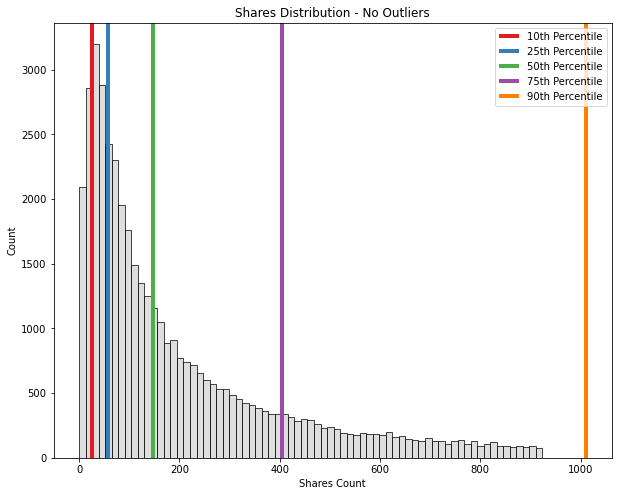

In [596]:
# let's look at that histogram without outliers
hist_with_vlines(df=df.loc[df['shares_outliers'].isna()], x_col='shares_count',
                x_label='Shares Count', 
                title='Shares Distribution - No Outliers', 
                lines_dict=shares_pcts)

In [597]:
df.loc[df['shares_outliers'].isna(), 'shares_count'].describe()

count    42547.000000
mean       200.218558
std        206.150060
min          0.000000
25%         50.500000
50%        120.000000
75%        280.500000
max        924.000000
Name: shares_count, dtype: float64

In [598]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47866 entries, 0 to 48087
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                47866 non-null  object 
 1   caption           47866 non-null  object 
 2   post_type         47866 non-null  object 
 3   status_type       47866 non-null  object 
 4   comments_count    47866 non-null  int64  
 5   shares_count      47866 non-null  int64  
 6   link              47200 non-null  object 
 7   posted_at         47866 non-null  object 
 8   print_section     47866 non-null  object 
 9   print_page        47866 non-null  object 
 10  snippet           43227 non-null  object 
 11  lead_paragraph    43227 non-null  object 
 12  main_headline     43227 non-null  object 
 13  news_desk         47866 non-null  object 
 14  section_name      47866 non-null  object 
 15  type_of_material  47866 non-null  object 
 16  word_count        47866 non-null  float6

### Relationship to Categorical Variables

---------------------------------------------------------------------------
Exploring column: status_type
---------------------------------------------------------------------------
---------------------------------------------------------------------------
Value Counts for categorical data: status_type
---------------------------------------------------------------------------
shared_story            43359
added_photos             2248
added_video              1574
mobile_status_update      654
None                       11
created_note               11
created_event               9
Name: status_type, dtype: int64


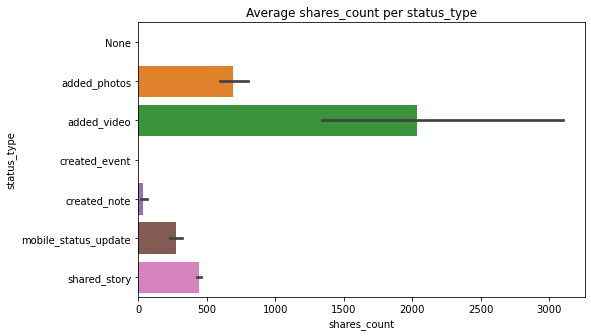

---------------------------------------------------------------------------
Exploring column: caption
---------------------------------------------------------------------------
---------------------------------------------------------------------------
Value Counts for categorical data: caption
---------------------------------------------------------------------------
nytimes.com                                               31246
nyti.ms                                                    7700
None                                                       4974
well.blogs.nytimes.com                                      815
cooking.nytimes.com                                         807
                                                          ...  
Launched NYT Now for iPhone.                                  1
messenger.com                                                 1
inyt.com                                                      1
TimesTalks - Alain Ducasse, Daniel Boulud, Eric Rip

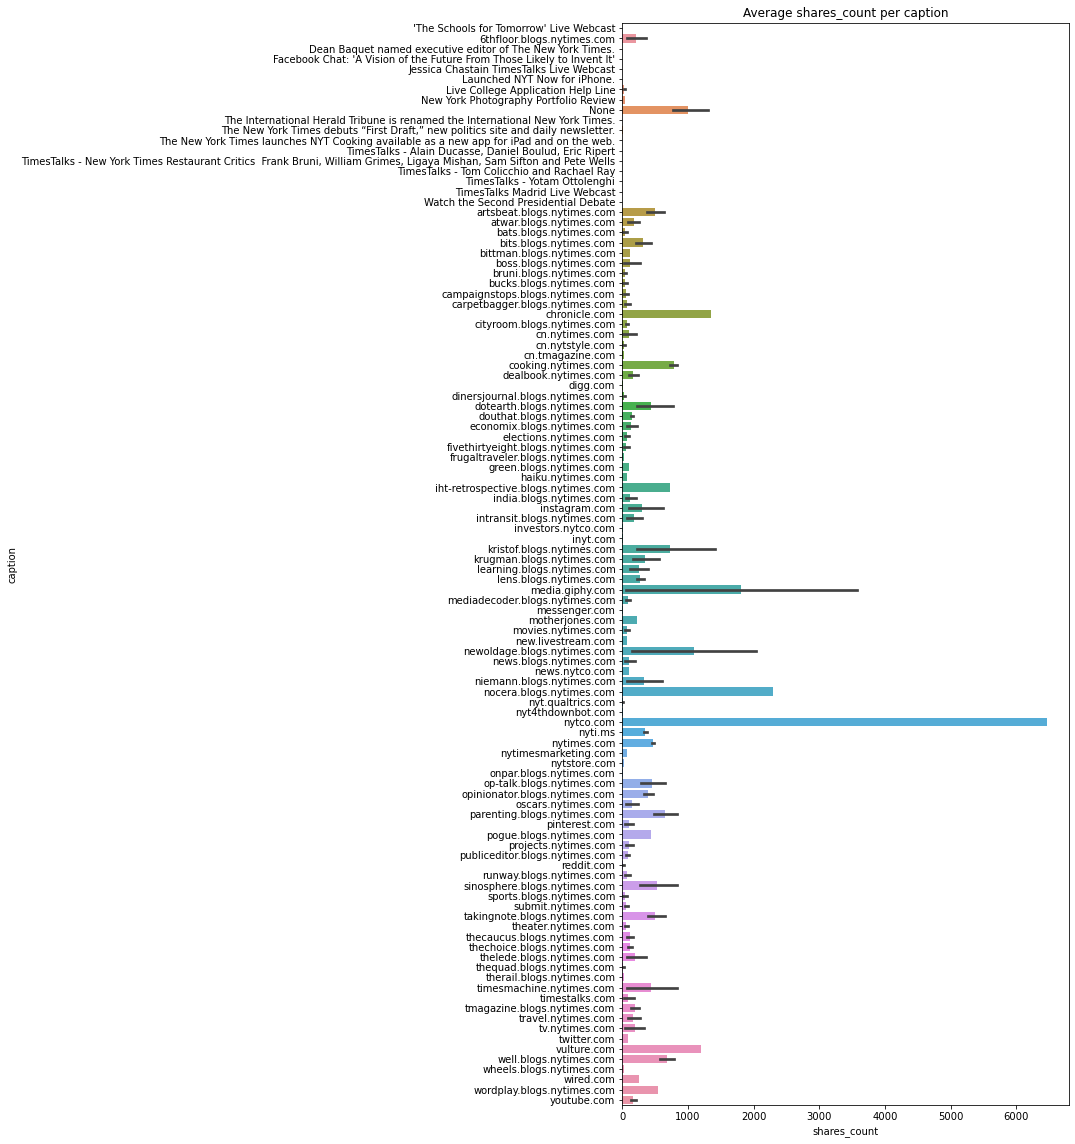

---------------------------------------------------------------------------
Exploring column: post_type
---------------------------------------------------------------------------
---------------------------------------------------------------------------
Value Counts for categorical data: post_type
---------------------------------------------------------------------------
link      42785
photo      2340
video      2062
status      666
event        12
note          1
Name: post_type, dtype: int64


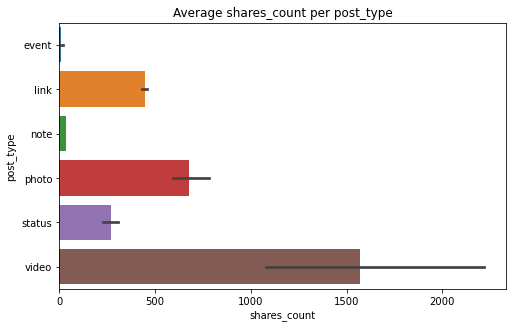

---------------------------------------------------------------------------
Exploring column: print_section
---------------------------------------------------------------------------
---------------------------------------------------------------------------
Value Counts for categorical data: print_section
---------------------------------------------------------------------------
A              18527
None           11524
Not matched     4639
B               3359
D               2380
               ...  
6                  2
G                  1
1                  1
CT                 1
LI                 1
Name: print_section, Length: 29, dtype: int64


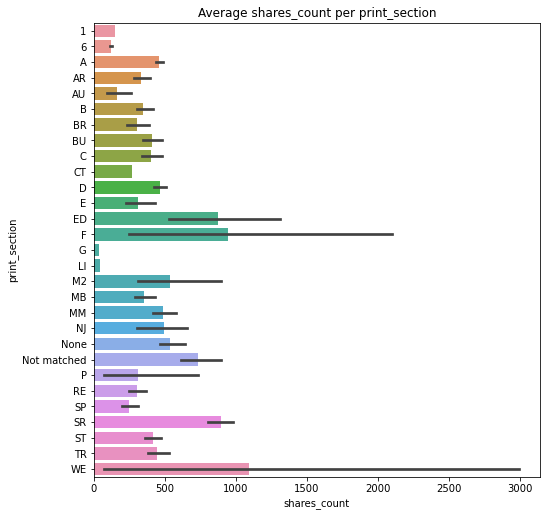

---------------------------------------------------------------------------
Exploring column: print_page
---------------------------------------------------------------------------
---------------------------------------------------------------------------
Value Counts for categorical data: print_page
---------------------------------------------------------------------------
1              11676
None           11524
Not matched     4639
4               1755
6               1429
               ...  
127                1
110                1
268                1
204                1
107                1
Name: print_page, Length: 152, dtype: int64


---------------------------------------------------------------------------
Exploring column: news_desk
---------------------------------------------------------------------------
---------------------------------------------------------------------------
Value Counts for categorical data: news_desk
---------------------------------------------------------------------------
National                  7718
Foreign                   6844
Not matched               4639
Business                  3476
OpEd                      2957
                          ... 
Home & Garden                1
Editorial Desk               1
Museums                      1
The Arts/Cultural Desk       1
Jobs                         1
Name: news_desk, Length: 81, dtype: int64


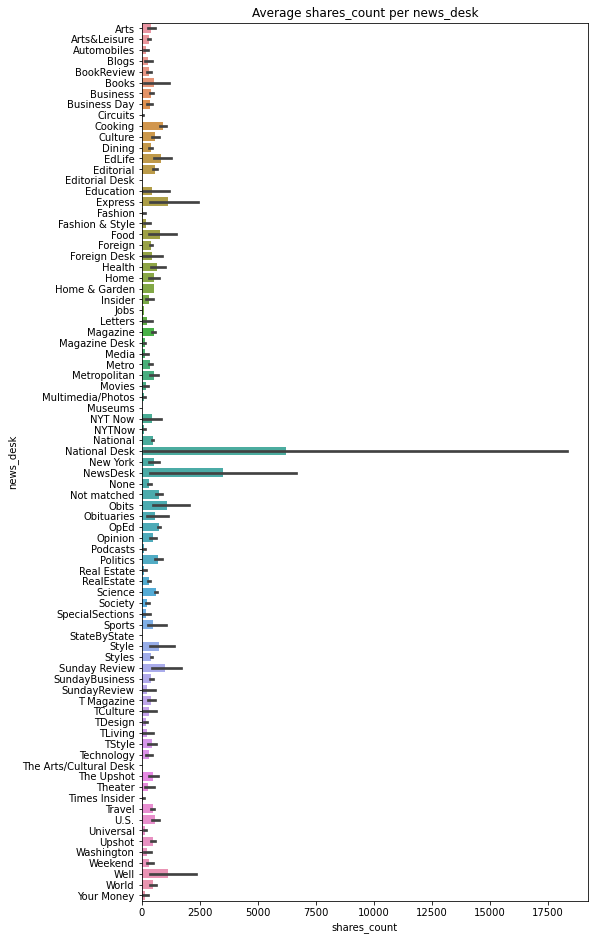

---------------------------------------------------------------------------
Exploring column: section_name
---------------------------------------------------------------------------
---------------------------------------------------------------------------
Value Counts for categorical data: section_name
---------------------------------------------------------------------------
U.S.             8314
World            6811
Not matched      4639
Opinion          4616
Sports           2662
                 ... 
Giving              3
Watching            2
Public Editor       2
Universal           1
Archives            1
Name: section_name, Length: 45, dtype: int64


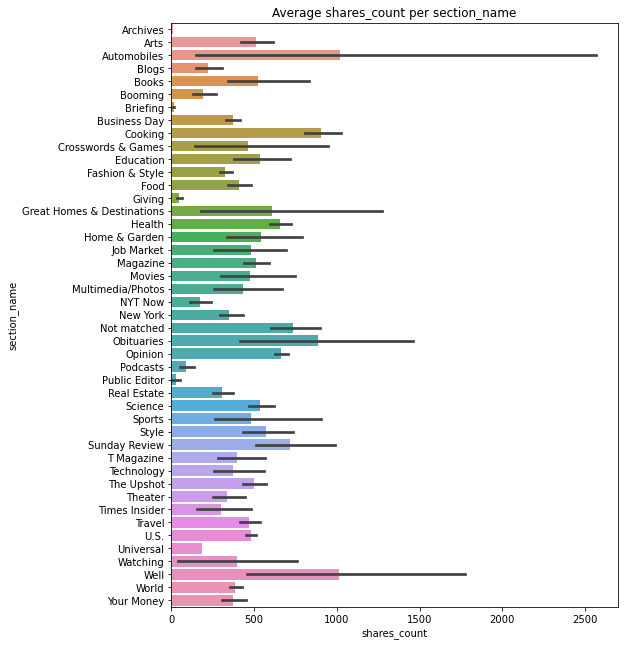

---------------------------------------------------------------------------
Exploring column: type_of_material
---------------------------------------------------------------------------
---------------------------------------------------------------------------
Value Counts for categorical data: type_of_material
---------------------------------------------------------------------------
News                   33274
Not matched             4639
Op-Ed                   3272
Interactive Feature     2346
Review                   834
                       ...  
Chronology                 1
Military Analysis          1
Quote                      1
Correction                 1
Schedule                   1
Name: type_of_material, Length: 33, dtype: int64


---------------------------------------------------------------------------
Exploring column: word_count
---------------------------------------------------------------------------
---------------------------------------------------------------------------
df.describe() for continuous data: word_count
---------------------------------------------------------------------------
count    47866.000000
mean       974.637216
std        938.075061
min          0.000000
25%        452.000000
50%        936.000000
75%       1267.000000
max      18273.000000
Name: word_count, dtype: float64


---------------------------------------------------------------------------
Exploring column: is_matched
---------------------------------------------------------------------------
---------------------------------------------------------------------------
Value Counts for categorical data: is_matched
---------------------------------------------------------------------------
1.0    43227
0.0     4639
Name: is_matched, dtype: int64


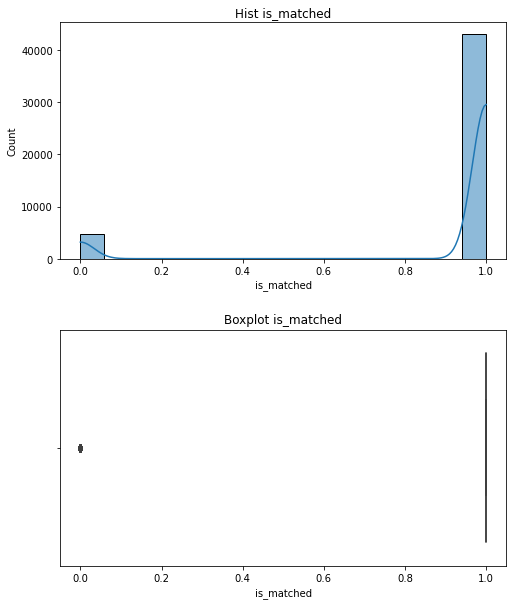

col_name  corr_target assumed_var_type omnibus_k2 omnibus_pstat  \
0  word_count    -0.016502       continuous       None          None   
1  is_matched    -0.023358      categorical       None          None   

  is_normal  uniques        mean  median  
0      None      NaN  974.637216   936.0  
1      None      2.0         NaN     NaN

In [599]:
to_explore = ['status_type', 'caption', 'post_type', 'print_section', 
              'print_page', 'news_desk', 'section_name', 'type_of_material',
             'word_count', 'is_matched']

eda.explore_data_cont(to_explore, df, 'shares_count', hist=True, box=True, 
                      plot_v_target=False,
                 summarize=True, norm_check=False)

In [600]:
# Let's take a look at nytco.com
df.loc[df['caption']=='nytco.com'].values

array([['5281959998_10150952720054999', 'nytco.com', 'link',
        'shared_story', 548, 6477,
        'http://www.nytco.com/the-new-york-times-to-offer-open-access-to-nytimes-com-november-7-9/?smid=fb-nytimes&smtyp=cur',
        '2016-11-03 18:59:23', 'Not matched', 'Not matched', nan, nan,
        nan, 'Not matched', 'Not matched', 'Not matched', 0.0, nan, nan,
        nan, nan, nan, 0.0,
        "The New York Times to Offer Open Access To NYTimes.com November 7-9. We're giving everyone unlimited access to The New York Times for 72 hours next week.. Readers will have unlimited access to NYTimes.com for 72 hours from 12:01 a.m. ET on Monday, November 7 until 11:59 p.m. ET on Wednesday, November 9.",
        18036, 1.0]], dtype=object)

In [601]:
# Let's take a look at print_page=151
df.loc[df['print_page']=='151'].values

array([['5281959998_10150931251884999', 'nytimes.com', 'link',
        'shared_story', 1813, 17589,
        'http://www.nytimes.com/2016/10/17/t-magazine/michelle-obama-chimamanda-ngozi-adichie-gloria-steinem-letter.html?smid=fb-nytimes&smtyp=cur',
        '2016-10-17 12:25:00', 'M2', '151',
        'Four thank-you notes to Michelle Obama, who has spent the past eight years quietly and confidently changing the course of American history.',
        'She had rhythm, a flow and swerve, hands slicing air, body weight moving from foot to foot, a beautiful rhythm. In anything else but a black American body, it would have been contrived. The three-quarter sleeves of her teal dress announced its appropriateness, as did her matching brooch. But the cut of the dress scorned any “future first lady” stuffiness; it hung easy on her, as effortless as her animation. And a brooch, Old World style accessory, yes, but hers was big and ebulliently shaped and perched center on her chest. Michelle Obama wa

In [602]:
# Let's take a look at print_section=WE and F
df.loc[df['print_section']=='WE']

id      caption post_type   status_type  \
10117  5281959998_10150445008109999  nytimes.com      link  shared_story   
17219  5281959998_10150515450389999      nyti.ms      link  shared_story   
17244  5281959998_10150515741844999  nytimes.com      link  shared_story   
24969  5281959998_10150613019824999  nytimes.com      link  shared_story   
30329  5281959998_10150684643079999  nytimes.com      link  shared_story   

       comments_count  shares_count                    link  \
10117               8            41  http://nyti.ms/1kSUpJv   
17219               2            96  http://nyti.ms/14b8NoR   
17244              12            88  http://nyti.ms/1Kf3iGI   
24969             356          4839  http://nyti.ms/1Lu2kaI   
30329              73           400  http://nyti.ms/1PK1F8b   

                 posted_at print_section print_page  ... word_count  \
10117  2014-08-19 23:23:23            WE          4  ...      808.0   
17219  2015-01-05 03:22:00            WE          9  ...      964.0   
17244  2015-01-05 19:10:00            WE          9  ...      964.0   
24969  2015-06-27 07:55:00            WE         10  ...     1113.0   
30329  2015-10-24 22:27:01            WE          9  ...      809.0   

                                              glocations  \
10117                                 [long island (ny)]   
17219                                   [woodstock (ny)]   
17244                                   [woodstock (ny)]   
24969                                     [yonkers (ny)]   
30329  [croton-on-hudson (ny), hudson river valley (ny)]   

                                                 subject  \
10117  [collectors and collections, audio recordings,...   
17219                                [music, rock music]   
17244                                [music, rock music]   
24969  [art, models and replicas, children and childh...   
30329  [pumpkins, art, sculpture, historic buildings ...   

                          persons  \
10117               [dilg, peter]   
17219  [weider, jim, helm, levon]   
17244  [weider, jim, helm, levon]   
24969            [picasso, pablo]   
30329                         NaN   

                                           organizations creative_works  \
10117                                                NaN            NaN   
17219  [city winery, levon helm studios (woodstock, n...            NaN   
17244  [city winery, levon helm studios (woodstock, n...            NaN   
24969                                       [lego group]            NaN   
30329  [van cortlandt manor (croton-on-hudson, ny), h...            NaN   

       is_matched                                           all_text  \
10117         1.0  An Ear to the Horn of Time. “It’s an echo from...   
17219         1.0  Arts | Woodstock: From the Band’s Music, the W...   
17244         1.0  From the Band’s Music, the Weight Builds a Fut...   
24969         1.0  A Legoland Builder Turns Her Childhood Hobby I...   
30329         1.0  The Spark Behind the Great Jack-o’-Lantern Bla...   

      likes_loves shares_outliers  
10117         195             NaN  
17219         364             NaN  
17244         338             NaN  
24969       15964             1.0  
30329        2266             NaN  

[5 rows x 26 columns]

In [603]:
df.loc[df['print_section']=='F']

id               caption post_type  \
630      5281959998_465841950121115           nytimes.com      link   
632      5281959998_444090335650702           nytimes.com      link   
1029     5281959998_422066364533996  projects.nytimes.com      link   
1039     5281959998_497482543629133           nytimes.com      link   
2067     5281959998_569888266368407           nytimes.com      link   
...                             ...                   ...       ...   
46546  5281959998_10150918431994999           nytimes.com      link   
47718  5281959998_10150946299799999           nytimes.com      link   
47727  5281959998_10150945329194999           nytimes.com      link   
48025  5281959998_10150956895449999           nytimes.com      link   
48071  5281959998_10150958116574999           nytimes.com      link   

        status_type  comments_count  shares_count  \
630    shared_story             113            35   
632    shared_story               7            62   
1029   shared_story              14           109   
1039   shared_story              64           322   
2067   shared_story             137           531   
...             ...             ...           ...   
46546  shared_story              11            17   
47718  shared_story              96           702   
47727  shared_story              73           149   
48025  shared_story              43            69   
48071  shared_story              10            22   

                                                    link            posted_at  \
630    http://www.nytimes.com/2012/11/09/giving/komen...  2012-11-09 20:01:59   
632    http://www.nytimes.com/2012/11/09/giving/the-o...  2012-11-09 21:42:55   
1029   http://projects.nytimes.com/2012/snow-fall-pre...  2012-12-20 05:38:48   
1039     http://www.nytimes.com/projects/2012/snow-fall/  2012-12-20 21:40:06   
2067   http://www.nytimes.com/2013/03/26/your-money/t...  2013-03-27 21:15:20   
...                                                  ...                  ...   
46546  http://www.nytimes.com/2016/10/06/style/home-d...  2016-10-04 17:25:00   
47718                             http://nyti.ms/2f03kYV  2016-10-29 22:25:00   
47727  http://www.nytimes.com/2016/10/30/arts/design/...  2016-10-30 10:25:00   
48025  http://www.nytimes.com/2016/11/07/sports/new-y...  2016-11-06 22:55:00   
48071  http://www.nytimes.com/2016/03/28/sports/boxin...  2016-11-07 19:10:00   

      print_section print_page  ... word_count  \
630               F          2  ...     1417.0   
632               F          4  ...      999.0   
1029              F          3  ...    16574.0   
1039              F          3  ...    16574.0   
2067              F          6  ...     1162.0   
...             ...        ...  ...        ...   
46546             F          8  ...     1961.0   
47718             F         34  ...     1299.0   
47727             F         36  ...     1064.0   
48025             F          1  ...     1367.0   
48071             F          1  ...     7575.0   

                                 glocations  \
630                                     NaN   
632                   [afghanistan, africa]   
1029   [seattle (wash), washington (state)]   
1039   [seattle (wash), washington (state)]   
2067                                    NaN   
...                                     ...   
46546                                   NaN   
47718                                   NaN   
47727                                   NaN   
48025                                   NaN   
48071                                   NaN   

                                                 subject  \
630    [advertising and marketing, breast cancer, phi...   
632    [third world and developing countries, humanit...   
1029   [avalanches, alpine skiing, snow and snowstorm...   
1039   [avalanches, alpine skiing, snow and snowstorm...   
2067   [careers and professions, emotions, personal f...   
...                                         

Links to articles are generally represented by:
- `status_type` = `shared_story`
- majority are`caption` = `nytimes.com`
- `post_type` = `link`

These do not generally receive the highest number of shares.
- Although there are far fewer of them, `added_video` and `added_photo` posts receive more shares than `shared_story`
- `nytco.com` has a ton of shares, although it represents only a single post where they're offering free access during the election. Other captions that look like outsides sources or non-news sources such as blogs also have more shares than the `nytimes.com`.
- `photo` and `video` have more shares than `link`s.
- I don't see much pattern in the `print_page` or `print_section` categories. Some stand out, but they seem to be singletons. I'm also not totally sure how to interpret these, since I don't know what the values stand for.
- Nothing stands out much in `news_desk`
- Cooking seems to have steadily more shares than other `section_names`. Others look to have high scores but very broad confidence intervals.
- Obituaries and Recipes have higher numbers of shares in `type_of_material`.


## Explore Comments

### Review Distribution and Identify Outliers

In [604]:
df['comments_count'].describe()

count     47866.000000
mean        179.165692
std         998.999651
min           0.000000
25%          33.000000
50%          73.000000
75%         173.000000
max      169805.000000
Name: comments_count, dtype: float64

Median is 73 and mean is 179, so definitely not normally distributed. Seems there are some high outliers and the histogram confirms it.

Let's look at the max entry here.

In [605]:
# histogram of comments
fig, ax = plt.subplots(figsize=(8, 4))
sns.histplot(x=df['comments_count'], ax=ax, bins=50);

In [606]:
df.loc[df['comments_count']==169805].values

array([['5281959998_10150912083309999', 'None', 'video', 'added_video',
        169805, 40387,
        'https://www.facebook.com/nytimes/videos/10150912083309999/',
        '2016-09-27 01:04:52', 'Not matched', 'Not matched', nan, nan,
        nan, 'Not matched', 'Not matched', 'Not matched', 0.0, nan, nan,
        nan, nan, nan, 0.0,
        '2016 Presidential Debate. Watch Donald J. Trump and Hillary Clinton’s first debate live here. Follow along in the comments for NYT reporters’ live analysis of the debate.. ',
        123533, 1.0]], dtype=object)

Interesting, so the post that got the highest comments is not the one that got the highest number of shares. This post got way more comments than other types of interactions.

Since the message says to `"follow along in the comments"`, I assume that this was livestreamed.

In [607]:
# mark outliers for shares count
df = eda.mark_outliers(df, 'comments_count', 'comments_outliers')

Number of lower outliers to mark: 0
Number of upper outliers to mark: 4781


In [608]:
# get percentile cutoffs for entire distribution
comments_pcts = {}

for pct in [10, 25, 50, 75, 90]:
    comments_pcts[f'{pct}th Percentile'] = df['comments_count'].quantile(q=pct/100)

comments_pcts

{'10th Percentile': 17.0,
 '25th Percentile': 33.0,
 '50th Percentile': 73.0,
 '75th Percentile': 173.0,
 '90th Percentile': 383.0}

In [609]:
# let's look at that histogram without outliers
hist_with_vlines(df=df.loc[df['comments_outliers'].isna()], 
                x_col='comments_count',
                x_label='Comments Count', 
                title='Comments Distribution - No Outliers', 
                lines_dict=comments_pcts)

In [610]:
df.loc[df['comments_outliers'].isna(), 'comments_count'].describe()

count    43085.000000
mean        93.178902
std         85.179312
min          0.000000
25%         30.000000
50%         63.000000
75%        130.000000
max        383.000000
Name: comments_count, dtype: float64

### Relationship to Categorical Variables

---------------------------------------------------------------------------
Exploring column: status_type
---------------------------------------------------------------------------
---------------------------------------------------------------------------
Value Counts for categorical data: status_type
---------------------------------------------------------------------------
shared_story            43359
added_photos             2248
added_video              1574
mobile_status_update      654
None                       11
created_note               11
created_event               9
Name: status_type, dtype: int64


---------------------------------------------------------------------------
Exploring column: caption
---------------------------------------------------------------------------
---------------------------------------------------------------------------
Value Counts for categorical data: caption
---------------------------------------------------------------------------
nytimes.com                                               31246
nyti.ms                                                    7700
None                                                       4974
well.blogs.nytimes.com                                      815
cooking.nytimes.com                                         807
                                                          ...  
Launched NYT Now for iPhone.                                  1
messenger.com                                                 1
inyt.com                                                      1
TimesTalks - Alain Ducasse, Daniel Boulud, Eric Rip

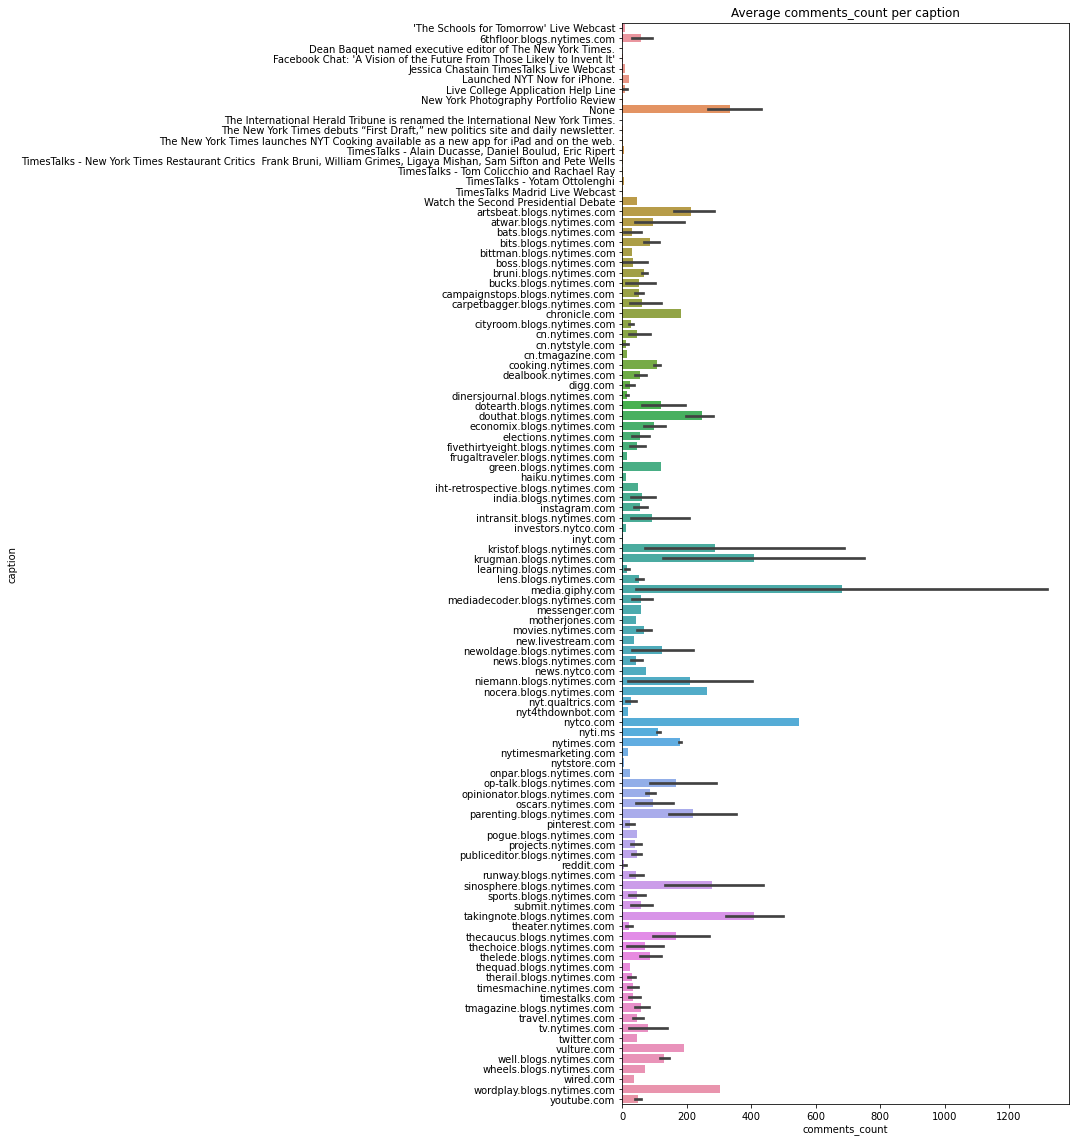

---------------------------------------------------------------------------
Exploring column: post_type
---------------------------------------------------------------------------
---------------------------------------------------------------------------
Value Counts for categorical data: post_type
---------------------------------------------------------------------------
link      42785
photo      2340
video      2062
status      666
event        12
note          1
Name: post_type, dtype: int64


---------------------------------------------------------------------------
Exploring column: print_section
---------------------------------------------------------------------------
---------------------------------------------------------------------------
Value Counts for categorical data: print_section
---------------------------------------------------------------------------
A              18527
None           11524
Not matched     4639
B               3359
D               2380
               ...  
6                  2
G                  1
1                  1
CT                 1
LI                 1
Name: print_section, Length: 29, dtype: int64


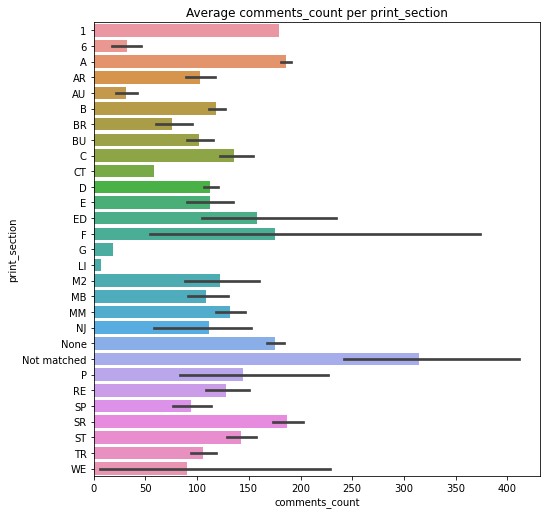

---------------------------------------------------------------------------
Exploring column: print_page
---------------------------------------------------------------------------
---------------------------------------------------------------------------
Value Counts for categorical data: print_page
---------------------------------------------------------------------------
1              11676
None           11524
Not matched     4639
4               1755
6               1429
               ...  
127                1
110                1
268                1
204                1
107                1
Name: print_page, Length: 152, dtype: int64


---------------------------------------------------------------------------
Exploring column: news_desk
---------------------------------------------------------------------------
---------------------------------------------------------------------------
Value Counts for categorical data: news_desk
---------------------------------------------------------------------------
National                  7718
Foreign                   6844
Not matched               4639
Business                  3476
OpEd                      2957
                          ... 
Home & Garden                1
Editorial Desk               1
Museums                      1
The Arts/Cultural Desk       1
Jobs                         1
Name: news_desk, Length: 81, dtype: int64


---------------------------------------------------------------------------
Exploring column: section_name
---------------------------------------------------------------------------
---------------------------------------------------------------------------
Value Counts for categorical data: section_name
---------------------------------------------------------------------------
U.S.             8314
World            6811
Not matched      4639
Opinion          4616
Sports           2662
                 ... 
Giving              3
Watching            2
Public Editor       2
Universal           1
Archives            1
Name: section_name, Length: 45, dtype: int64


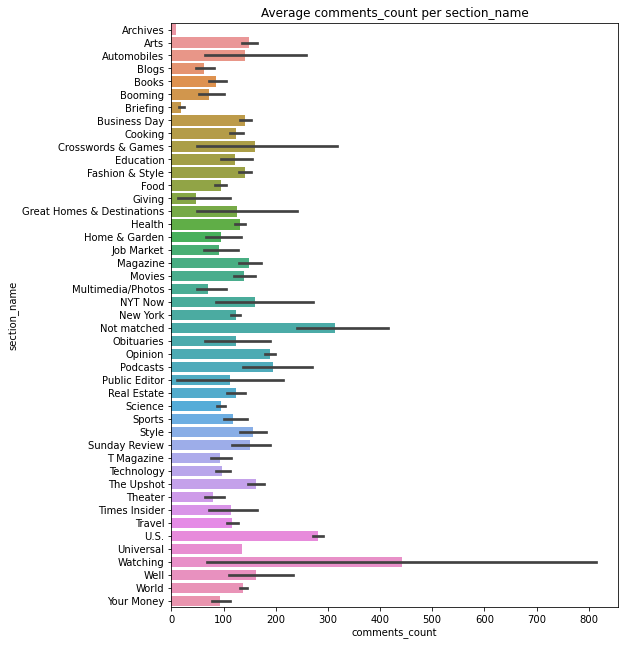

---------------------------------------------------------------------------
Exploring column: type_of_material
---------------------------------------------------------------------------
---------------------------------------------------------------------------
Value Counts for categorical data: type_of_material
---------------------------------------------------------------------------
News                   33274
Not matched             4639
Op-Ed                   3272
Interactive Feature     2346
Review                   834
                       ...  
Chronology                 1
Military Analysis          1
Quote                      1
Correction                 1
Schedule                   1
Name: type_of_material, Length: 33, dtype: int64


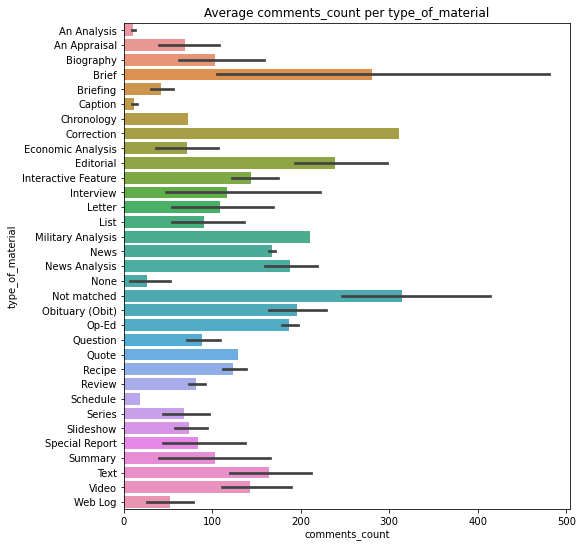

---------------------------------------------------------------------------
Exploring column: word_count
---------------------------------------------------------------------------
---------------------------------------------------------------------------
df.describe() for continuous data: word_count
---------------------------------------------------------------------------
count    47866.000000
mean       974.637216
std        938.075061
min          0.000000
25%        452.000000
50%        936.000000
75%       1267.000000
max      18273.000000
Name: word_count, dtype: float64


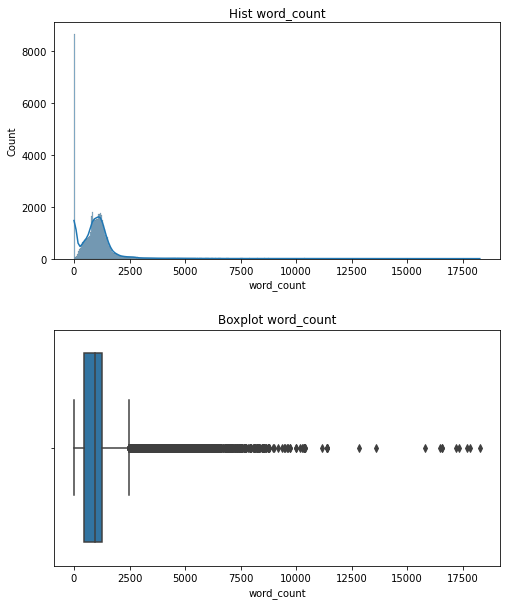

---------------------------------------------------------------------------
Exploring column: is_matched
---------------------------------------------------------------------------
---------------------------------------------------------------------------
Value Counts for categorical data: is_matched
---------------------------------------------------------------------------
1.0    43227
0.0     4639
Name: is_matched, dtype: int64


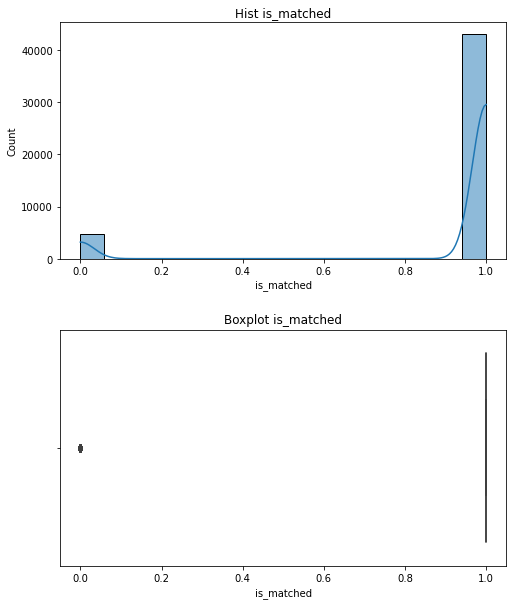

col_name  corr_target assumed_var_type omnibus_k2 omnibus_pstat  \
0  word_count    -0.024446       continuous       None          None   
1  is_matched    -0.044291      categorical       None          None   

  is_normal  uniques        mean  median  
0      None      NaN  974.637216   936.0  
1      None      2.0         NaN     NaN

In [611]:
eda.explore_data_cont(to_explore, df, 'comments_count', hist=True, box=True, 
                      plot_v_target=False,
                 summarize=True, norm_check=False)

- Video posts seem to get a lot more comments than links to articles, photos, or status updates.
- In `news_desk`, both National Desk and NewsDesk were higher in shares as well as comments. But where Cooking was high in shares it isn't in comments, and instead Politics is high in comments.
- `Not Matched` seems to be high in comments in `type_of_material` and `section_name`, meaning the posts that I wasn't able to match up to articles.

## Explore Likes

### Review Distribution and Identify Outliers

In [612]:
df['likes_loves'].describe()

count     47866.000000
mean       1921.830276
std        6490.057071
min           0.000000
25%         338.000000
50%         703.000000
75%        1635.000000
max      553589.000000
Name: likes_loves, dtype: float64

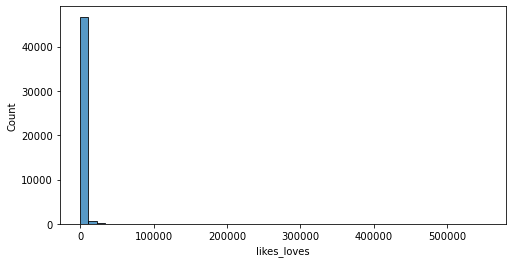

In [613]:
# histogram of likes/loves
fig, ax = plt.subplots(figsize=(8, 4))
sns.histplot(x=df['likes_loves'], ax=ax, bins=50);

Median is 703 and mean is 1921, so definitely not normally distributed.

Let's look at the max entry here.

In [614]:
df.loc[df['likes_loves']==553589].values

array([['5281959998_10150868636734999', 'None', 'video', 'added_video',
        30921, 528856,
        'https://www.facebook.com/nytimes/videos/10150868636734999/',
        '2016-08-09 19:24:00', 'None', 'None',
        'Mary Lou Retton has described her as the top gymnast in history.',
        'Mary Lou Retton has described her as the top gymnast in history.',
        'The Fine Line: What Makes Simone Biles the World’s Best Gymnast',
        'Sports', 'Sports', 'Interactive Feature', 0.0, nan,
        list(['olympic games (2016)', 'gymnastics']),
        list(['biles, simone']), nan, nan, 1.0,
        "What makes Simone Biles the world’s best gymnast. 'At this point in time, nobody can beat Simone Biles,' Nastia Liukin, 2008 Olympic gold medalist said. http://nyti.ms/2az4AAu. ",
        553589, 1.0, 1.0]], dtype=object)

Same as the post with highest shares.

In [615]:
# mark outliers for shares count
df = eda.mark_outliers(df, 'likes_loves', 'likelove_outliers')

Number of lower outliers to mark: 0
Number of upper outliers to mark: 5191


In [616]:
# get percentile cutoffs for entire distribution
likes_pcts = {}

for pct in [10, 25, 50, 75, 90]:
    likes_pcts[f'{pct}th Percentile'] = df['likes_loves'].quantile(q=pct/100)

likes_pcts

{'10th Percentile': 184.0,
 '25th Percentile': 338.0,
 '50th Percentile': 703.0,
 '75th Percentile': 1635.0,
 '90th Percentile': 3833.0}

In [617]:
# let's look at that histogram without outliers
hist_with_vlines(df=df.loc[df['likelove_outliers'].isna()], 
                x_col='likes_loves',
                x_label='Likes/Loves Count', 
                title='Likes/Loves Distribution - No Outliers', 
                lines_dict=likes_pcts)

In [618]:
df.loc[df['likelove_outliers'].isna(), 'likes_loves'].describe()

count    42675.000000
mean       875.987862
std        778.874725
min          0.000000
25%        308.000000
50%        602.000000
75%       1195.000000
max       3580.000000
Name: likes_loves, dtype: float64

### Relationship to Categorical Variables

---------------------------------------------------------------------------
Exploring column: status_type
---------------------------------------------------------------------------
---------------------------------------------------------------------------
Value Counts for categorical data: status_type
---------------------------------------------------------------------------
shared_story            43359
added_photos             2248
added_video              1574
mobile_status_update      654
None                       11
created_note               11
created_event               9
Name: status_type, dtype: int64


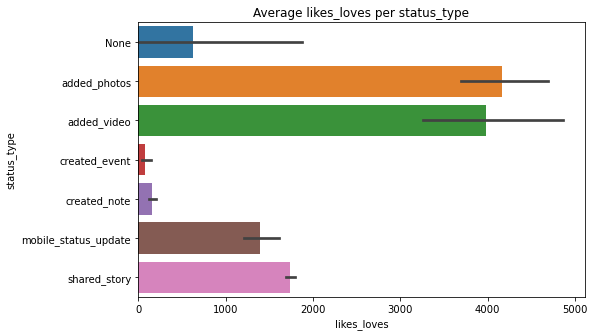

---------------------------------------------------------------------------
Exploring column: caption
---------------------------------------------------------------------------
---------------------------------------------------------------------------
Value Counts for categorical data: caption
---------------------------------------------------------------------------
nytimes.com                                               31246
nyti.ms                                                    7700
None                                                       4974
well.blogs.nytimes.com                                      815
cooking.nytimes.com                                         807
                                                          ...  
Launched NYT Now for iPhone.                                  1
messenger.com                                                 1
inyt.com                                                      1
TimesTalks - Alain Ducasse, Daniel Boulud, Eric Rip

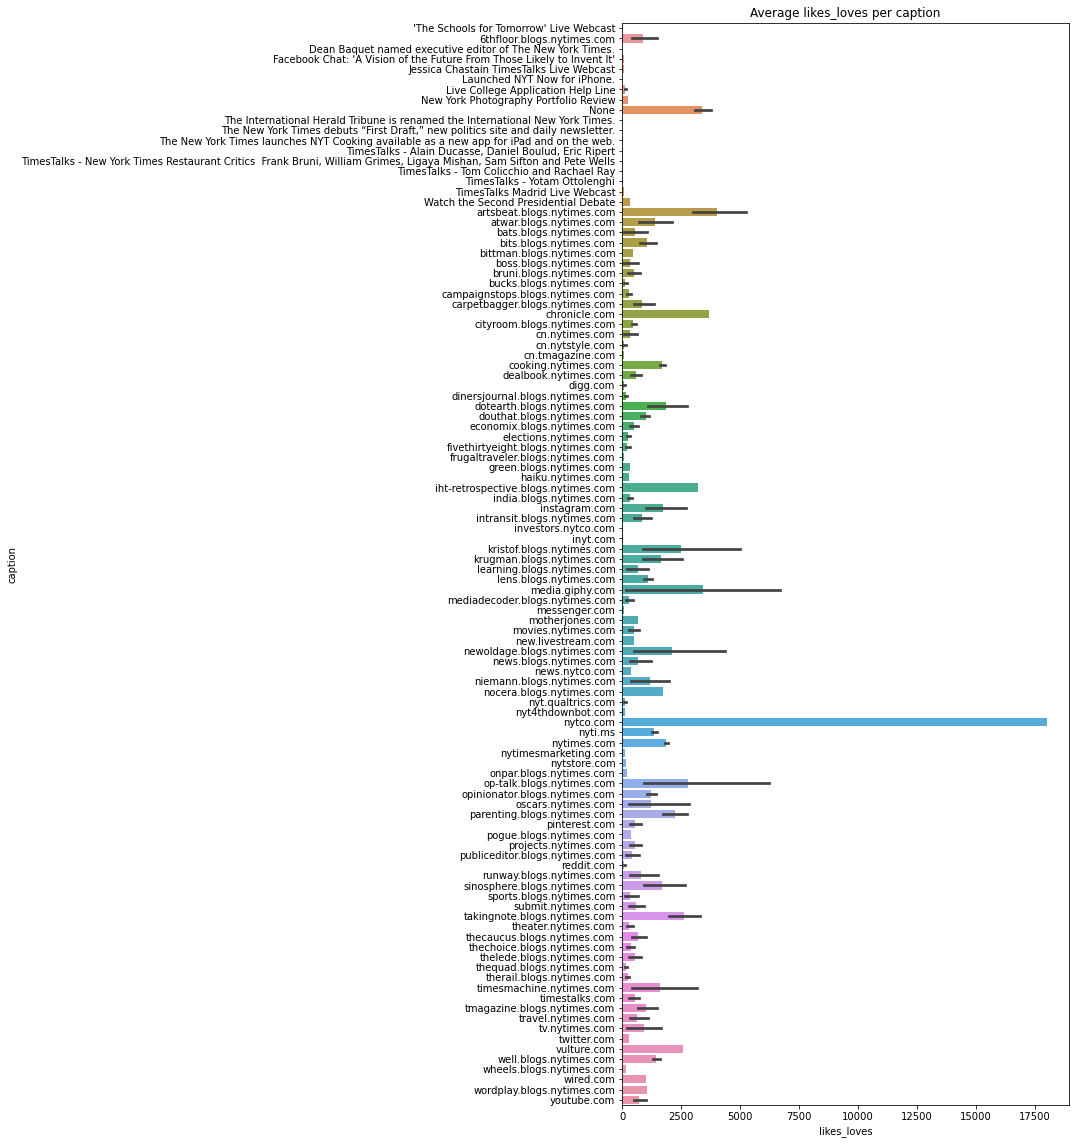

---------------------------------------------------------------------------
Exploring column: post_type
---------------------------------------------------------------------------
---------------------------------------------------------------------------
Value Counts for categorical data: post_type
---------------------------------------------------------------------------
link      42785
photo      2340
video      2062
status      666
event        12
note          1
Name: post_type, dtype: int64


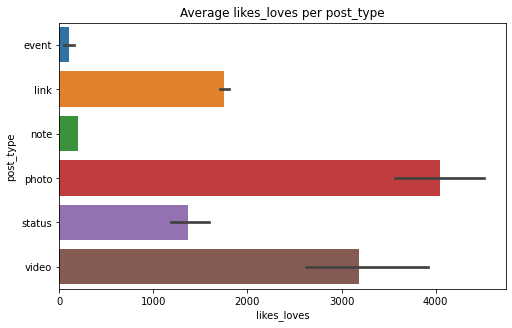

---------------------------------------------------------------------------
Exploring column: print_section
---------------------------------------------------------------------------
---------------------------------------------------------------------------
Value Counts for categorical data: print_section
---------------------------------------------------------------------------
A              18527
None           11524
Not matched     4639
B               3359
D               2380
               ...  
6                  2
G                  1
1                  1
CT                 1
LI                 1
Name: print_section, Length: 29, dtype: int64


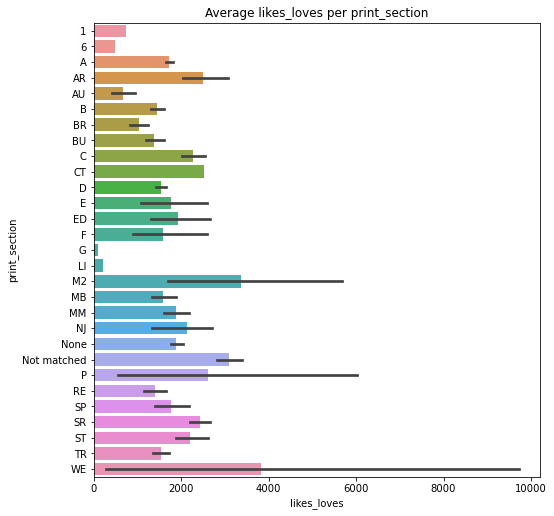

---------------------------------------------------------------------------
Exploring column: print_page
---------------------------------------------------------------------------
---------------------------------------------------------------------------
Value Counts for categorical data: print_page
---------------------------------------------------------------------------
1              11676
None           11524
Not matched     4639
4               1755
6               1429
               ...  
127                1
110                1
268                1
204                1
107                1
Name: print_page, Length: 152, dtype: int64


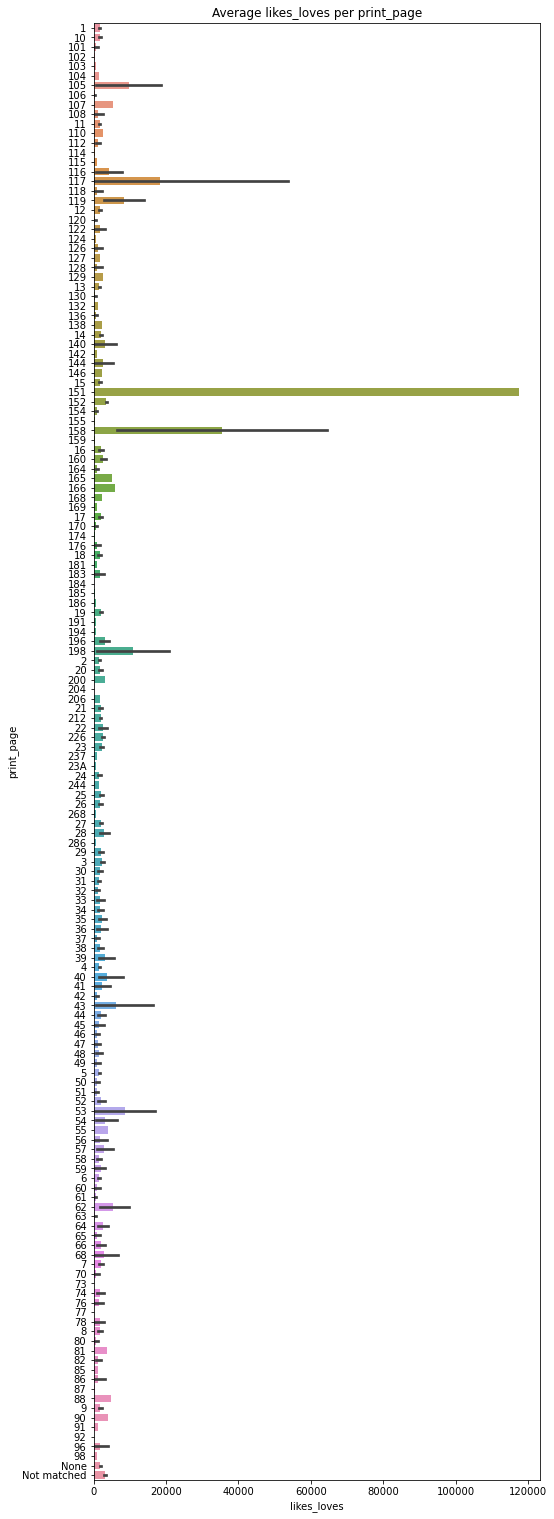

---------------------------------------------------------------------------
Exploring column: news_desk
---------------------------------------------------------------------------
---------------------------------------------------------------------------
Value Counts for categorical data: news_desk
---------------------------------------------------------------------------
National                  7718
Foreign                   6844
Not matched               4639
Business                  3476
OpEd                      2957
                          ... 
Home & Garden                1
Editorial Desk               1
Museums                      1
The Arts/Cultural Desk       1
Jobs                         1
Name: news_desk, Length: 81, dtype: int64


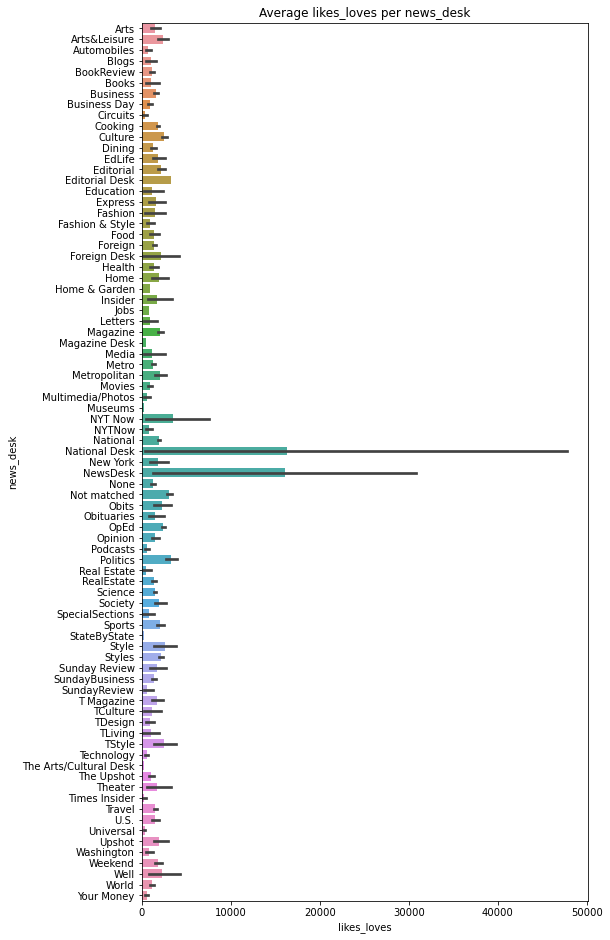

---------------------------------------------------------------------------
Exploring column: section_name
---------------------------------------------------------------------------
---------------------------------------------------------------------------
Value Counts for categorical data: section_name
---------------------------------------------------------------------------
U.S.             8314
World            6811
Not matched      4639
Opinion          4616
Sports           2662
                 ... 
Giving              3
Watching            2
Public Editor       2
Universal           1
Archives            1
Name: section_name, Length: 45, dtype: int64


---------------------------------------------------------------------------
Exploring column: type_of_material
---------------------------------------------------------------------------
---------------------------------------------------------------------------
Value Counts for categorical data: type_of_material
---------------------------------------------------------------------------
News                   33274
Not matched             4639
Op-Ed                   3272
Interactive Feature     2346
Review                   834
                       ...  
Chronology                 1
Military Analysis          1
Quote                      1
Correction                 1
Schedule                   1
Name: type_of_material, Length: 33, dtype: int64


---------------------------------------------------------------------------
Exploring column: word_count
---------------------------------------------------------------------------
---------------------------------------------------------------------------
df.describe() for continuous data: word_count
---------------------------------------------------------------------------
count    47866.000000
mean       974.637216
std        938.075061
min          0.000000
25%        452.000000
50%        936.000000
75%       1267.000000
max      18273.000000
Name: word_count, dtype: float64


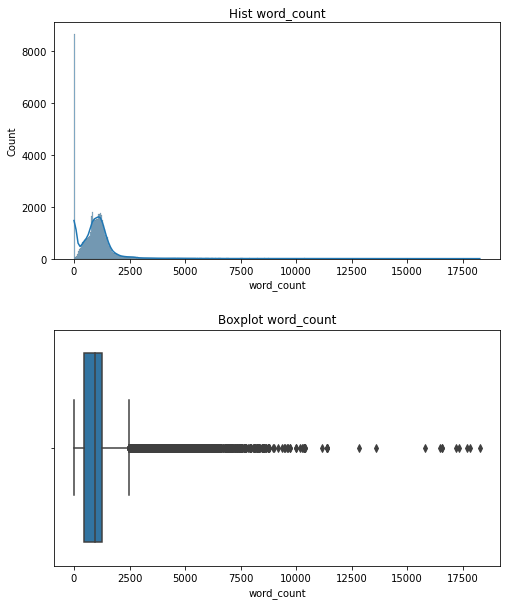

---------------------------------------------------------------------------
Exploring column: is_matched
---------------------------------------------------------------------------
---------------------------------------------------------------------------
Value Counts for categorical data: is_matched
---------------------------------------------------------------------------
1.0    43227
0.0     4639
Name: is_matched, dtype: int64


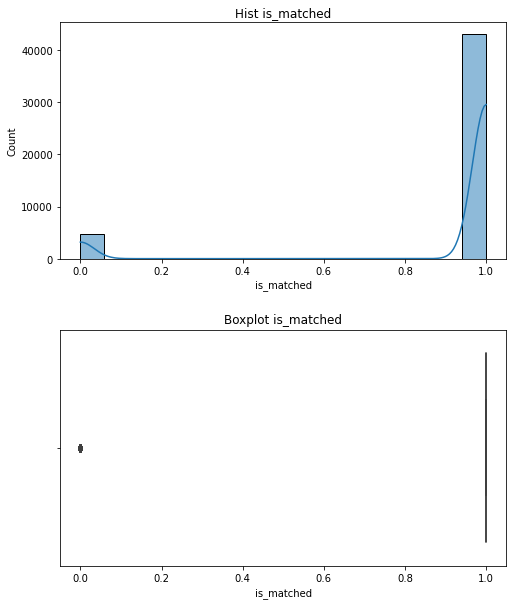

col_name  corr_target assumed_var_type omnibus_k2 omnibus_pstat  \
0  word_count    -0.032873       continuous       None          None   
1  is_matched    -0.059093      categorical       None          None   

  is_normal  uniques        mean  median  
0      None      NaN  974.637216   936.0  
1      None      2.0         NaN     NaN

In [619]:
eda.explore_data_cont(to_explore, df, 'likes_loves', hist=True, box=True, 
                      plot_v_target=False,
                 summarize=True, norm_check=False)

Looks like photos get the most likes, videos get the second highest number of likes.

## Correlation between engagement metrics

In [620]:
corr = df[['shares_count', 'comments_count', 'likes_loves']].corr()
corr

shares_count  comments_count  likes_loves
shares_count        1.000000        0.303432     0.584613
comments_count      0.303432        1.000000     0.294156
likes_loves         0.584613        0.294156     1.000000

OK, so Likes/Loves and Shares are decently correlated, at 0.58. Comments and Shares and Comments and Likes/Loves are each pretty weakly correlated, at about 0.3.

I would say in general that the factors that generate high amounts of comments are probably different than the factors that generate high amounts of likes/loves and shares. I could hypothesize that people like or love AND share something when they support it, but they may comment on something that they have a negative opinion of.

## Engineer target for All Posts

### Try > 75th percentile as binary target

In [621]:
# populate the percentiles for each engagement metric
df['comments_pct'] = df['comments_count'].rank(pct=True)
df['shares_pct'] = df['shares_count'].rank(pct=True)
df['likesloves_pct'] = df['likes_loves'].rank(pct=True)

df['max_pct'] = df[['comments_pct', 'shares_pct', 'likesloves_pct']]\
        .max(axis=1)
df['mean_pct'] = df[['comments_pct', 'shares_pct', 'likesloves_pct']]\
        .mean(axis=1)

In [622]:
# Create column indicating high engagement in any category
df.loc[df['mean_pct'] > 0.75, 'all_binary'] = 1

# populate null values with 0
df.loc[df['all_binary'].isna(), 'all_binary'] = 0

df['all_binary'].value_counts()

0.0    37584
1.0    10282
Name: all_binary, dtype: int64

In [623]:
df['all_binary'].value_counts(1)

0.0    0.785192
1.0    0.214808
Name: all_binary, dtype: float64

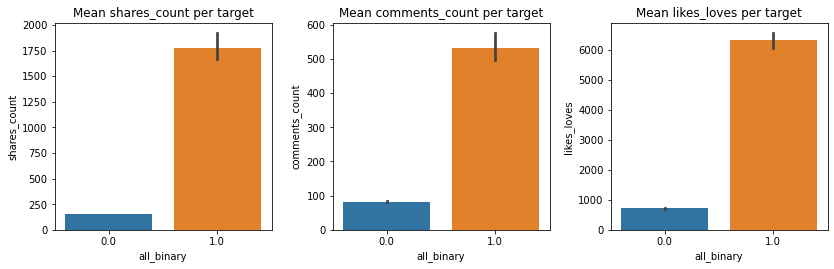

In [624]:
# plot mean per target for each engagement type

fig, axes = plt.subplots(figsize=(12, 4), nrows=1, ncols=3)
plt.tight_layout(pad=3)

for i, target in enumerate(['shares_count', 'comments_count', 'likes_loves']):
    sns.barplot(data=df, y=target, x='all_binary', ax=axes[i], 
                estimator=np.mean)
    axes[i].set_title(f"Mean {target} per target")

In [625]:
# plot median per target for each engagement type

fig, axes = plt.subplots(figsize=(12, 4), nrows=1, ncols=3)
plt.tight_layout(pad=3)

for i, target in enumerate(['shares_count', 'comments_count', 'likes_loves']):
    sns.barplot(data=df, y=target, x='all_binary', ax=axes[i], 
                estimator=np.median)
    axes[i].set_title(f"Median {target} per target")

The binary target I have engineered shows that both mean and median of the binary target category are significantly higher than the mean/median of the rest of posts in all three engagement metrics.

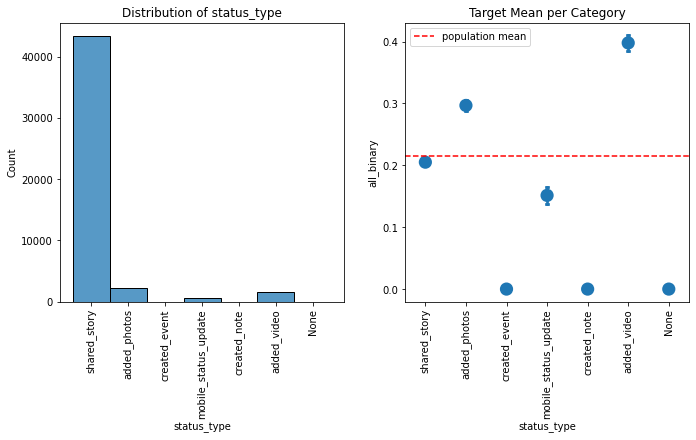

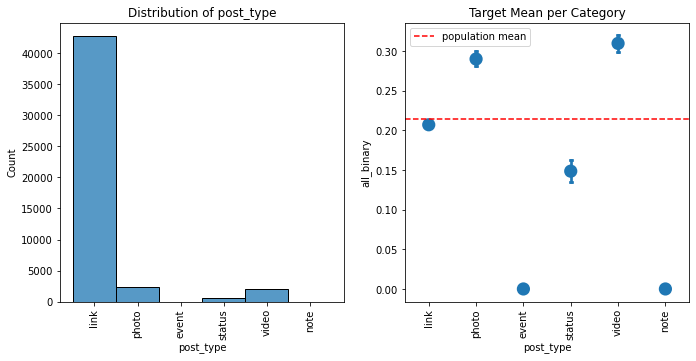

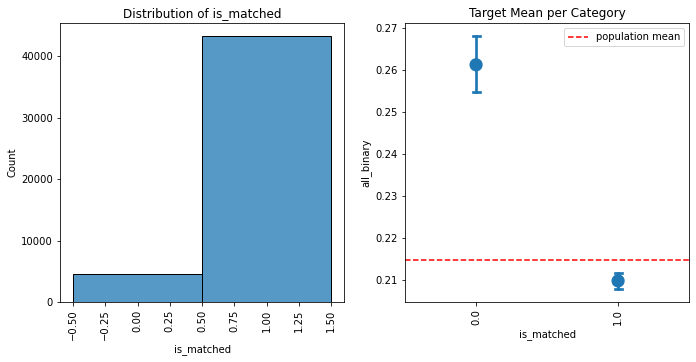

In [626]:
# Explore categorical variables' relationship to the new binary target
to_explore = ['status_type', 'post_type', 'news_desk', 'section_name', 
              'type_of_material', 'is_matched']
eda.explore_data_catbin(to_explore, df, 'all_binary')

### Multi-class target

Initially, I tried a binary target where `high engagement` was anything over the 75th percentile, and `average engagement` was everything else. However, the best models were only about 67% accurate on both classes.

I wondered if a multi-class problem might perform better. 

Based on where the percentiles fall on the distributions, I think it should be:
- Average = less than 25th percentile
- Moderate = 25th to 75th percentile
- High = Over 75th percentile

In [627]:
# Create column indicating outlier engagement in any category

# high, over 75th percentile
df.loc[df['mean_pct'] > 0.75, 'all_multi'] = 2

# low, under 25th percentile
df.loc[df['mean_pct'] < 0.25, 'all_multi'] = 0

# The rest, 25th to 50th percentile, are moderate
df.loc[df['all_multi'].isna(), 'all_multi'] = 1

df['all_multi'].value_counts(1)

1.0    0.571805
2.0    0.214808
0.0    0.213387
Name: all_multi, dtype: float64

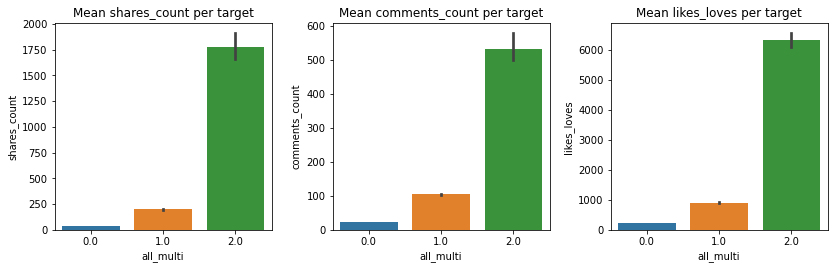

In [628]:
fig, axes = plt.subplots(figsize=(12, 4), nrows=1, ncols=3)
plt.tight_layout(pad=3)

for i, target in enumerate(['shares_count', 'comments_count', 'likes_loves']):
    sns.barplot(data=df, y=target, x='all_multi', ax=axes[i], 
                estimator=np.mean)
    axes[i].set_title(f"Mean {target} per target")

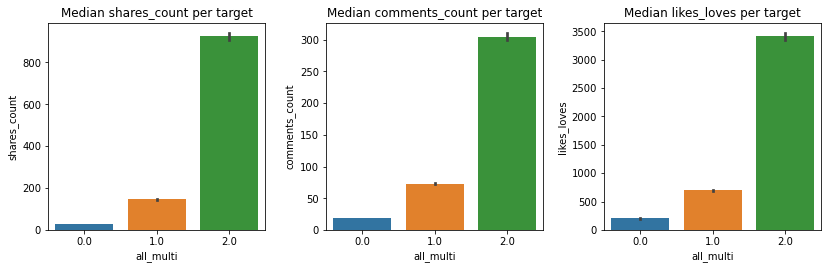

In [629]:
fig, axes = plt.subplots(figsize=(12, 4), nrows=1, ncols=3)
plt.tight_layout(pad=3)

for i, target in enumerate(['shares_count', 'comments_count', 'likes_loves']):
    sns.barplot(data=df, y=target, x='all_multi', ax=axes[i], 
                estimator=np.median)
    axes[i].set_title(f"Median {target} per target")

## Engineer target only for matched articles

### Try > 75th percentile as binary target

In [630]:
df.loc[df['is_matched']==0, 'mean_pct'].describe()

count    4639.000000
mean        0.509587
std         0.283270
min         0.002197
25%         0.262620
50%         0.511184
75%         0.760822
max         0.999756
Name: mean_pct, dtype: float64

In [631]:
df.loc[df['is_matched']==1, 'mean_pct'].describe()

count    43227.000000
mean         0.498983
std          0.260594
min          0.002490
25%          0.284825
50%          0.496574
75%          0.714274
max          0.999979
Name: mean_pct, dtype: float64

In [632]:
# populate the percentiles for each engagement metric
df.loc[df['is_matched']==1, 'comments_pct_m'] = \
    df.loc[df['is_matched']==1, 'comments_count'].rank(pct=True)

df.loc[df['is_matched']==1, 'shares_pct_m'] = \
    df.loc[df['is_matched']==1, 'shares_count'].rank(pct=True)

df.loc[df['is_matched']==1, 'likesloves_pct_m'] = \
    df.loc[df['is_matched']==1, 'likes_loves'].rank(pct=True)


df['max_pct_m'] = df[['comments_pct_m', 'shares_pct_m', 
    'likesloves_pct_m']].max(axis=1)
df['mean_pct_m'] = df[['comments_pct_m', 'shares_pct_m', 
    'likesloves_pct_m']].mean(axis=1)

In [633]:
# Create column indicating high engagement in any category
df.loc[df['mean_pct_m'] > 0.75, 'm_binary'] = 1

# populate null values with 0
df.loc[df['m_binary'].isna(), 'm_binary'] = 0

df['m_binary'].value_counts(1)

0.0    0.805687
1.0    0.194313
Name: m_binary, dtype: float64

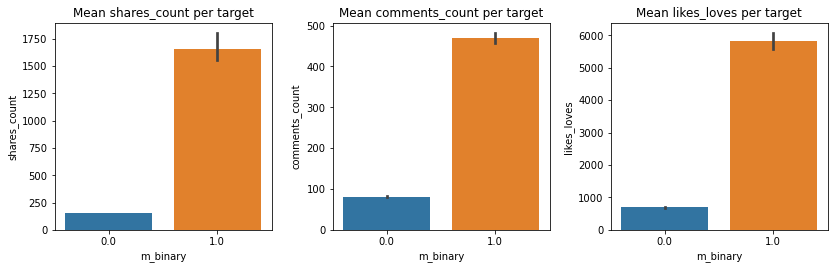

In [634]:
# plot mean per target for each engagement type

fig, axes = plt.subplots(figsize=(12, 4), nrows=1, ncols=3)
plt.tight_layout(pad=3)

for i, target in enumerate(['shares_count', 'comments_count', 'likes_loves']):
    sns.barplot(data=df.loc[df['is_matched']==1], y=target, x='m_binary', 
                ax=axes[i], estimator=np.mean)
    axes[i].set_title(f"Mean {target} per target")

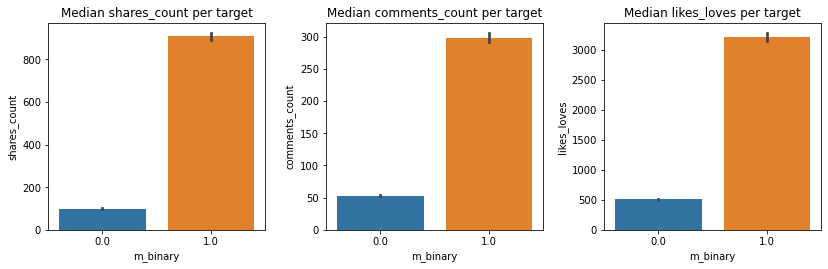

In [635]:
# plot median per target for each engagement type

fig, axes = plt.subplots(figsize=(12, 4), nrows=1, ncols=3)
plt.tight_layout(pad=3)

for i, target in enumerate(['shares_count', 'comments_count', 'likes_loves']):
    sns.barplot(data=df.loc[df['is_matched']==1], y=target, x='m_binary', 
                ax=axes[i], estimator=np.median)
    axes[i].set_title(f"Median {target} per target")

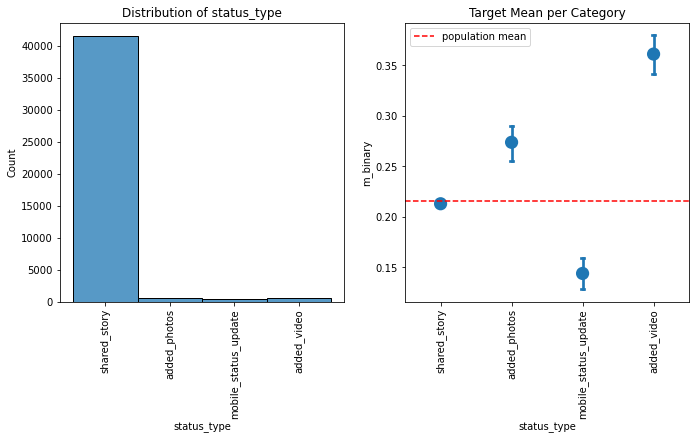

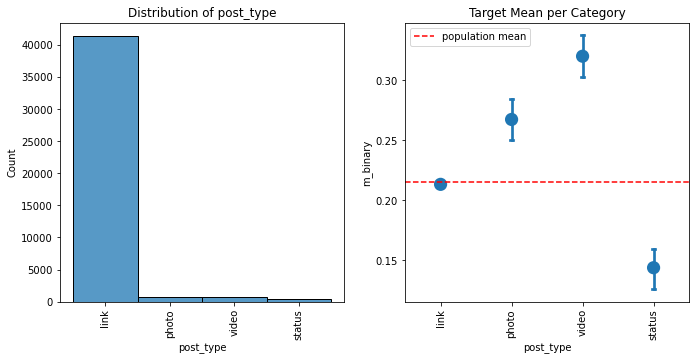

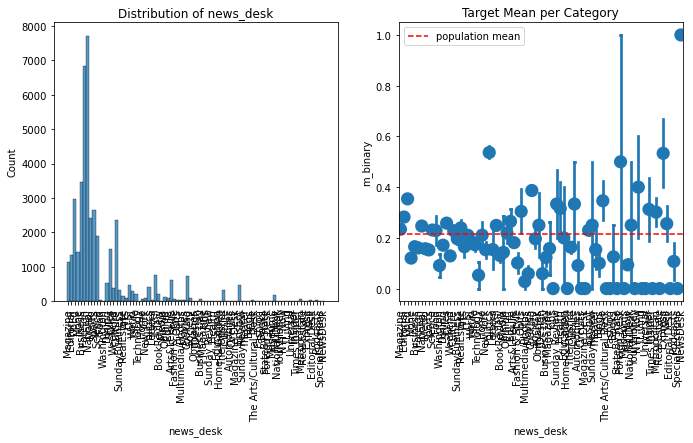

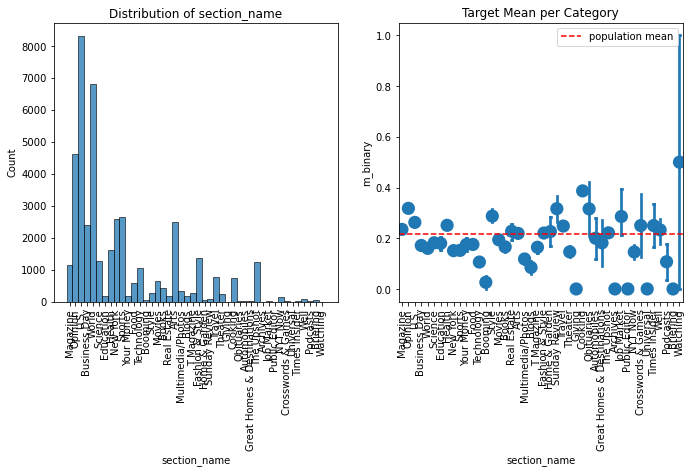

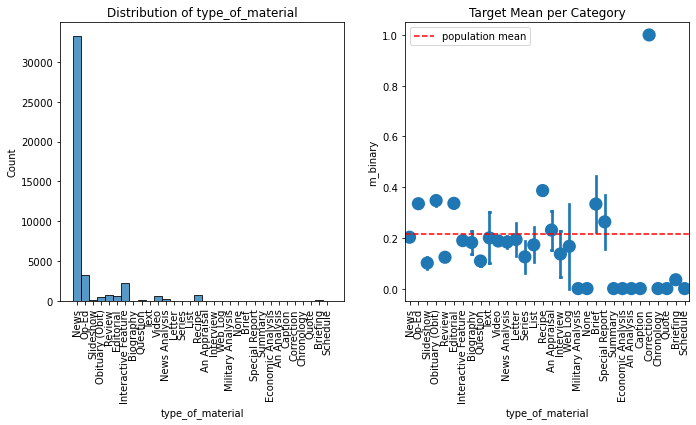

In [636]:
# Explore categorical variables' relationship to the new binary target
to_explore = ['status_type', 'post_type', 'news_desk', 'section_name', 
              'type_of_material']
eda.explore_data_catbin(to_explore, df.loc[df['is_matched']==1], 
                        'm_binary')

### Multi-class target

In [637]:
# Create column indicating outlier engagement in any category

# high, over 75th percentile
df.loc[df['mean_pct_m'] > 0.75, 'm_multi'] = 2

# low, under 25th percentile
df.loc[df['mean_pct_m'] < 0.25, 'm_multi'] = 0

# The rest, 25th to 50th percentile, are moderate
df.loc[df['m_multi'].isna(), 'm_multi'] = 1

df['m_multi'].value_counts(1)

1.0    0.613588
2.0    0.194313
0.0    0.192099
Name: m_multi, dtype: float64

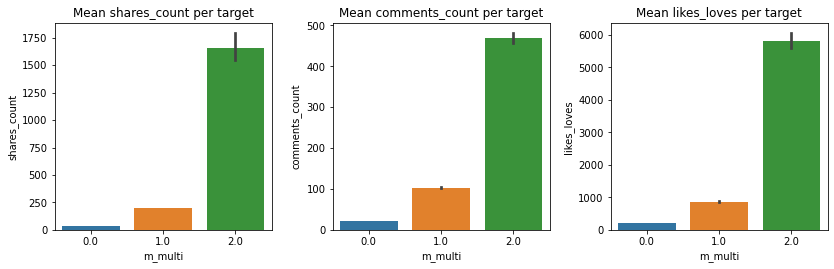

In [638]:
fig, axes = plt.subplots(figsize=(12, 4), nrows=1, ncols=3)
plt.tight_layout(pad=3)

for i, target in enumerate(['shares_count', 'comments_count', 'likes_loves']):
    sns.barplot(data=df.loc[df['is_matched']==1], y=target, 
                x='m_multi', ax=axes[i], estimator=np.mean)
    axes[i].set_title(f"Mean {target} per target")

In [639]:
fig, axes = plt.subplots(figsize=(12, 4), nrows=1, ncols=3)
plt.tight_layout(pad=3)

for i, target in enumerate(['shares_count', 'comments_count', 'likes_loves']):
    sns.barplot(data=df.loc[df['is_matched']==1], y=target, 
                x='m_multi', ax=axes[i], estimator=np.median)
    axes[i].set_title(f"Median {target} per target")

### Engineer Features from Article-Only categorical fields

There are a few fields (`news_desk`, `section_name`, and `type_of_material` that seem to have some overlapping information.

I think I'm going to omit `news_desk`, use `section_name` as-is, and engineer some fields from `type_of_material` indicating whether a piece was interactive or video.

I'd also like to use `word_count`, but need to create categories.

#### Type of Material

In [640]:
df['type_of_material'].value_counts()

News                   33274
Not matched             4639
Op-Ed                   3272
Interactive Feature     2346
Review                   834
Recipe                   740
Editorial                622
Video                    602
Obituary (Obit)          510
News Analysis            289
Question                 193
Briefing                 172
Slideshow                119
Biography                 66
Letter                    31
List                      29
An Appraisal              26
Interview                 22
Special Report            19
Series                    16
Text                      10
Brief                      9
Web Log                    6
None                       5
Summary                    4
Economic Analysis          2
An Analysis                2
Caption                    2
Chronology                 1
Military Analysis          1
Quote                      1
Correction                 1
Schedule                   1
Name: type_of_material, dtype: int64

In [641]:
# Pull out interactive
df.loc[df['type_of_material']=='Interactive Feature', 'is_interactive'] = 1
df.loc[df['is_interactive'].isna(), 'is_interactive'] = 0

# Pull out video
df.loc[df['type_of_material']=='Video', 'is_video'] = 1
df.loc[df['is_video'].isna(), 'is_video'] = 0

# Pull out slideshow
df.loc[df['type_of_material']=='Slideshow', 'is_slideshow'] = 1
df.loc[df['is_slideshow'].isna(), 'is_slideshow'] = 0

#### Word Count

In [642]:
df['word_count'].describe()

count    47866.000000
mean       974.637216
std        938.075061
min          0.000000
25%        452.000000
50%        936.000000
75%       1267.000000
max      18273.000000
Name: word_count, dtype: float64

In [643]:
# get stats for articles that actually have word counts over 0
word_stats = df.loc[df['word_count']>0, 'word_count'].describe()

In [644]:
word_stats

count    39355.000000
mean      1185.414433
std        905.777252
min          1.000000
25%        786.000000
50%       1062.000000
75%       1334.000000
max      18273.000000
Name: word_count, dtype: float64

In [645]:
word_cat_col = 'word_count_cat'

df.loc[df['word_count']==0, word_cat_col] = 'None'
df.loc[(df[word_cat_col].isna()) & (df['word_count'] < word_stats['25%']), 
       word_cat_col] = 'Low'
df.loc[(df[word_cat_col].isna()) & (df['word_count'] < word_stats['75%']), 
       word_cat_col] = 'Average'
df.loc[df[word_cat_col].isna(), word_cat_col] = 'High'

df[word_cat_col].value_counts()

Average    19685
High        9864
Low         9806
None        8511
Name: word_count_cat, dtype: int64

#### Keywords

In [646]:
df['has_person'] = df['persons'].map(lambda x : 1 if type(x)==list else 0)
df['has_org'] = df['organizations'].map(lambda x : 1 if type(x)==list else 0)
df['has_geo'] = df['glocations'].map(lambda x : 1 if type(x)==list else 0)

In [647]:
# Fill nulls with placeholder list
for i in df.loc[df['subject'].isna(), 'subject'].index:
    df.at[i, 'subject'] = ['No Subject']

In [648]:
df['subject'][:5].values

array([list(['automobiles', 'economic conditions and trends', 'american recovery and reinvestment act (2009)', 'presidential election of 2012', 'labor and jobs']),
       list(['weather', 'books and literature', 'hurricanes and tropical storms', 'supercomputers']),
       list(['food', 'organic foods and products', 'medicine and health', 'social conditions and trends']),
       list(['No Subject']),
       list(['medical marijuana', 'marijuana', 'anxiety and stress', 'parenting'])],
      dtype=object)

### Explore Category Relationship to Target

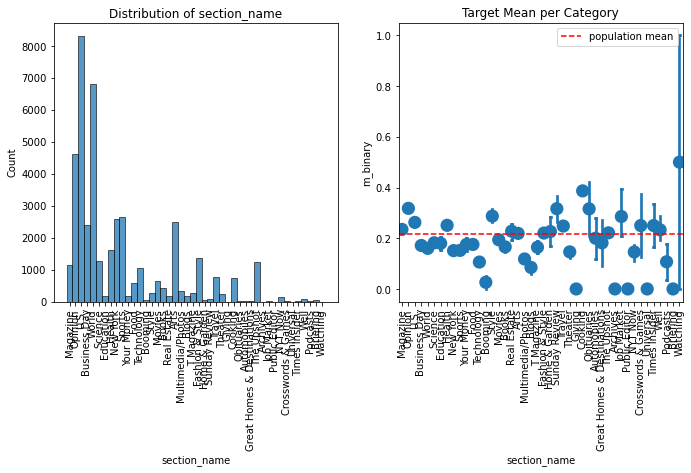

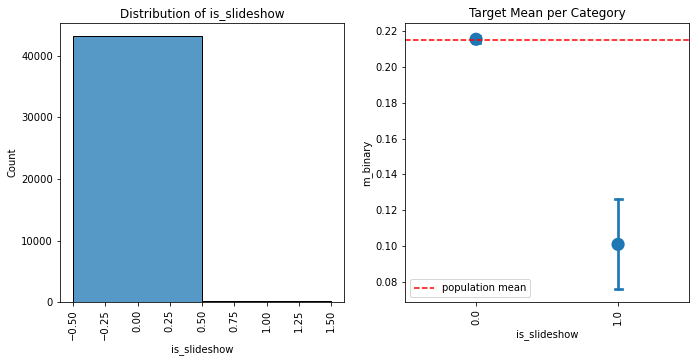

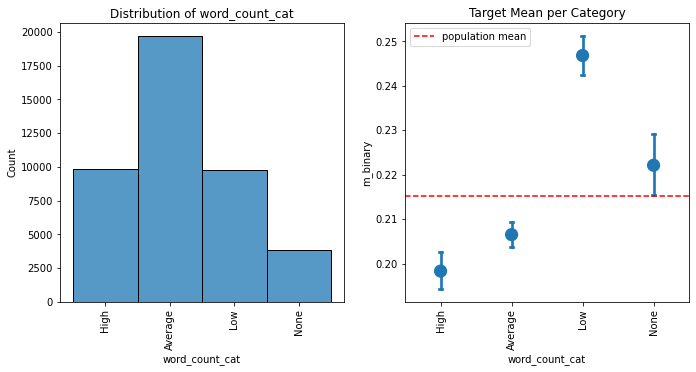

In [649]:
# Explore categorical variables' relationship to the new binary target
to_explore = ['section_name', 'is_interactive', 'is_video', 'is_slideshow', 
              'word_count_cat', 'has_person', 'has_org', 'has_geo']
eda.explore_data_catbin(to_explore, df.loc[df['is_matched']==1], 
                        'm_binary')

I'm realizing that not many of the articles are classified as interactive, videos, or a slideshow. I'm not sure I'll end up using them.

In [650]:
# create a single column for 'is_interactive', 'is_video', 'is_slideshow'
df.loc[(df['is_interactive']==1) | (df['is_video']==1) | 
       (df['is_slideshow']==1), 'is_multimedia'] = 1

df.loc[(df['is_multimedia'].isna()), 'is_multimedia'] = 0

df['is_multimedia'].value_counts()

0.0    44799
1.0     3067
Name: is_multimedia, dtype: int64

In [651]:
eda.explore_data_catbin(['is_multimedia'], df.loc[df['is_matched']==1], 
                        'm_binary')

In [652]:
df.loc[(df['is_matched']==1) & (df['is_multimedia']==1), 
       'post_type'].value_counts(1)

link      0.822954
video     0.093251
photo     0.070427
status    0.013368
Name: post_type, dtype: float64

In [653]:
df.loc[(df['is_matched']==1) & (df['is_multimedia']==0), 
       'post_type'].value_counts(1)

link      0.967455
video     0.011479
photo     0.010832
status    0.010234
Name: post_type, dtype: float64

82% of the articles that are multimedia were posted to Facebook as links, as opposed to uploaded as videos or photos to Facebook itself.

## Explore Dates

### Timezone

Post ID `5281959998_10150952237769999` [here](https://www.facebook.com/nytimes/posts/10150952237769999) says it was posted on November 3, 2016 at 7:03 AM Eastern (on my laptop), but the timestamp in the CSV says 11:03 AM.

4 hours ahead on November 3, 2016 is just before daylight savings time ended, so Eastern was 4 hours behind GMT. I think the time stamps are in GMT.

In [654]:
# convert posted_at to datetime and set it as index
df['posted_at'] = pd.to_datetime(df['posted_at'])
df.set_index(['posted_at'], drop=False, inplace=True)

In [655]:
# make index time zone aware in UTC
df.index = df.index.tz_localize('UTC')

In [656]:
# convert time stamps to Eastern time
df.index = df.index.tz_convert('US/Eastern')

In [657]:
# check and see, is the example I used before in the right time zone now
df.loc[df['id']=='5281959998_10150952237769999']

id      caption  \
posted_at                                                              
2016-11-03 07:03:02-04:00  5281959998_10150952237769999  nytimes.com   

                          post_type   status_type  comments_count  \
posted_at                                                           
2016-11-03 07:03:02-04:00      link  shared_story             634   

                           shares_count  \
posted_at                                 
2016-11-03 07:03:02-04:00           628   

                                                                        link  \
posted_at                                                                      
2016-11-03 07:03:02-04:00  http://www.nytimes.com/2016/11/04/us/politics/...   

                                    posted_at print_section print_page  ...  \
posted_at                                                               ...   
2016-11-03 07:03:02-04:00 2016-11-03 11:03:02             A          1  ...   

                          m_binary m_multi is_interactive is_video  \
posted_at                                                            
2016-11-03 07:03:02-04:00      1.0     2.0            0.0      0.0   

                          is_slideshow word_count_cat  has_person has_org  \
posted_at                                                                   
2016-11-03 07:03:02-04:00          0.0        Average           1       1   

                          has_geo is_multimedia  
posted_at                                        
2016-11-03 07:03:02-04:00       0           0.0  

[1 rows x 50 columns]

In [658]:
# separate out months, days of the week, hours of the day (in 24-hour time)
# and year
# https://pandas.pydata.org/docs/reference/api/pandas.Timestamp.html
df['day_name'] = df.index.day_name()
df['month'] = df.index.month_name()
df['hour'] = df.index.hour
df['year'] = df.index.year

In [659]:
df[['month', 'day_name', 'hour', 'year']]

month  day_name  hour  year
posted_at                                                 
2012-09-08 11:16:55-04:00  September  Saturday    11  2012
2012-09-08 12:01:13-04:00  September  Saturday    12  2012
2012-09-08 12:44:02-04:00  September  Saturday    12  2012
2012-09-08 13:32:18-04:00  September  Saturday    13  2012
2012-09-08 15:14:51-04:00  September  Saturday    15  2012
...                              ...       ...   ...   ...
2016-11-07 17:40:27-05:00   November    Monday    17  2016
2016-11-07 17:55:00-05:00   November    Monday    17  2016
2016-11-07 18:26:25-05:00   November    Monday    18  2016
2016-11-07 18:40:00-05:00   November    Monday    18  2016
2016-11-07 18:55:00-05:00   November    Monday    18  2016

[47866 rows x 4 columns]

If I graph all of the data, it includes only a few months of 2012, which have lower volume than later years. 

Selecting everything after 2012 to use for visualization, so the graphs are easier to read. When I initially included everything, 2012 volumes were pretty low and consistent.

In [660]:
df_no2012 = df.loc['2013-01-01':]
df_no2012.head()

id      caption  \
posted_at                                                              
2013-01-01 10:12:36-05:00    5281959998_128572180638748  nytimes.com   
2013-01-01 11:29:39-05:00    5281959998_408744032538068  nytimes.com   
2013-01-01 12:04:50-05:00  5281959998_10150274076714999         None   
2013-01-01 21:32:08-05:00    5281959998_576458589046743  nytimes.com   
2013-01-01 23:21:59-05:00    5281959998_407806775965238  nytimes.com   

                          post_type   status_type  comments_count  \
posted_at                                                           
2013-01-01 10:12:36-05:00      link  shared_story              86   
2013-01-01 11:29:39-05:00      link  shared_story              34   
2013-01-01 12:04:50-05:00     photo  added_photos              33   
2013-01-01 21:32:08-05:00      link  shared_story              13   
2013-01-01 23:21:59-05:00      link  shared_story             103   

                           shares_count  \
posted_at                                 
2013-01-01 10:12:36-05:00           132   
2013-01-01 11:29:39-05:00            31   
2013-01-01 12:04:50-05:00           197   
2013-01-01 21:32:08-05:00            54   
2013-01-01 23:21:59-05:00           281   

                                                                        link  \
posted_at                                                                      
2013-01-01 10:12:36-05:00  http://www.nytimes.com/2013/01/02/us/politics/...   
2013-01-01 11:29:39-05:00  http://www.nytimes.com/2013/01/01/world/asia/f...   
2013-01-01 12:04:50-05:00  https://www.facebook.com/nytimes/photos/a.2835...   
2013-01-01 21:32:08-05:00  http://www.nytimes.com/interactive/2012/12/30/...   
2013-01-01 23:21:59-05:00  http://www.nytimes.com/2013/01/02/us/politics/...   

                                    posted_at print_section   print_page  ...  \
posted_at                                                                 ...   
2013-01-01 10:12:36-05:00 2013-01-01 15:12:36          None         None  ...   
2013-01-01 11:29:39-05:00 2013-01-01 16:29:39             A            1  ...   
2013-01-01 12:04:50-05:00 2013-01-01 17:04:50   Not matched  Not matched  ...   
2013-01-01 21:32:08-05:00 2013-01-02 02:32:08          None         None  ...   
2013-01-01 23:21:59-05:00 2013-01-02 04:21:59             A            1  ...   

                          is_slideshow word_count_cat has_person has_org  \
posted_at                                                                  
2013-01-01 10:12:36-05:00          0.0           High          1       1   
2013-01-01 11:29:39-05:00          0.0        Average          1       0   
2013-01-01 12:04:50-05:00          0.0           None          0       0   
2013-01-01 21:32:08-05:00          0.0           None          0       0   
2013-01-01 23:21:59-05:00          0.0        Average          1       1   

                          has_geo is_multimedia  day_name    month hour  year  
posted_at                                                                      
2013-01-01 10:12:36-05:00       0           0.0   Tuesday  January   10  2013  
2013-01-01 11:29:39-05:00       1           0.0   Tuesday  January   11  2013  
2013-01-01 12:04:50-05:00       0           0.0   Tuesday  January   12  2013  
2013-01-01 21:32:08-05:00       0           1.0   Tuesday  January   21  2013  
2013-01-01 23:21:59-05:00       0           0.0   Tuesday  January   23  2013  

[5 rows x 54 columns]

In [661]:
def plot_posts_per_time(df, x_col):
    """Create histogram for count of posts per specified x_col. 
    Uses year as hue by default.
    """
    
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.histplot(data=df, x=x_col, hue='year', multiple='dodge', 
                 palette='tab10', )
    ax.set_title(f"Count of Facebook Posts per {x_col.title()} and Year")
    for tick in ax.get_xticklabels():
        tick.set_rotation(45);

### Histograms

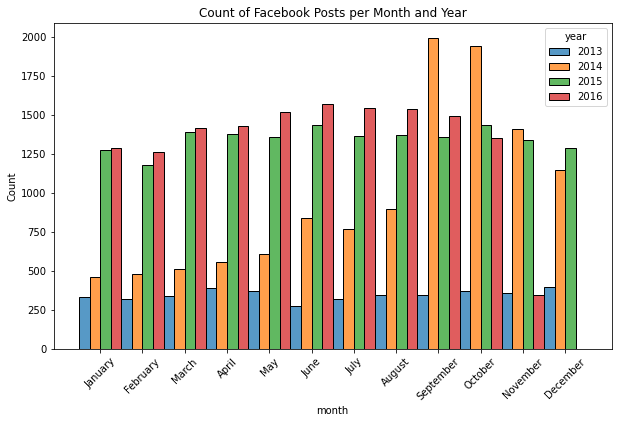

In [662]:
plot_posts_per_time(df_no2012, 'month')

The Times posted about 300-350 posts per month from the end of 2012 through 2013.

In 2014, number of posts started ramping up, hitting an all-time high of 1800-1900 per month in September and October.

After that, number of posts per month settled in at about 1300-1500 per month from the end of 2014. I believe November 2016 is a partial month, so the November count looks smaller than it probably actually was.

In [663]:
df.tail()

id      caption  \
posted_at                                                              
2016-11-07 17:40:27-05:00  5281959998_10150958194759999  nytimes.com   
2016-11-07 17:55:00-05:00  5281959998_10150958250414999  nytimes.com   
2016-11-07 18:26:25-05:00  5281959998_10150958439909999  nytimes.com   
2016-11-07 18:40:00-05:00  5281959998_10150958425294999  nytimes.com   
2016-11-07 18:55:00-05:00  5281959998_10150958224029999  nytimes.com   

                          post_type   status_type  comments_count  \
posted_at                                                           
2016-11-07 17:40:27-05:00      link  shared_story              37   
2016-11-07 17:55:00-05:00      link  shared_story             621   
2016-11-07 18:26:25-05:00      link  shared_story             776   
2016-11-07 18:40:00-05:00      link  shared_story             428   
2016-11-07 18:55:00-05:00      link  shared_story             183   

                           shares_count  \
posted_at                                 
2016-11-07 17:40:27-05:00            40   
2016-11-07 17:55:00-05:00           465   
2016-11-07 18:26:25-05:00          4286   
2016-11-07 18:40:00-05:00           503   
2016-11-07 18:55:00-05:00          3283   

                                                                        link  \
posted_at                                                                      
2016-11-07 17:40:27-05:00  http://www.nytimes.com/2016/11/06/arts/televis...   
2016-11-07 17:55:00-05:00  http://www.nytimes.com/2016/11/07/opinion/camp...   
2016-11-07 18:26:25-05:00  http://www.nytimes.com/2016/11/08/upshot/this-...   
2016-11-07 18:40:00-05:00  http://www.nytimes.com/watching/recommendation...   
2016-11-07 18:55:00-05:00  http://www.nytimes.com/2016/11/07/opinion/camp...   

                                    posted_at print_section   print_page  ...  \
posted_at                                                                 ...   
2016-11-07 17:40:27-05:00 2016-11-07 22:40:27          None         None  ...   
2016-11-07 17:55:00-05:00 2016-11-07 22:55:00          None         None  ...   
2016-11-07 18:26:25-05:00 2016-11-07 23:26:25             P            4  ...   
2016-11-07 18:40:00-05:00 2016-11-07 23:40:00   Not matched  Not matched  ...   
2016-11-07 18:55:00-05:00 2016-11-07 23:55:00             A           19  ...   

                          is_slideshow word_count_cat has_person has_org  \
posted_at                                                                  
2016-11-07 17:40:27-05:00          0.0        Average          0       0   
2016-11-07 17:55:00-05:00          0.0        Average          1       0   
2016-11-07 18:26:25-05:00          0.0        Average          1       0   
2016-11-07 18:40:00-05:00          0.0           None          0       0   
2016-11-07 18:55:00-05:00          0.0        Average          1       0   

                          has_geo is_multimedia  day_name     month hour  year  
posted_at                                                                       
2016-11-07 17:40:27-05:00       0           0.0    Monday  November   17  2016  
2016-11-07 17:55:00-05:00       0           0.0    Monday  November   17  2016  
2016-11-07 18:26:25-05:00       1           0.0    Monday  November   18  2016  
2016-11-07 18:40:00-05:00       0           0.0    Monday  November   18  2016  
2016-11-07 18:55:00-05:00       0           0.0    Monday  November   18  2016  

[5 rows x 54 columns]

Yes, it only goes until November 7, 2016.

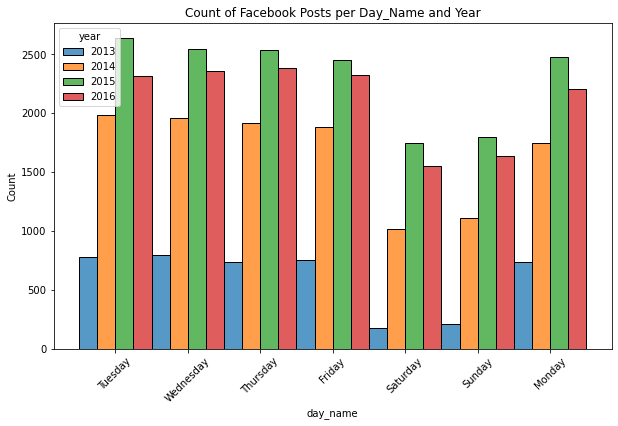

In [664]:
plot_posts_per_time(df_no2012, 'day_name')

The Times releases more posts during the week (particularly Tuesday through Friday) than it does on the weekend.

The difference in number of weekday posts compared to number of weekend posts seems to narrow as time goes on.

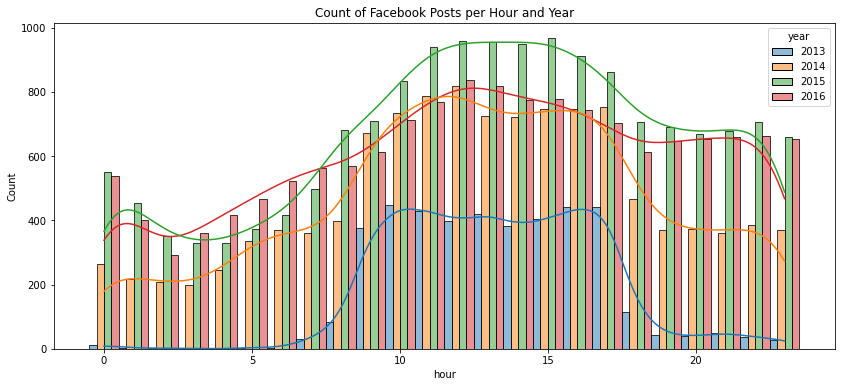

In [665]:
fig, ax = plt.subplots(figsize=(14, 6))
sns.histplot(data=df_no2012, x='hour', hue='year', multiple='dodge', 
             palette='tab10', discrete=True, kde=True)
ax.set_title(f"Count of Facebook Posts per Hour and Year");

In 2013, posts mostly went up from around 9 AM to 5 PM Eastern, with very few outside normal working hours.

9-5 continues to be the heaviest time for new posts through 2016, although more posts start to be added in off-hours so there's less of a difference.



### Shares, Comments, and Likes per Time Freq

Check for seasonality of number of comments, shares, or likes based on different time frequencies across multiple years.

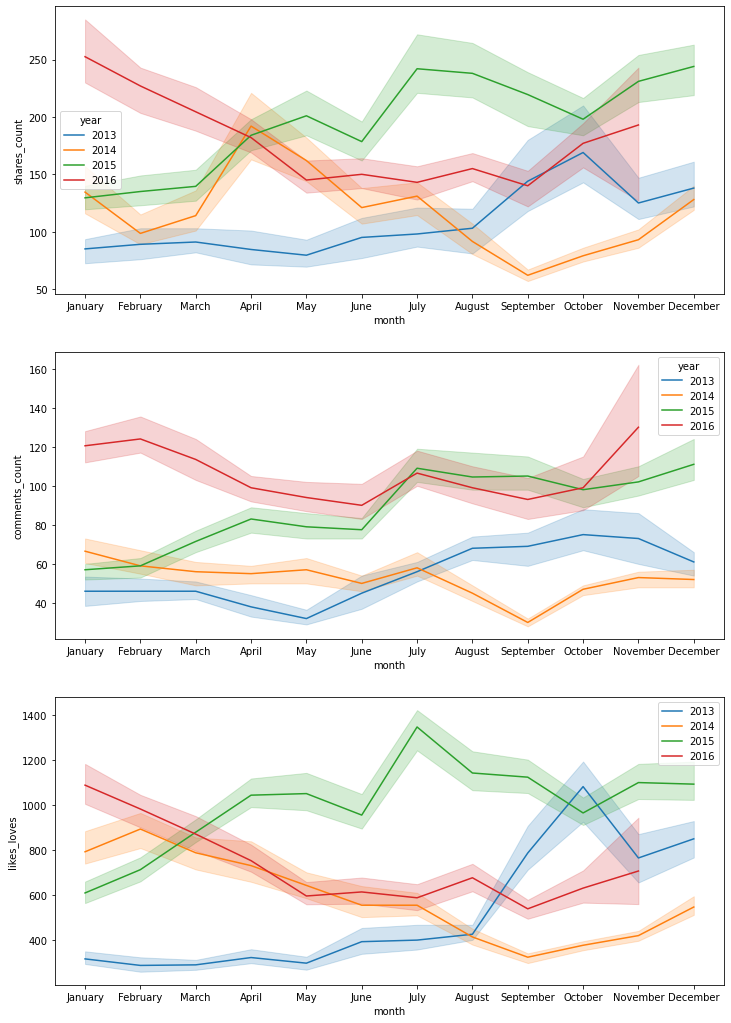

In [666]:
fig, [ax1,ax2,ax3] = plt.subplots(nrows=3, ncols=1, figsize=(12, 18))
sns.lineplot(data=df_no2012, x='month', y='shares_count', ax=ax1,
            hue='year', palette='tab10', estimator=np.median)
sns.lineplot(data=df_no2012, x='month', y='comments_count', ax=ax2,
            hue='year', palette='tab10', estimator=np.median)
sns.lineplot(data=df_no2012, x='month', y='likes_loves', ax=ax3, 
            hue='year', palette='tab10', estimator=np.median)
plt.legend();

In [667]:
fig, [ax1,ax2,ax3] = plt.subplots(nrows=3, ncols=1, figsize=(12, 18))
sns.lineplot(data=df_no2012, x='hour', y='shares_count', ax=ax1,
            hue='year', palette='tab10', estimator=np.median)
sns.lineplot(data=df_no2012, x='hour', y='comments_count', ax=ax2,
            hue='year', palette='tab10', estimator=np.median)
sns.lineplot(data=df_no2012, x='hour', y='likes_loves', ax=ax3, 
            hue='year', palette='tab10', estimator=np.median)
plt.legend();

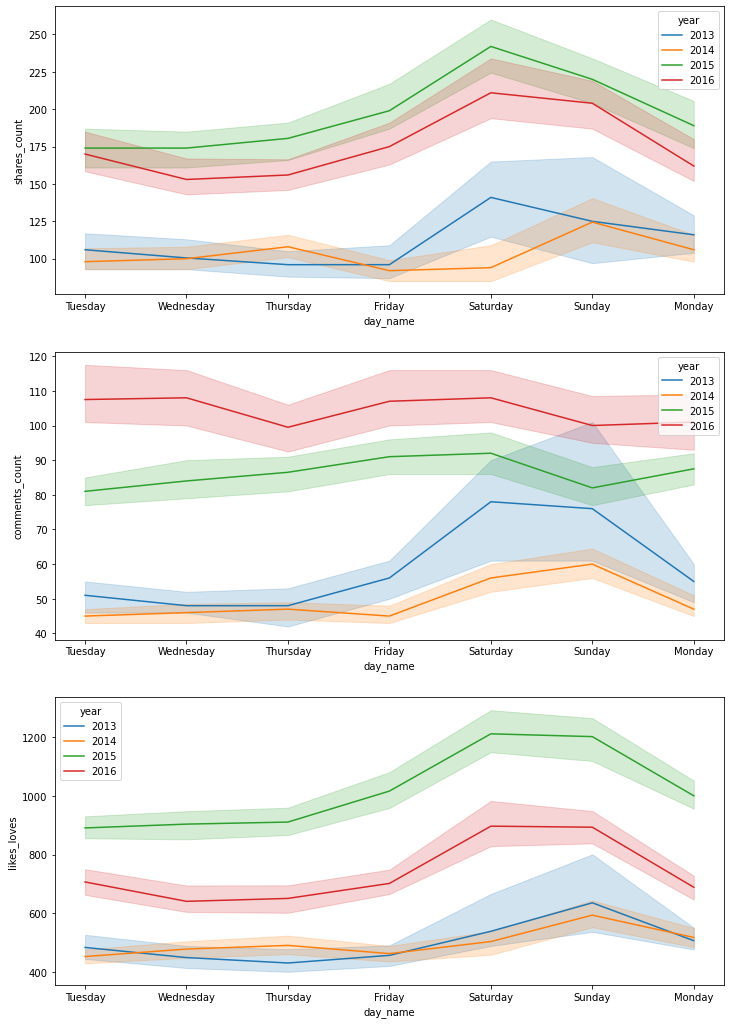

In [668]:
fig, [ax1,ax2,ax3] = plt.subplots(nrows=3, ncols=1, figsize=(12, 18))
sns.lineplot(data=df_no2012, x='day_name', y='shares_count', ax=ax1,
            hue='year', palette='tab10', estimator=np.median)
sns.lineplot(data=df_no2012, x='day_name', y='comments_count', ax=ax2,
            hue='year', palette='tab10', estimator=np.median)
sns.lineplot(data=df_no2012, x='day_name', y='likes_loves', ax=ax3, 
            hue='year', palette='tab10', estimator=np.median);

- Busiest months seem to vary year by year, so I'm thinking there isn't any seasonality to activity, it's just based on what might be happening in any given month.
- People seem to interact with posts sightly more frequently when they're added in the evening hours. There are also slight increases in the morning.
- Posts added on Friday, Sunday, and Wednesday seemed to get the most engagement in years prior to 2016. In 2016 it's mostly the same, but Tuesday is more popular than Wednesday.

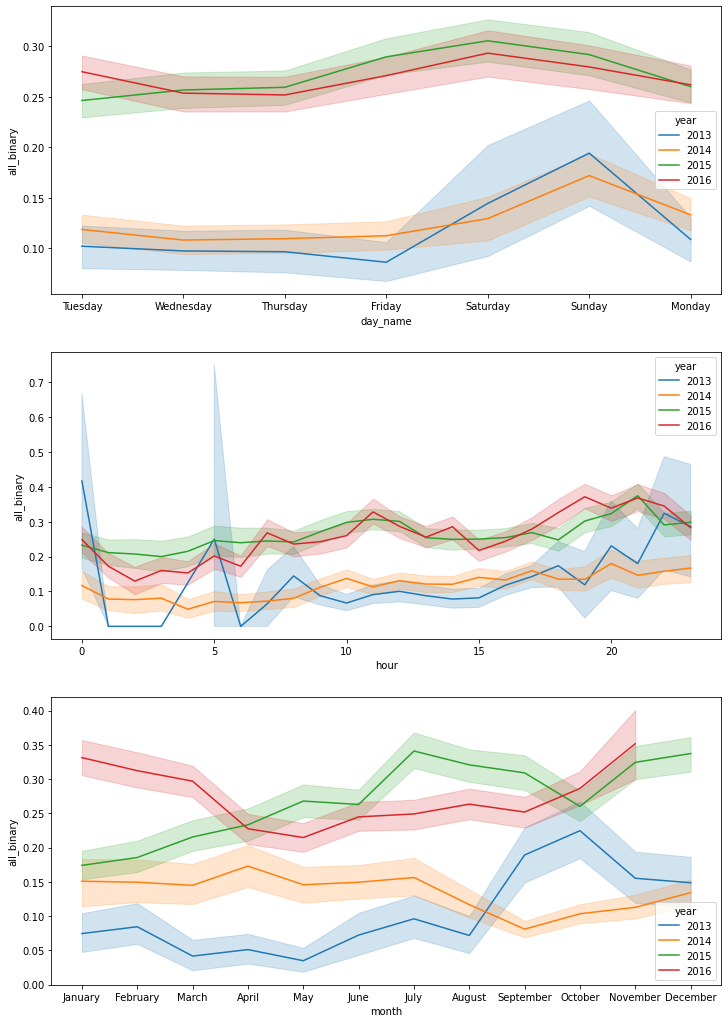

In [669]:
# plotting the binary target on the y-axis, we're getting the mean.
# 21.5% are high

fig, [ax1,ax2,ax3] = plt.subplots(nrows=3, ncols=1, figsize=(12, 18))
sns.lineplot(data=df_no2012, x='day_name', y='all_binary', ax=ax1,
            hue='year', palette='tab10')
sns.lineplot(data=df_no2012, x='hour', y='all_binary', ax=ax2,
            hue='year', palette='tab10')
sns.lineplot(data=df_no2012, x='month', y='all_binary', ax=ax3,
            hue='year', palette='tab10');

Posts made on the weekend seem to get somewhat more engagement than during the week.

There also look to be some spikes for posts added in the morning and the evening versus mid-day.

I don't see much of a pattern per month posted; I think it just depends what newsworthy things are happening in a given month in a given year.

### Create hour category

I would like to engineer a feature for time of day when a post was made, in Eastern time.

- Morning = 7 AM - 11 AM
- Midday = 11 AM - 3 PM
- Afternoon = 3 PM - 7 PM
- Evening = 7 PM - 11 PM
- Late night = 11 PM - 3 AM
- Early morning = 3 AM - 7 AM

In [670]:
df.loc[(7 <= df['hour']) & (df['hour'] < 11), 'hour_cat'] = '2_Morning (7-11)'
df.loc[(11 <= df['hour']) & (df['hour'] < 15), 'hour_cat'] = '3_Midday (11-15)'
df.loc[(15 <= df['hour']) & (df['hour'] < 19), 'hour_cat'] = '4_Afternoon (15-19)'
df.loc[(19 <= df['hour']) & (df['hour'] < 23), 'hour_cat'] = '5_Evening (19-23)'
df.loc[(23 <= df['hour']) | (df['hour'] < 3), 'hour_cat'] = '6_Late night (23-3)'
df.loc[(3 <= df['hour']) & (df['hour'] < 7), 'hour_cat'] = '1_Early morning (3-7)'

In [671]:
df['hour_cat'].value_counts()

3_Midday (11-15)         12078
4_Afternoon (15-19)      10702
2_Morning (7-11)          8572
5_Evening (19-23)         7099
6_Late night (23-3)       5039
1_Early morning (3-7)     4376
Name: hour_cat, dtype: int64

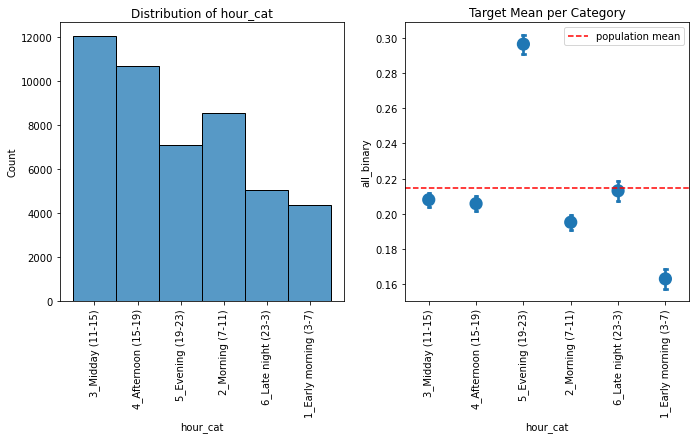

In [672]:
eda.explore_data_catbin(['hour_cat'], df, 'all_binary')

### Create Weekend category

In [673]:
df.loc[df['day_name'].isin(['Saturday', 'Sunday']), 
       'on_weekend'] = 1

df.loc[df['on_weekend'].isna(), 'on_weekend'] = 0

df['on_weekend'].value_counts(1)


0.0    0.803284
1.0    0.196716
Name: on_weekend, dtype: float64

## Duplicate Facebook Texts

These represent instances where the same exact message, description, and name were posted more than once, purposefully.

I'm curious whether I will see any patterns in these duplicates; if the first or last instance tends to get more engagement, if the time of day or day of the week seems to get more engagement, etc.

In [674]:
df.duplicated(subset=['all_text'], keep='first').sum()

190

In [675]:
def md5_hash(x):
    m = hashlib.md5(bytes(x, 'utf-8'))
    return m.hexdigest()

# hash the text to give it a unique ID that's easily sortable
df['text_hash'] = df['all_text'].map(lambda x: md5_hash(x))

In [676]:
#df.loc[df.duplicated(subset=['text_hash'], keep=False), 
#       ['post_type', 'text_hash', 'comments_count', 'shares_count', 'likes_loves',
#       'all_binary', 'day_name', 'hour']].to_csv('data/Review_Text_dupes.csv')

I exported the duplicates and reviewed them in Google Sheets. I didn't see any patterns that seemed to contribute to one post getting more engagement than other: some seemed to simply be first, some were posted on the weekend versus the weekday, some were posted at different times of day.

## Word Frequencies for Facebook text

### Text Preprocessing

In [677]:
# set index back to numbers
df.reset_index(drop=True, inplace=True)

In [678]:
# back up all_text into cleaned
df['cleaned'] = df['all_text']

In [679]:
# check for links or URLs
df.loc[df['cleaned'].str.contains("http[^ ]+|www\.[^ ]+"), 'cleaned'][:5].values

array(['The Weatherman Is Not a Moron. In 1940, the chance of an American being killed by lightning was about 1 in 400,000. Today it’s 1 in 11 million. This is partly because of changes in living patterns (more of our work is done indoors), but it’s also because better weather forecasts have helped us prepare.Nate Silver takes the long view and finds one area in which our predictions are making extraordinary progress: Weather forecasting. See some extraordinary photos of extreme weather: http://nyti.ms/U1RV8a. In the hocus-pocus realm of predicting the future, weather forecasting is an area of progress. Your own experience may differ.',
       "Timeline Photos. Our special Arts & Leisure section 'The New Season' is now online. Take a look at the upcoming offerings in arts and entertainment below. Are you looking forward to any particular events?Art: http://nyti.ms/TAYvoJClassical: http://nyti.ms/P41kvVDance: http://nyti.ms/Rx3YIhMovies: http://nyti.ms/Ow4dodPop: http://nyti.ms/RoEIJUTe

In [680]:
# map doc cleaning function onto 'cleaned' column
# urls have been replaced with links
df['cleaned'] = df['cleaned'].map(lambda x: nlp_prep.clean_docs(x))

df.loc[df['all_text'].str.contains("http[^ ]+|www\.[^ ]+"), 'cleaned'][:5].values

array(["The Weatherman Is Not a Moron. In 1940, the chance of an American being killed by lightning was about 1 in 400,000. Today it's 1 in 11 million. This is partly because of changes in living patterns (more of our work is done indoors), but it's also because better weather forecasts have helped us prepare.Nate Silver takes the long view and finds one area in which our predictions are making extraordinary progress: Weather forecasting. See some extraordinary photos of extreme weather: In the hocus-pocus realm of predicting the future, weather forecasting is an area of progress. Your own experience may differ.",
       "Timeline Photos. Our special Arts & Leisure section 'The New Season' is now online. Take a look at the upcoming offerings in arts and entertainment below. Are you looking forward to any particular events?Art: Jonathan Bartlett). ",
       'Timeline Photos. During a surprise visit to Gators Dockside bar in Orlando, Florida, President Obama was introduced to a boy who w

In [681]:
# check for non-ASCII characters
df.loc[df['all_text'].str.contains(r"[^\x00-\x7F]+"), ['cleaned', 'all_text']][:5].values

array([["Did Barack Obama Save Ohio?. 'There are several pivotal states Ohio, Florida, Nevada, Virginia where things are slowly turning around. In these states, the real issue may not be who deserves blame for economic ruin but rather who deserves credit for a rebound, and what really causes jobs to come back after they've been lost,' writes Matt Bai. Why the battle to take credit for Ohio's ever-so-slightly above-average economy could swing the presidential election.",
        "Did Barack Obama Save Ohio?. 'There are several pivotal states — Ohio, Florida, Nevada, Virginia — where things are slowly turning around. In these states, the real issue may not be who deserves blame for economic ruin but rather who deserves credit for a rebound, and what really causes jobs to come back after they’ve been lost,' writes Matt Bai.. Why the battle to take credit for Ohio’s ever-so-slightly above-average economy could swing the presidential election."],
       ["The Weatherman Is Not a Moron. In 1

In [682]:
# check for number-only words
df.loc[df['cleaned'].str.contains(r"[$]*[0-9]+[,.:$%0-9]*\b"),
      ['all_text']][:5].values

array([['The Weatherman Is Not a Moron. In 1940, the chance of an American being killed by lightning was about 1 in 400,000. Today it’s 1 in 11 million. This is partly because of changes in living patterns (more of our work is done indoors), but it’s also because better weather forecasts have helped us prepare.Nate Silver takes the long view and finds one area in which our predictions are making extraordinary progress: Weather forecasting. See some extraordinary photos of extreme weather: http://nyti.ms/U1RV8a. In the hocus-pocus realm of predicting the future, weather forecasting is an area of progress. Your own experience may differ.'],
       ["The Organic Fable. 'Organic has long since become an ideology, the romantic back-to-nature obsession of an upper middle class able to afford it and oblivious, in their affluent narcissism, to the challenge of feeding a planet whose population will surge to 9 billion,' writes Op-Ed columnist Roger Cohen.. A study exposes the hype behind a pseu

In [683]:
# remove numbers-only words
df = nlp_prep.pattern_match_in_df(df, doc_col='cleaned', hit_col='_', 
                pattern=r"[$]*[0-9]+[,.:$%0-9]*\b", 
                out_type='none', replace=True)

In [684]:
# check for number-only words again, have they been removed?
df.loc[df['all_text'].str.contains(r"[$]*[0-9]+[,.:$%0-9]*\b"),
      ['all_text', 'cleaned']][:5].values

array([['The Weatherman Is Not a Moron. In 1940, the chance of an American being killed by lightning was about 1 in 400,000. Today it’s 1 in 11 million. This is partly because of changes in living patterns (more of our work is done indoors), but it’s also because better weather forecasts have helped us prepare.Nate Silver takes the long view and finds one area in which our predictions are making extraordinary progress: Weather forecasting. See some extraordinary photos of extreme weather: http://nyti.ms/U1RV8a. In the hocus-pocus realm of predicting the future, weather forecasting is an area of progress. Your own experience may differ.',
        "The Weatherman Is Not a Moron. In , the chance of an American being killed by lightning was about in . Today it's in million. This is partly because of changes in living patterns (more of our work is done indoors), but it's also because better weather forecasts have helped us prepare.Nate Silver takes the long view and finds one area in which 

I also noticed that in some cases the newlines were removed, and there isn't appropriate spacing between the end of the previous sentence and the next one. I'm going to try to replace the end of sentence punctuation that blends together with another word.

In [685]:
df.loc[1, 'cleaned']

"The Weatherman Is Not a Moron. In , the chance of an American being killed by lightning was about in . Today it's in million. This is partly because of changes in living patterns (more of our work is done indoors), but it's also because better weather forecasts have helped us prepare.Nate Silver takes the long view and finds one area in which our predictions are making extraordinary progress: Weather forecasting. See some extraordinary photos of extreme weather: In the hocus-pocus realm of predicting the future, weather forecasting is an area of progress. Your own experience may differ."

In [686]:
def split_sentences(doc):
    # find instances of a sentence-ender followed by a sentence opener
    # capital letter 
    doc = re.sub(r"([?.])([A-Z])", r"\1 \2", doc)
    return doc
    
df['cleaned'] = df['cleaned'].map(lambda x: split_sentences(x))

df.loc[1, 'cleaned']

"The Weatherman Is Not a Moron. In , the chance of an American being killed by lightning was about in . Today it's in million. This is partly because of changes in living patterns (more of our work is done indoors), but it's also because better weather forecasts have helped us prepare. Nate Silver takes the long view and finds one area in which our predictions are making extraordinary progress: Weather forecasting. See some extraordinary photos of extreme weather: In the hocus-pocus realm of predicting the future, weather forecasting is an area of progress. Your own experience may differ."

### Stopwords

In [687]:
# starting with nltk's stopwords list
nltk_stopwords = stopwords.words('english')
nltk_stopwords.sort()
print(nltk_stopwords)

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', 'her', 'here', 'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in', 'into', 'is', 'isn', "isn't", 'it', "it's", 'its', 'itself', 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she', "she's", 'should', "should've", 'shouldn', "shouldn't", 'so', 'some',

In [688]:
import string
punc = list(string.punctuation)
print(punc)

['!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', '{', '|', '}', '~']


### Tokenize - No stopwords or punctuation removed

I'm using a tokenizer function that leverages the TweetTokenizer, as it's something I've used before for Tweet processing. Although these are not tweets, they are short text and may contains @mentions that the TweetTokenizer can take out for us.

In [841]:
# Create a dictionary of tokens with class labels as keys
# removing punctuation only
token_dict = nlp_prep.tokenize_corpus_dict_tweet(df, [0, 1], 
            target_col='all_binary', stop_list=None, verbose=False)
token_dict[0][:5]

['did', 'barack', 'obama', 'save', 'ohio']

In [842]:
# create list of all word frequencies in the corpus
all_tokens = []
[all_tokens.extend(tokens) for tokens in token_dict.values()]

len(all_tokens)


2947718

In [843]:
# get frequency distribution for entire corpus
all_corpus = FreqDist(all_tokens)

corpus_freq_df = pd.DataFrame(all_corpus.most_common(100),
                              columns=['Word','Count'])
corpus_freq_df[:25]

Word   Count
0      .  199867
1    the  143796
2      ,  118178
3      a   75588
4     of   69621
5     to   64697
6     in   59552
7    and   53164
8      '   34618
9    for   27065
10    on   25879
11     "   23390
12    is   23364
13  that   20476
14     :   18691
15  with   15937
16    at   14135
17  from   13353
18    as   13249
19   are   12570
20    it   12314
21    an   11498
22   was   11348
23   new   11181
24     ?   10815

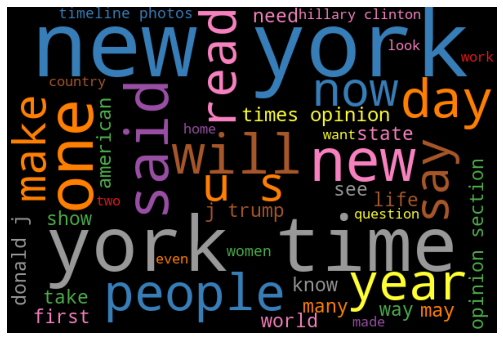

In [692]:
# Wordcloud for most common words in whole corpus, no stopwords
# or punctuation removed
nlp_prep.generate_wordcloud(docs=all_tokens, cmap="Set1", 
                   stopwords=None, min_font_size=16, 
                  title='Entire Corpus')

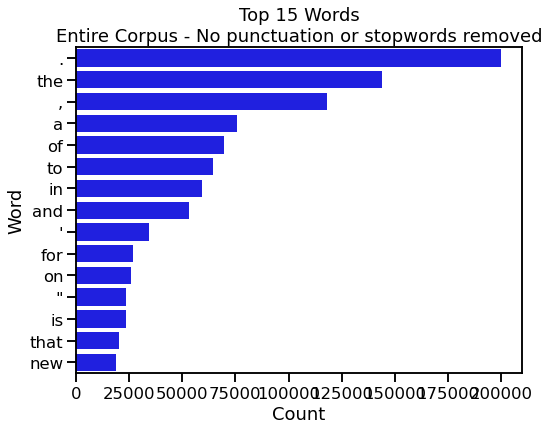

In [693]:
# Plot top 15 words across the entire corpus, no punctuation removed
nlp_prep.plot_wordfreqs(corpus_freq_df, 'Word', 'Count', 15, 
               "Entire Corpus - No punctuation or stopwords removed")

Well perhaps not surprisingly, the words "New York Times" are very common, and the top 15 words are all punctuation and stop words.

Let's take "new york times" out of the text, and try this out with stopwords and punctuation removed.

### Remove "New York Times"

In [694]:
# remove "New York Times"
df = nlp_prep.pattern_match_in_df(df, doc_col='cleaned', hit_col='_', 
                pattern=r"(?:^|\s)([Nn]ew [Yy]ork [Tt]imes)\b", 
                out_type='none', replace=True)

In [695]:
df.loc[df['all_text'].str.contains(r"[Nn]ew [Yy]ork [Tt]imes"), 
       ['all_text', 'cleaned']][:5].values

array([['Timeline Photos. During a surprise visit to Gators Dockside bar in Orlando, Florida, President Obama was introduced to a boy who was born in Hawaii. The president lit up and flashed the Hawaiian shaka hand sign, which the boy — Andre Wupperman, who will be 7 next week — returned. “You have a birth certificate?” the president asked the child. http://nyti.ms/NTb67a (Photo by Doug Mills/The New York Times). ',
        'Timeline Photos. During a surprise visit to Gators Dockside bar in Orlando, Florida, President Obama was introduced to a boy who was born in Hawaii. The president lit up and flashed the Hawaiian shaka hand sign, which the boy Andre Wupperman, who will be next week returned. "You have a birth certificate?" the president asked the child. (Photo by Doug Mills/The ). '],
       ['Timeline Photos. President Obama got a huge lift—literally — from a registered Republican Scott Van Duzer, during an unscheduled stop at Mr. Van Duzer’s Big Apple Pizza and Pasta Restaurant in

### Tokenize - stopwords and punctuation removed

In [696]:
# Create a dictionary of tokens with class labels as keys
# removing punctuation and stopwords
token_dict = nlp_prep.tokenize_corpus_dict_tweet(df, [0, 1], 
            target_col='all_binary', stop_list=nltk_stopwords + punc, 
                                                 verbose=False)
token_dict[0][:5]

['barack', 'obama', 'save', 'ohio', 'several']

In [697]:
# create list of all word frequencies in the corpus
all_tokens = []
[all_tokens.extend(tokens) for tokens in token_dict.values()]

len(all_tokens)


1513470

Wow, we've cut the total word count down to 1.5 MM from 3 MM.

In [698]:
# get frequency distribution for entire corpus
all_corpus = FreqDist(all_tokens)

corpus_freq_df = pd.DataFrame(all_corpus.most_common(100),
                              columns=['Word','Count'])
corpus_freq_df[:5]

Word  Count
0        new  11181
1       said   6927
2        one   5861
3     people   4865
4  president   4371

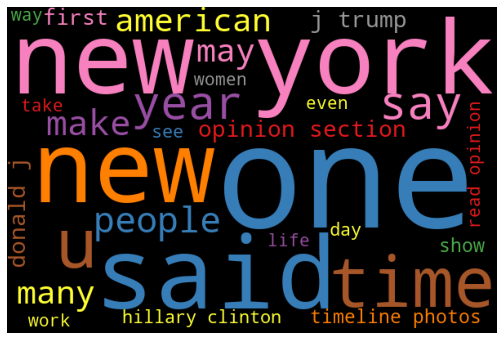

In [699]:
# Wordcloud for most common words in whole corpus, both stopwords
# and punctuation removed
nlp_prep.generate_wordcloud(docs=all_tokens, cmap="Set1", 
                   stopwords=None, min_font_size=16, 
                  title='Entire Corpus')

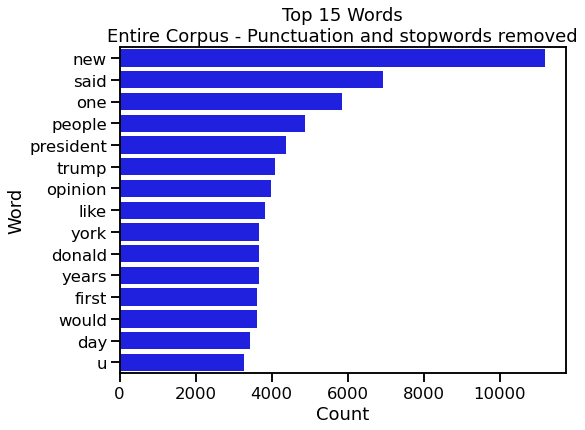

In [700]:
# Plot top 15 words across the entire corpus, punct and stopwords removed
nlp_prep.plot_wordfreqs(corpus_freq_df, 'Word', 'Count', 15, 
               "Entire Corpus - Punctuation and stopwords removed")

Looks like `new` and `york` are still pretty high up there. But if we're talking about the state or city, I'm not sure they should be removed.

### By Engagement Level

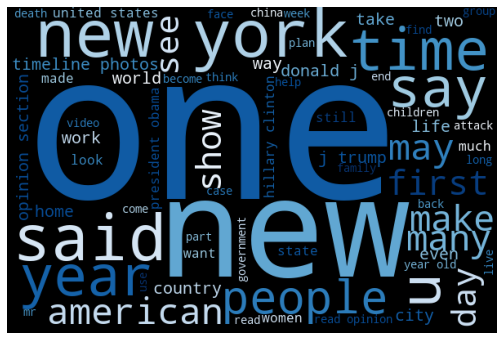

In [701]:
# get frequency distribution for posts with average engagement
avg_eng = FreqDist(token_dict[0])

avg_eng_freq_df = pd.DataFrame(avg_eng.most_common(100),
                              columns=['Word','Count'])

nlp_prep.generate_wordcloud(docs=token_dict[0], cmap="Blues", 
                   stopwords=None, min_font_size=14)

nlp_prep.plot_wordfreqs(avg_eng_freq_df, 'Word', 'Count', 15, 
               "Average Engagement Posts")

In [702]:
# get frequency distribution for posts with high engagement
high_eng = FreqDist(token_dict[1])

high_eng_freq_df = pd.DataFrame(high_eng.most_common(100),
                              columns=['Word','Count'])

nlp_prep.generate_wordcloud(docs=token_dict[1], cmap="Greens", 
                   stopwords=None, min_font_size=14)

nlp_prep.plot_wordfreqs(high_eng_freq_df, 'Word', 'Count', 15, 
               "High Engagement Posts")

Well I'm not totally surprised that the most common words and bigrams in the high engagement posts include `Donald J Trump`, `Obama`, and `Hillary Clinton`, given that this covers the time period running up to the 2016 presidential election.

That said, we have posts for just over 3 years, starting at the end of 2012, when it was far too early to talk about the 2016 election. Given, it seems like the Times wasn't posting as much in 2013; they really ramped up in 2014. It's possible that higher volumes of posts correlated with increased coverage of the 2016 election race.

Candidates didn't even begin to announce their candidacy [until March 2015](https://en.wikipedia.org/wiki/Timeline_of_the_2016_United_States_presidential_election#2014) at the earliest.

In [703]:
# How many posts were BEFORE March 2015?
print(len(df.loc[df['posted_at'] < 'March 1 2015', 'posted_at']))

# How many posts were AFTER March 2015?
print(len(df.loc[df['posted_at'] >= 'March 1 2015', 'posted_at']))

19373
28493


So 28k posts after March 1 2015, and 19k posts before. More posts after the election cycle started than before.

In [704]:
# what's the class distribution for posts before and after March 2015?

print(df.loc[df['posted_at'] < 'March 1 2015', 
             'all_binary'].value_counts(1))
print(df.loc[df['posted_at'] < 'March 1 2015', 
             'all_binary'].value_counts())

print()
# How many posts were AFTER March 2015?
print(df.loc[df['posted_at'] >= 'March 1 2015', 
             'all_binary'].value_counts(1))
print(df.loc[df['posted_at'] >= 'March 1 2015', 
             'all_binary'].value_counts(0))

0.0    0.876168
1.0    0.123832
Name: all_binary, dtype: float64
0.0    16974
1.0     2399
Name: all_binary, dtype: int64

0.0    0.723336
1.0    0.276664
Name: all_binary, dtype: float64
0.0    20610
1.0     7883
Name: all_binary, dtype: int64


The overall percentage of high engagement posts is 21.5%. Looks like only about 12% of posts before March 2015 were high engagement, compared to 27% after.

In [705]:
#  What are some examples of posts with `one` in them, since it ranks highly?
df.loc[df['cleaned'].str.contains(r'\b[Oo]ne\b'), ['cleaned']][5000:5005].values

array([["What Religion Would Jesus Belong To?. 'One puzzle of the world is that religions often don't resemble their founders,' writes Nicholas Kristof. Read on in The Opinion Section. Many faiths have lost sight of their founders' teachings."],
       ["Meet the -Year-Old Director Bringing Kanye West's Visions to Life. Eli Russell Linnetz is in the middle of a 'one-year residency with Kanye.'. The director Eli Russell Linnetz was when he first met the rapper."],
       ["British Radio Show 'The Archers' Divides Fans With Domestic Abuse Story Line. 'The story of Helen and Rob is a very ancient one and deep-seated in British culture, that of a violent man and an abused wife,' said the the editor of BBC The Archers. Set in a rural village, the BBC soap opera keeps finding ways to remain relevant. The trial of a character charged with attempting to murder her abusive husband has much of the nation buzzing."],
       ["Young Blacks Voice Skepticism on Hillary Clinton, Worrying Democrats. '

In [706]:
#  What are some examples of posts with `u` in them, since it ranks highly?
df.loc[df['cleaned'].str.contains(r'\b[Uu]\b'), ['cleaned']][:5].values

array([["Timeline Photos. Serena Williams defeated Victoria Azarenka to win the U. S. Open women's championship on Sunday. See more photos and read the recap of this championship match. (Photo by Chang W. Lee/The ). "],
       ["Timeline Photos. Follow live updates from the U. S. Open Men's Final: Are you rooting for Novak Djokovic to repeat as U. S. Open champion or for Andy Murray (pictured) to win his first Grand Slam title?(Photo by Chang W. Lee/ The ). "],
       ["Timeline Photos. Andy Murray defeated Novak Djokovic to win the U. S. Open Men's Championship, and his first Grand Slam title. See more photos and read the recap of this championship match. Photo: Andy Murray after he took the second set, - (Photo by Chang W. Lee /The ). "],
       ["Timeline Photos. Photo: Andy Murray fended off a late rally by Novak Djokovic at the U. S. Open to win his first Grand Slam and become the first man from Britain to win a Grand Slam title since . (Photo by Chang W. Lee/The )'The crowd at Ar

That makes sense, it's being pulled out of `U.S.`.

## Word Frequencies for article text

## Combine Article Text

In [707]:
df['article_text'] = df['main_headline'].str.cat(df[['snippet', 'lead_paragraph']], 
                                             sep='. ', na_rep='')

In [708]:
df_articles = df.loc[df['is_matched']==1, ['article_text', 'section_name', 
        'word_count_cat', 'glocations', 'subject', 'persons', 'organizations',
        'has_person', 'has_org', 'has_geo', 'is_multimedia', 'on_weekend',
        'm_binary', 'm_multi']]

df_articles.head()

article_text section_name  \
0  Did Barack Obama Save Ohio?. Why the battle to...     Magazine   
1  The Weatherman Is Not a Moron. In the hocus-po...     Magazine   
2  The Organic Fable. A study exposes the hype be...      Opinion   
4  Pot for Parents. I am a more loving, attentive...      Opinion   
5  Obama Makes Birth Certificate Joke. Introduced...         U.S.   

  word_count_cat                                         glocations  \
0           High  [ohio, columbus (ohio), lorain (ohio), cincinn...   
1           High                                                NaN   
2        Average                                    [great britain]   
4        Average                                                NaN   
5            Low                                          [florida]   

                                             subject  \
0  [automobiles, economic conditions and trends, ...   
1  [weather, books and literature, hurricanes and...   
2  [food, organic foods and products, medicine an...   
4  [medical marijuana, marijuana, anxiety and str...   
5                    [presidential election of 2012]   

                                             persons  \
0  [kasich, john r, portman, rob, geithner, timot...   
1     [richardson, lewis fry, lorenz, edward norton]   
2                                                NaN   
4                                                NaN   
5                                    [obama, barack]   

                                       organizations  has_person  has_org  \
0                                         [jobsohio]           1        1   
1  [national center for atmospheric research, int...           1        1   
2                                                NaN           0        0   
4                                                NaN           0        0   
5                                                NaN           1        0   

   has_geo  is_multimedia  on_weekend  m_binary  m_multi  
0        1            0.0         1.0       0.0      1.0  
1        0            0.0         1.0       0.0      0.0  
2        1            0.0         1.0       0.0      1.0  
4        0            0.0         1.0       0.0      1.0  
5        1            0.0         1.0       1.0      2.0

### Text Preprocessing

In [709]:
# back up all_text into cleaned
df_articles['cleaned'] = df_articles['article_text']

In [710]:
# check for links or URLs
df_articles.loc[df_articles['cleaned'].str.contains("http[^ ]+|www\.[^ ]+"), 
                'cleaned'][:5]

2093     Tournament Bracket and Forecast. Need help wit...
4326     Introducing The International New York Times. ...
4327     Introducing The International New York Times. ...
12173    Can a Social Network Stay Ad-Free?. Ello bills...
14510    Apple Cranberry Slab Pie. . A slab pie is noth...
Name: cleaned, dtype: object

In [711]:
df_articles.loc[2093, 'cleaned']

'Tournament Bracket and Forecast. Need help with your N.C.A.A. bracket? Nate Silver is estimating each team’s chance of advancing to any given stage of the N.C.A.A. bracket. View his estimates <a href="http://www.nytimes.com/interactive/2013/03/18/sports/ncaabasketball/nate-bracke.... Need help with your N.C.A.A. bracket? Nate Silver is estimating each team’s chance of advancing to any given stage of the N.C.A.A. bracket. View his estimates <a href="http://www.nytimes.com/interactive/2013/03/18/sports/ncaabasketball/nate-bracket.html#nytmm">as a table</a> and <a href="http://fivethirtyeight.blogs.nytimes.com/2013/03/18/parity-in-n-c-a-a-means-no-commanding-favorite/">read his pre-tournament analysis</a>.'

I see some HTML in here that I'll need to clean out.

In [712]:
from bs4 import BeautifulSoup

def remove_html_tags(doc):
    return BeautifulSoup(doc, 'html.parser').get_text()

df_articles['cleaned'] = df_articles['cleaned'].map(
    lambda x: remove_html_tags(x))

df_articles.loc[2093, 'cleaned']

'Tournament Bracket and Forecast. Need help with your N.C.A.A. bracket? Nate Silver is estimating each team’s chance of advancing to any given stage of the N.C.A.A. bracket. View his estimates as a table and read his pre-tournament analysis.'

In [713]:
# map doc cleaning function onto 'cleaned' column
# urls have been replaced with links
df_articles['cleaned'] = df_articles['cleaned'].map(
    lambda x: nlp_prep.clean_docs(x))

df_articles.loc[df_articles['article_text'].str.contains(
    "http[^ ]+|www\.[^ ]+"), 'cleaned'][:5].values

array(["Tournament Bracket and Forecast. Need help with your N.C.A.A. bracket? Nate Silver is estimating each team's chance of advancing to any given stage of the N.C.A.A. bracket. View his estimates as a table and read his pre-tournament analysis.",
       "Introducing The International New York Times. The move changes the name of The International Herald Tribune and strengthens The New York Times' 24-hour, global digital newsroom. Today we celebrate the debut of The International New York Times ( a news report tailored specifically for the valued members of our global audience.",
       "Introducing The International New York Times. The move changes the name of The International Herald Tribune and strengthens The New York Times' 24-hour, global digital newsroom. Today we celebrate the debut of The International New York Times ( a news report tailored specifically for the valued members of our global audience.",
       'Can a Social Network Stay Ad-Free?. Ello bills itself as proudly 

In [714]:
# check for non-ASCII characters
df_articles.loc[df_articles['article_text'].str.contains(r"[^\x00-\x7F]+"), 
                ['cleaned', 'article_text']][:5].values

array([['Did Barack Obama Save Ohio?. Why the battle to take credit for Ohio\'s ever-so-slightly above-average economy could swing the presidential election. The way John Kasich sees it, he is fulfilling a grand design, a mission for which he was chosen by God, to save Ohio. "It\'s like what what\'s-his-name told the hobbit," Ohio\'s Republican governor told me as we flew on the plane that ferries him around the state. "What\'s that guy\'s name? Gandel? Gandorf?" A pair of young aides seated across from Kasich called out helpfully over the drone of the engine. "Gandalf," Kasich repeated. "Do you remember what he told the hobbit?"',
        'Did Barack Obama Save Ohio?. Why the battle to take credit for Ohio’s ever-so-slightly above-average economy could swing the presidential election.. The way John Kasich sees it, he is fulfilling a grand design, a mission for which he was chosen by God, to save Ohio. “It’s like what what’s-his-name told the hobbit,” Ohio’s Republican governor told me

In [715]:
# check for number-only words
df_articles.loc[df_articles['cleaned'].str.contains(r"[$]*[0-9]+[,.:$%0-9]*\b"),
      ['article_text']][:5].values

array([['Debt Collectors Cashing In on Student Loans. In 2011 the Department of Education paid $1.4 billion to collection agencies to find defaulters, a group that includes nearly one in six borrowers with a balance.. At a protest last year at New York University, students called attention to their mounting debt by wearing T-shirts with the amount they owed scribbled across the front — $90,000, $75,000, $20,000.'],
       ['Five Crucial Factors to Watch, Just 58 Days From the Election. Two months before the election, President Obama and Mitt Romney agree on at least one thing: the collection of states where the race will be decided.. WASHINGTON — Two months before the election, President Obama and Mitt Romney agree on one thing: the collection of states where the race will be decided.'],
       ['Mow Yard. Drop Off Kids. Take a Drive on Mars.. As one member of the team that operates the remote rover Curiosity at NASA’s Jet Propulsion Laboratory put it, “Last night I drove on Mars, toda

In [716]:
# remove numbers-only words
df_articles = nlp_prep.pattern_match_in_df(df_articles, doc_col='cleaned', 
                hit_col='_', pattern=r"[$]*[0-9]+[,.:$%0-9]*\b", 
                out_type='none', replace=True)

In [717]:
# check for number-only words again, have they been removed?
df_articles.loc[df_articles['article_text'].str.contains(
    r"[$]*[0-9]+[,.:$%0-9]*\b"), ['article_text', 'cleaned']][:5].values

array([['Debt Collectors Cashing In on Student Loans. In 2011 the Department of Education paid $1.4 billion to collection agencies to find defaulters, a group that includes nearly one in six borrowers with a balance.. At a protest last year at New York University, students called attention to their mounting debt by wearing T-shirts with the amount they owed scribbled across the front — $90,000, $75,000, $20,000.',
        'Debt Collectors Cashing In on Student Loans. In the Department of Education paid billion to collection agencies to find defaulters, a group that includes nearly one in six borrowers with a balance. At a protest last year at New York University, students called attention to their mounting debt by wearing T-shirts with the amount they owed scribbled across the front , , .'],
       ['Five Crucial Factors to Watch, Just 58 Days From the Election. Two months before the election, President Obama and Mitt Romney agree on at least one thing: the collection of states where t

### Tokenize - No stopwords or punctuation removed

I'm using a tokenizer function that leverages the TweetTokenizer, as it's something I've used before for Tweet processing. Although these are not tweets, they are short text and may contains @mentions that the TweetTokenizer can take out for us.

In [718]:
# Create a dictionary of tokens with class labels as keys
# removing punctuation only
token_dict = nlp_prep.tokenize_corpus_dict_tweet(df_articles, [0, 1], 
            target_col='m_binary', stop_list=None, verbose=False)
token_dict[0][:5]

['did', 'barack', 'obama', 'save', 'ohio']

In [719]:
# create list of all word frequencies in the corpus
all_tokens = []
[all_tokens.extend(tokens) for tokens in token_dict.values()]

len(all_tokens)


3623483

In [720]:
# get frequency distribution for entire corpus
all_corpus = FreqDist(all_tokens)

corpus_freq_df = pd.DataFrame(all_corpus.most_common(100),
                              columns=['Word','Count'])
corpus_freq_df[:5]

Word   Count
0    .  203755
1  the  178636
2    ,  177194
3    a  103722
4   of   91429

In [721]:
# Wordcloud for most common words in whole corpus, no stopwords
# or punctuation removed
nlp_prep.generate_wordcloud(docs=all_tokens, cmap="Set1", 
                   stopwords=None, min_font_size=16, 
                  title='Entire Corpus')

In [722]:
# Plot top 15 words across the entire corpus, no punctuation removed
nlp_prep.plot_wordfreqs(corpus_freq_df, 'Word', 'Count', 15, 
               "Entire Corpus - No punctuation or stopwords removed")

### Tokenize - stopwords and punctuation removed

In [723]:
# Create a dictionary of tokens with class labels as keys
# removing punctuation and stopwords
token_dict = nlp_prep.tokenize_corpus_dict_tweet(df_articles, [0, 1], 
            target_col='m_binary', stop_list=nltk_stopwords + punc, 
                                                 verbose=False)
token_dict[0][:5]

['barack', 'obama', 'save', 'ohio', 'battle']

In [724]:
# create list of all word frequencies in the corpus
all_tokens = []
[all_tokens.extend(tokens) for tokens in token_dict.values()]

len(all_tokens)


1890619

Wow, we've cut the total word count down to 1.9 MM from 3.5 MM.

In [725]:
# get frequency distribution for entire corpus
all_corpus = FreqDist(all_tokens)

corpus_freq_df = pd.DataFrame(all_corpus.most_common(100),
                              columns=['Word','Count'])
corpus_freq_df[:5]

Word  Count
0     new  13876
1     one   8008
2    said   6276
3   years   5389
4  people   5348

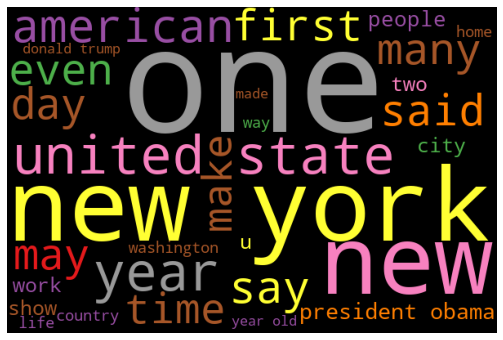

In [726]:
# Wordcloud for most common words in whole corpus, both stopwords
# and punctuation removed
nlp_prep.generate_wordcloud(docs=all_tokens, cmap="Set1", 
                   stopwords=None, min_font_size=16, 
                  title='Entire Corpus')

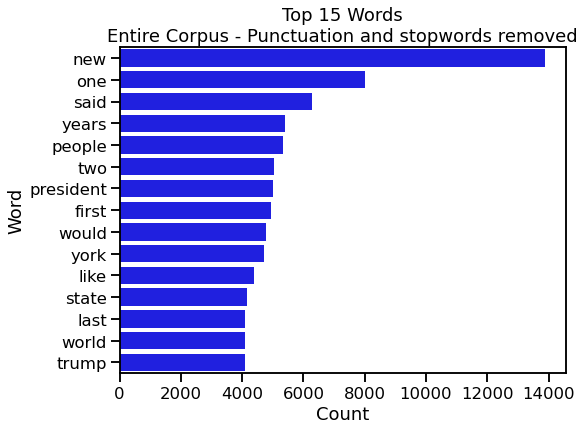

In [727]:
# Plot top 15 words across the entire corpus, no punctuation removed
nlp_prep.plot_wordfreqs(corpus_freq_df, 'Word', 'Count', 15, 
               "Entire Corpus - Punctuation and stopwords removed")

### By Engagement Level

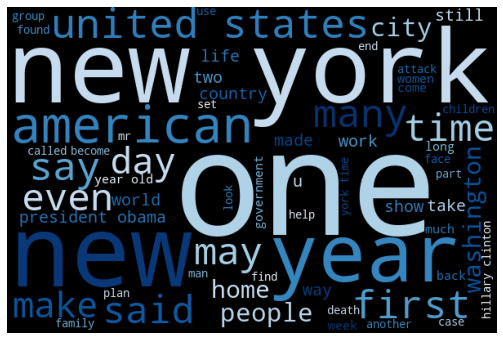

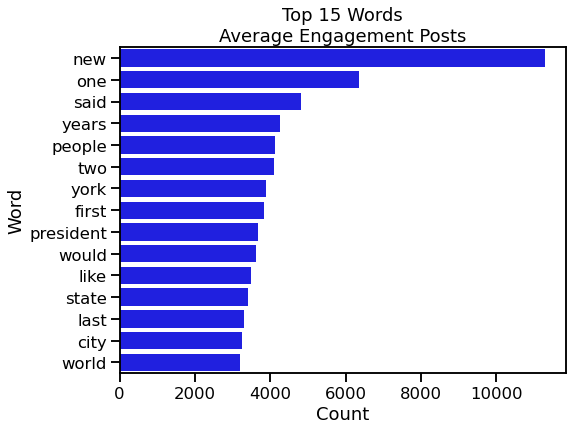

In [728]:
# get frequency distribution for articles with average engagement
avg_eng = FreqDist(token_dict[0])

avg_eng_freq_df = pd.DataFrame(avg_eng.most_common(100),
                              columns=['Word','Count'])

nlp_prep.generate_wordcloud(docs=token_dict[0], cmap="Blues", 
                   stopwords=None, min_font_size=14)

nlp_prep.plot_wordfreqs(avg_eng_freq_df, 'Word', 'Count', 15, 
               "Average Engagement Posts")

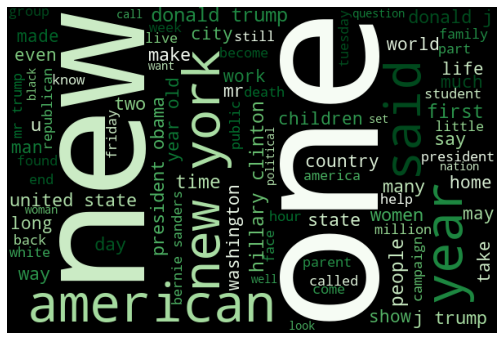

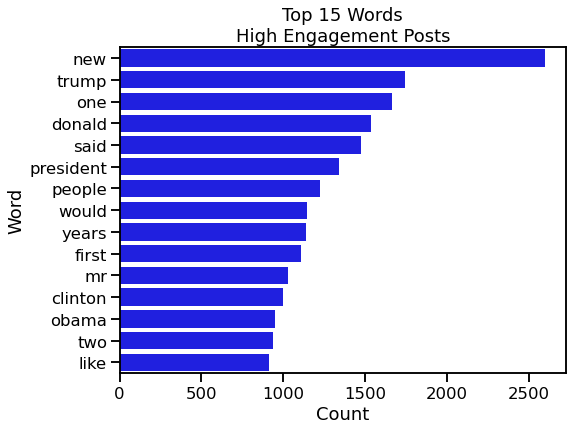

In [729]:
# get frequency distribution for posts with high engagement
high_eng = FreqDist(token_dict[1])

high_eng_freq_df = pd.DataFrame(high_eng.most_common(100),
                              columns=['Word','Count'])

nlp_prep.generate_wordcloud(docs=token_dict[1], cmap="Greens", 
                   stopwords=None, min_font_size=14)

nlp_prep.plot_wordfreqs(high_eng_freq_df, 'Word', 'Count', 15, 
               "High Engagement Posts")

In [730]:
#  What are some examples of posts with `one` in them, since it ranks highly?
df_articles.loc[df_articles['cleaned'].str.contains(r'\b[Oo]ne\b'), 
                ['cleaned']][5000:5005].values

array([['Decrease in Homeless Veterans in New York Far Outpaces National Drop. Even as homelessness has surged, the city has recorded a drop of percent in the number of veterans living in shelters or on the street since though some advocates question the counts. The bedraggled veteran draped in a flag, begging for spare change, has been one of the most persistent images of homelessness in this country.'],
       ['Experts Foresee Obstacles for Both Sides in Bill Cosby Case. Legal experts said the road to conviction was filled with significant hurdles, including a lack of forensic evidence related to the decade-old allegation by the woman at the center of the case. For years, as Bill Cosby and his lawyers aggressively rebutted accusations that he was a sexual predator, his defenders could point to one incontrovertible fact: He had never been charged with a crime.'],
       ["App Makers Reach Out to the Teenager on Mobile. One app's effort to understand its teenage audience illuminates t

## Keyword Frequencies

In [731]:
df_articles.columns

Index(['article_text', 'section_name', 'word_count_cat', 'glocations',
       'subject', 'persons', 'organizations', 'has_person', 'has_org',
       'has_geo', 'is_multimedia', 'on_weekend', 'm_binary', 'm_multi',
       'cleaned'],
      dtype='object')

In [732]:
def visualize_tokens(token_list, title="Word Frequencies", cmap="Set1", 
                     show_viz=True):
    """Concatenates lists of tokens without further breaking them down, then
    creates frequency visualizations.
    
    `tokens` should be a list of lists of tokens; no nulls.
    """
    
    # create list of all word frequencies in the corpus
    all_tokens = []
    [all_tokens.extend(tokens) for tokens in token_list]

    # get frequency distribution for entire corpus
    all_corpus = FreqDist(all_tokens)

    freq_df = pd.DataFrame(all_corpus.most_common(100),
                                  columns=['Token','Count'])
    
    if show_viz:

        # Wordcloud for most common words in whole corpus, both stopwords
        # and punctuation removed
        nlp_prep.generate_wordcloud(docs=all_tokens, cmap=cmap, 
                           stopwords=None, min_font_size=16, 
                          title=title)

        # Plot top 15 words across the entire corpus, no punctuation removed
        nlp_prep.plot_wordfreqs(freq_df, 'Token', 'Count', 15, 
                       title)
    
    return freq_df

### Subjects

In [733]:
# how many unique subjects are there?
all_tokens = []
[all_tokens.extend(tokens) for tokens in list(df_articles.loc[
            df_articles['subject'].isna()==False, 'subject'].values)]

unique_subjects = list(set(all_tokens))
print(len(all_tokens))
print(len(unique_subjects))

127362
3369


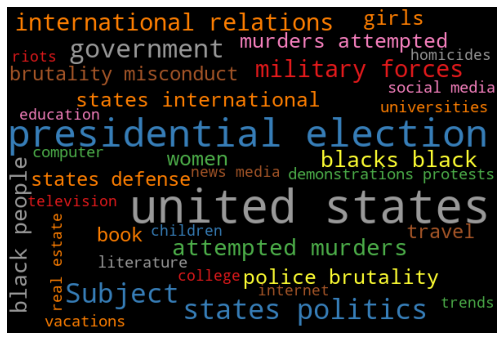

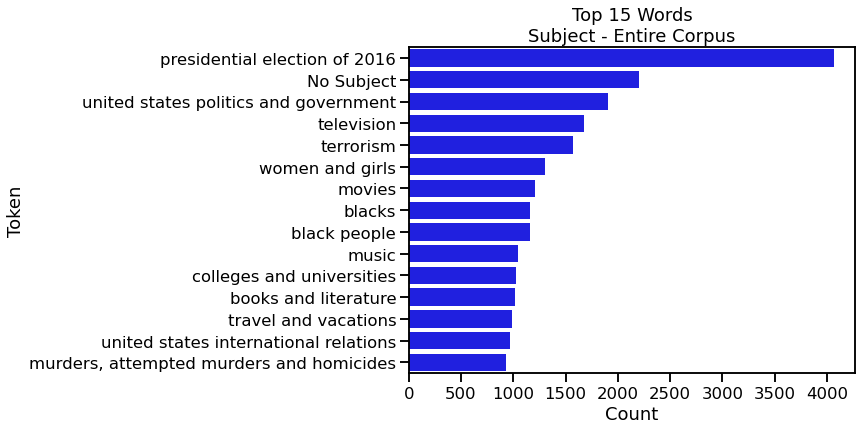

In [734]:
subject_freq_df = visualize_tokens(list(df_articles.loc[
                    df_articles['subject'].isna()==False, 'subject'].values), 
                    title='Subject - Entire Corpus', cmap="Set1")


### Glocations

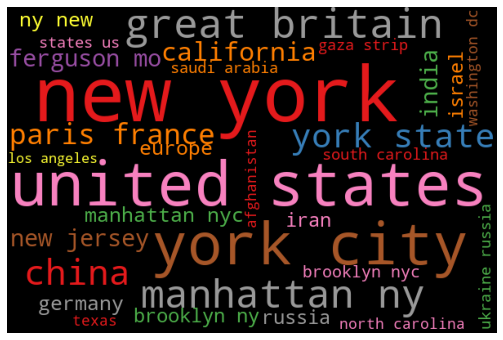

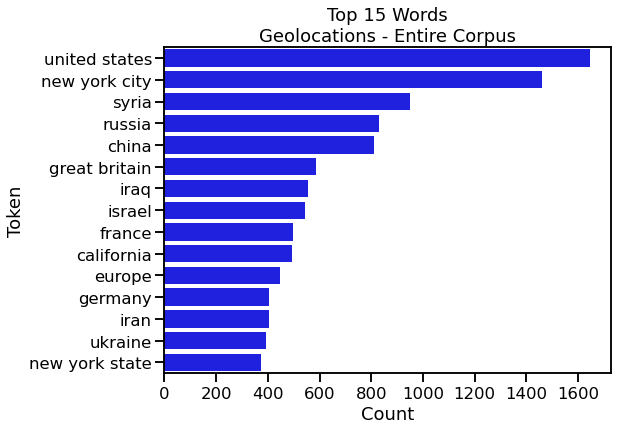

In [735]:
locations_freq_df = visualize_tokens(list(df_articles.loc[
            df_articles['glocations'].isna()==False, 'glocations'].values), 
            title='Geolocations - Entire Corpus', cmap="Set1")

### Organizations

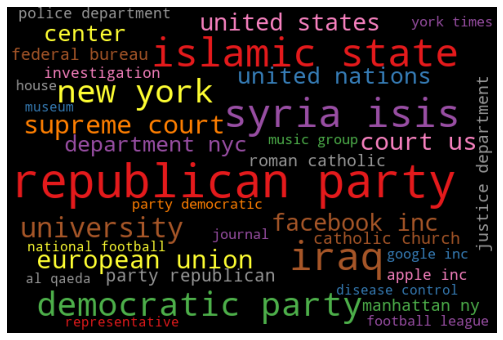

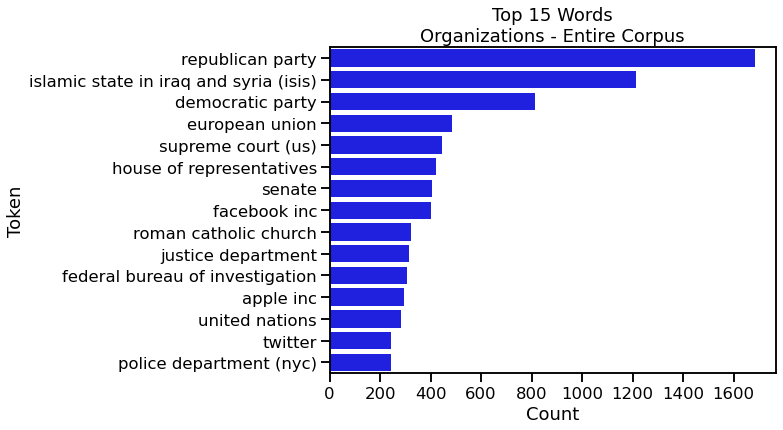

In [736]:
orgs_freq_df = visualize_tokens(list(df_articles.loc[
            df_articles['organizations'].isna()==False, 'organizations'].values), 
            title='Organizations - Entire Corpus', cmap="Set1")


### People

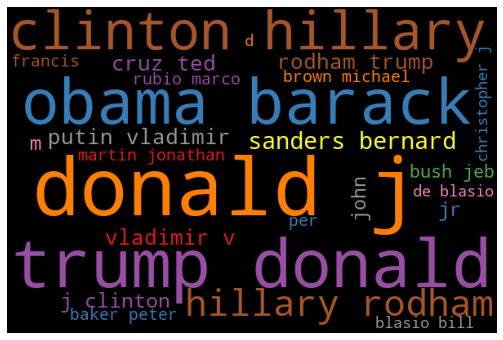

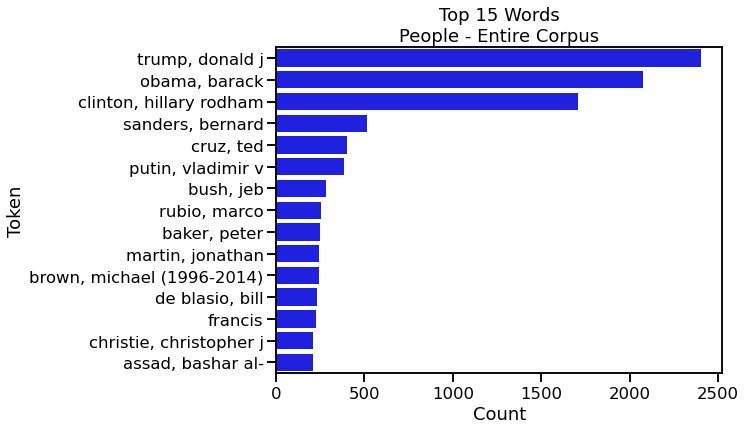

In [737]:
people_freq_df = visualize_tokens(list(df_articles.loc[
            df_articles['persons'].isna()==False, 'persons'].values), 
            title='People - Entire Corpus', cmap="Set1")


### By Engagement Level - Subject

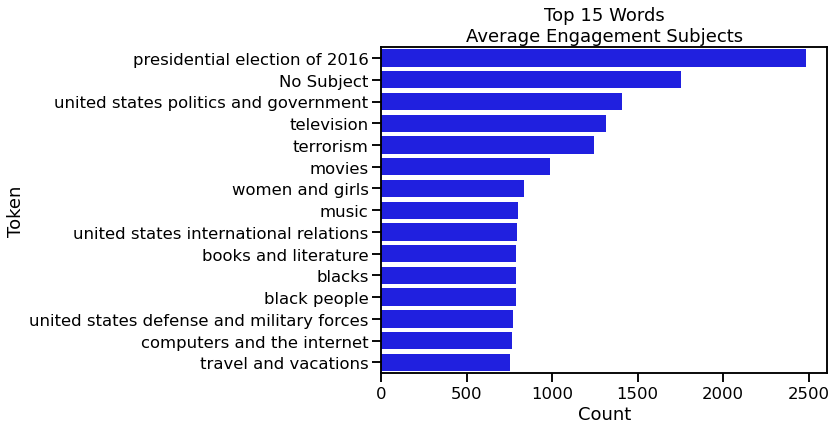

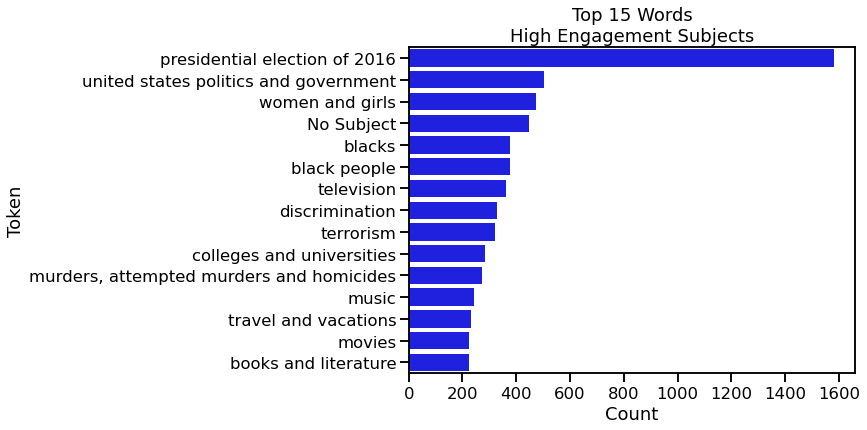

In [738]:
subject_avg = visualize_tokens(list(df_articles.loc[
        (df_articles['subject'].isna()==False) & 
        (df_articles['m_binary']==0), 'subject'].values),
        show_viz=False)

subject_high = visualize_tokens(list(df_articles.loc[
        (df_articles['subject'].isna()==False) & 
        (df_articles['m_binary']==1), 'subject'].values),
        show_viz=False)

nlp_prep.plot_wordfreqs(subject_avg, 'Token', 'Count', 15, 
               "Average Engagement Subjects")

nlp_prep.plot_wordfreqs(subject_high, 'Token', 'Count', 15, 
               "High Engagement Subjects")

### By Engagement Level - Glocations

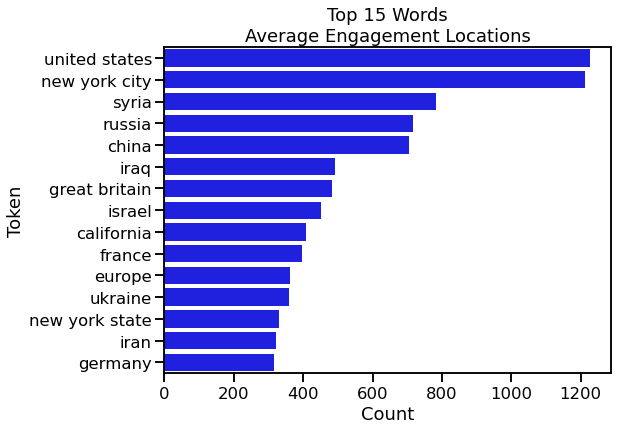

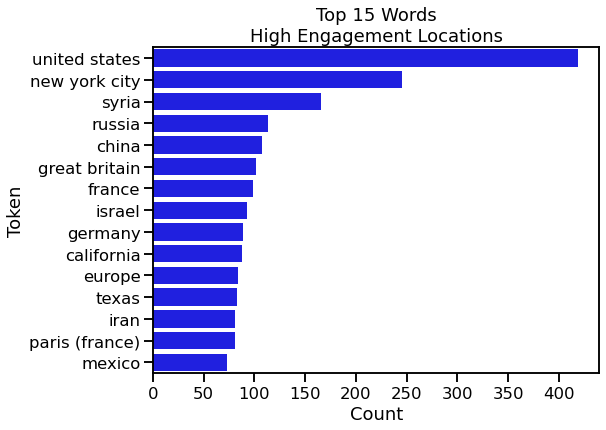

In [739]:
geo_avg = visualize_tokens(list(df_articles.loc[
        (df_articles['glocations'].isna()==False) & 
        (df_articles['m_binary']==0), 'glocations'].values),
        show_viz=False)

geo_high = visualize_tokens(list(df_articles.loc[
        (df_articles['glocations'].isna()==False) & 
        (df_articles['m_binary']==1), 'glocations'].values),
        show_viz=False)

nlp_prep.plot_wordfreqs(geo_avg, 'Token', 'Count', 15, 
               "Average Engagement Locations")

nlp_prep.plot_wordfreqs(geo_high, 'Token', 'Count', 15, 
               "High Engagement Locations")

### By Engagement Level - Organizations

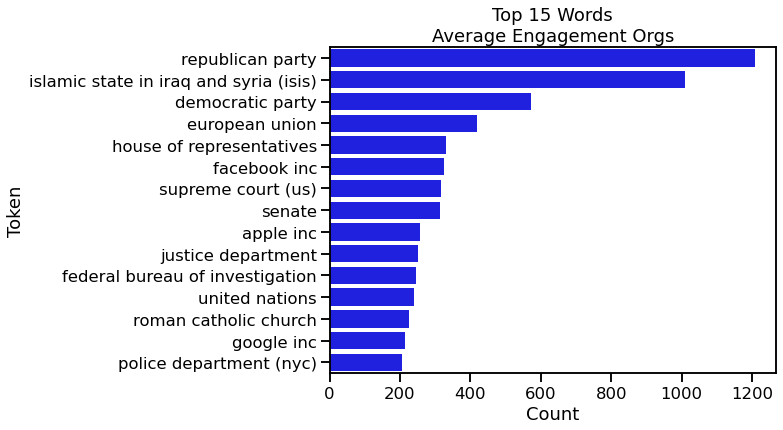

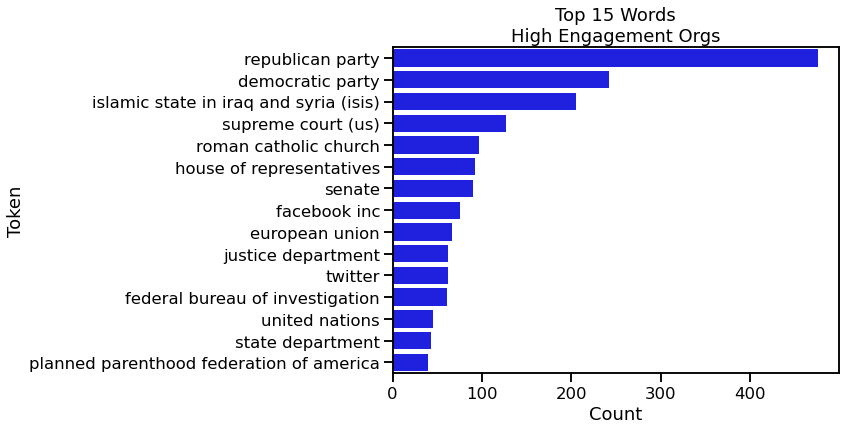

In [740]:
org_avg = visualize_tokens(list(df_articles.loc[
        (df_articles['organizations'].isna()==False) & 
        (df_articles['m_binary']==0), 'organizations'].values),
        show_viz=False)

org_high = visualize_tokens(list(df_articles.loc[
        (df_articles['organizations'].isna()==False) & 
        (df_articles['m_binary']==1), 'organizations'].values),
        show_viz=False)

nlp_prep.plot_wordfreqs(org_avg, 'Token', 'Count', 15, 
               "Average Engagement Orgs")

nlp_prep.plot_wordfreqs(org_high, 'Token', 'Count', 15, 
               "High Engagement Orgs")

### By Engagement Level - People

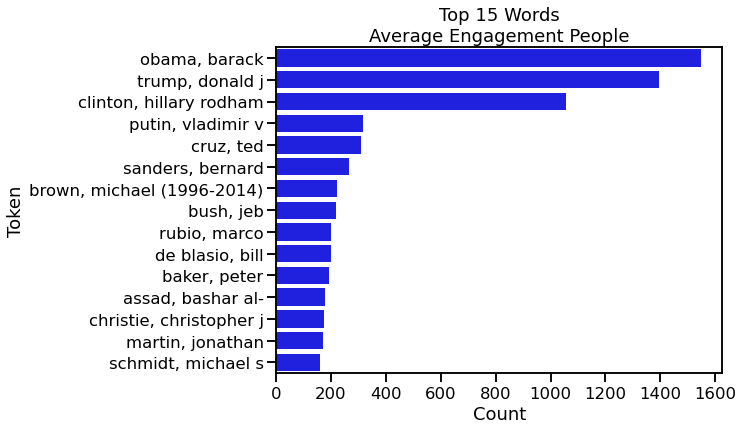

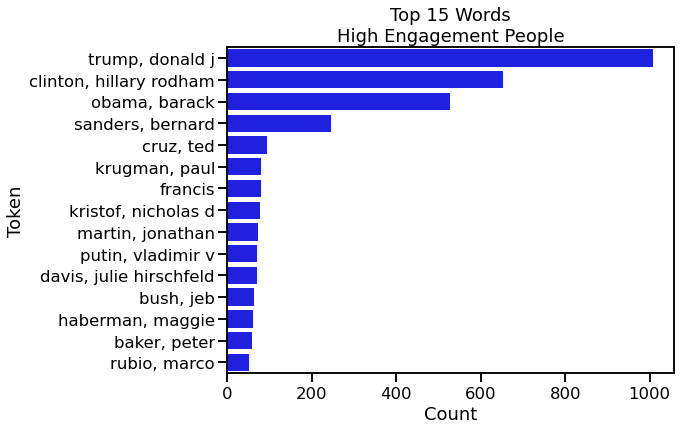

In [741]:
people_avg = visualize_tokens(list(df_articles.loc[
        (df_articles['persons'].isna()==False) & 
        (df_articles['m_binary']==0), 'persons'].values),
        show_viz=False)

people_high = visualize_tokens(list(df_articles.loc[
        (df_articles['persons'].isna()==False) & 
        (df_articles['m_binary']==1), 'persons'].values),
        show_viz=False)

nlp_prep.plot_wordfreqs(people_avg, 'Token', 'Count', 15, 
               "Average Engagement People")

nlp_prep.plot_wordfreqs(people_high, 'Token', 'Count', 15, 
               "High Engagement People")

I don't see much difference in the top entities between high and average engagement.

## Consolidate Rare Categories

In initial modeling, I ran into issues where there were `post_type` and `section_name` values in test that weren't in train. I'm going to combine all rare categories to hopefully avoid this.

In [742]:
df['post_type'].value_counts()

link      42785
photo      2340
video      2062
status      666
event        12
note          1
Name: post_type, dtype: int64

In [743]:
main_cats = ['photo', 'video', 'link']
df.loc[~df['post_type'].isin(main_cats), 'post_type'] = 'other'

In [744]:
df['post_type'].value_counts()

link     42785
photo     2340
video     2062
other      679
Name: post_type, dtype: int64

In [745]:
section_cats = df_articles['section_name'].value_counts()
section_cats

U.S.                          8314
World                         6811
Opinion                       4616
Sports                        2662
New York                      2586
Arts                          2501
Business Day                  2410
Health                        1614
Fashion & Style               1379
Science                       1280
The Upshot                    1229
Magazine                      1154
Technology                    1056
Travel                         762
Cooking                        737
Movies                         655
Food                           581
Books                          422
Multimedia/Photos              330
T Magazine                     286
Style                          282
Theater                        253
Education                      189
Your Money                     188
Real Estate                    180
Blogs                          165
NYT Now                        144
Sunday Review                   79
Well                

In [746]:
rare_sections = section_cats[section_cats < 100].index

df_articles.loc[df_articles['section_name'].isin(rare_sections), 
                'section_name'] = 'Other'

df_articles['section_name'].value_counts()

U.S.                 8314
World                6811
Opinion              4616
Sports               2662
New York             2586
Arts                 2501
Business Day         2410
Health               1614
Fashion & Style      1379
Science              1280
The Upshot           1229
Magazine             1154
Technology           1056
Travel                762
Cooking               737
Movies                655
Food                  581
Other                 441
Books                 422
Multimedia/Photos     330
T Magazine            286
Style                 282
Theater               253
Education             189
Your Money            188
Real Estate           180
Blogs                 165
NYT Now               144
Name: section_name, dtype: int64

## Summary of Explore before First Modeling

I will create my initial model as follows:
- Using Facebook post information, not any of the metadata pulled from the NYT API, since I was not able to match all posts to articles, and the unmatched posts do have a greater percentage of videos and photos, which tend to get higher engagement.
- Using outliers from any of comments, shares, or likes/loves count as my target variable.

In the future, I may consider any of the following:
- Creating a separate model using only the posts that I could match to article metadata. This could include keywords information as well as potentially abstract and main headline. Although this may not be directly comparable to the full set of Facebook posts, I could see whether the primary predictors of high engagement differed in terms of text or topics.
- Use a different cutoff point for target variable. For instance, 75th percentile, or 90th percentile and up, instead of only the outliers.

In [747]:
f = gzip.open('data/cleaned_data.pickle.gz','wb')
pickle.dump(df, f)
f.close()

f = gzip.open('data/cleaned_article_data.pickle.gz','wb')
pickle.dump(df_articles, f)
f.close()

# Model Facebook Posts Only

Initially, I used a target consisting of outliers, and gridsearched for the best hyperparameters using Multinomial Bayes and Logistic Regression without lemmatization. Logistic Regression outperformed Multinomial Bayes.

I took the best params from the LR model using outlier-based target, and experimented with lemmas as well as modeling only text or only metadata. I then applied the best model so far (with lemmatization and text only) to the target using over 75th percentile and it performed better.

Performance didn't get much above 60% for the target class, so I decided to adjust the binary percentile target to use the mean percentile across all categories instead of the max. I also decided to create a multi-class target to see how that performed.

Generally, the best parameters for Logistic Regression were:
- using Tfidf normalization for the text 
- (1,2) ngrams
- 10,000 max features
- C = 0.1 (1.0 might get slightly better recall but is more overfit)
- saga solver
- fit_intercept = False

Text vectorization tended to take quite a while with lemmatization, which made the gridsearching too time-consuming if I wanted to experiment with vectorization parameters such as different stopwords lists, using/not using Tfidf normalization, using/not using lemmatization, and using different numbers of max features. Ultimately, since the best parameters for both the full set of Facebook posts and the text of the matched articles were the same, I decided to apply those up front and consider my new baseline models.

In [748]:
df.columns

Index(['id', 'caption', 'post_type', 'status_type', 'comments_count',
       'shares_count', 'link', 'posted_at', 'print_section', 'print_page',
       'snippet', 'lead_paragraph', 'main_headline', 'news_desk',
       'section_name', 'type_of_material', 'word_count', 'glocations',
       'subject', 'persons', 'organizations', 'creative_works', 'is_matched',
       'all_text', 'likes_loves', 'shares_outliers', 'comments_outliers',
       'likelove_outliers', 'comments_pct', 'shares_pct', 'likesloves_pct',
       'max_pct', 'mean_pct', 'all_binary', 'all_multi', 'comments_pct_m',
       'shares_pct_m', 'likesloves_pct_m', 'max_pct_m', 'mean_pct_m',
       'm_binary', 'm_multi', 'is_interactive', 'is_video', 'is_slideshow',
       'word_count_cat', 'has_person', 'has_org', 'has_geo', 'is_multimedia',
       'day_name', 'month', 'hour', 'year', 'hour_cat', 'on_weekend',
       'text_hash', 'cleaned', 'article_text'],
      dtype='object')

## Different stopwords and punc

I noticed that many of the posts I couldn't match to articles included questions to readers, and asked them to give their opinion in comments. I'm going to remove the question mark and the you/your permutations from the stopwords list to see whether keeping these in affect model performance.

In [749]:
you_list = ['you', "you'd", "you'll", "you're", "you've", 'your', 'yours',
            'yourself', 'yourselves']
custom_stopwords = [word for word in nltk_stopwords if word not in you_list]

custom_punc = punc.copy()
custom_punc.remove('?')

## Preprocessing

In [750]:
# constants for column names involved
text_col = 'cleaned'
cat_cols = ['post_type', 'hour_cat', 'on_weekend']

In [751]:
# initial X and y set for all posts
X = df[[text_col] + cat_cols]
y = df['all_binary']

In [752]:
# 0 is average, 1 is high engagement
class_labels = ['Average', 'High Engagement']

# 0 is average, 1 is moderate, 2 is high
mclass_labels = ['Average', 'Moderate', 'High']

In [753]:
# train test split
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X, y, 
                                            test_size=0.2, stratify=y)
print(len(X_train_all))
print(len(y_train_all))
print(len(X_test_all))
print(len(y_test_all))

38292
38292
9574
9574


I will want to be able to use the same train-test split for binary as I do for multi-class, so they will be directly comparable.

Thankfully, the indexes in the split dfs stay the same as the original df, so I should be able to generate the same y_train and y_test splits using the multi-class target.

In [754]:
# Create multi-class y_train using the same indices as binary
y_train_all_multi = df[df.index.isin(y_train_all.index)]['all_multi']
y_train_all_multi = y_train_all_multi.reindex(index=list(y_train_all.index))

# Create multi-class y_test using the same indices as binary
y_test_all_multi = df[df.index.isin(y_test_all.index)]['all_multi']
y_test_all_multi = y_test_all_multi.reindex(index=list(y_test_all.index))

In [755]:
print(y_train_all_multi.isna().sum())
y_test_all_multi.isna().sum()

0


0

### Which categories will be dropped as first?

In [756]:
print(X['post_type'].unique())

['link' 'photo' 'other' 'video']


The first will be `link`, which most of the posts.

In [757]:
print(X['hour_cat'].unique())

['3_Midday (11-15)' '4_Afternoon (15-19)' '5_Evening (19-23)'
 '2_Morning (7-11)' '6_Late night (23-3)' '1_Early morning (3-7)']


The first will be Early Morning, which is rare.

## Transform X up front

To save time gridsearching and evaluating models based on model hyperparameters only.

In [758]:
# Transform text and cat cols ahead of time to save time when gridsearching
# further
txt_trans_pipe = Pipeline([
    ('vect', CountVectorizer(tokenizer=nlp_prep.tokenize_lemma,
                            stop_words=custom_stopwords + custom_punc,
                            ngram_range=(1, 2),
                            max_features=10000)),
    ('tfidf', TfidfTransformer())
])

# NOTE: The text transformers expect a single column, in a 1-D array.
# If you pass a list of strings as column names for the text transformer,
# it will crap out because it will receive a 2D array...
all_cols_trans = ColumnTransformer([
    ('ohe', OneHotEncoder(drop='first'), cat_cols),
    ('txt', txt_trans_pipe, text_col)
])

X_train_all_t = all_cols_trans.fit_transform(X_train_all)
X_test_all_t = all_cols_trans.transform(X_test_all)

/Users/jessicamiles/opt/anaconda3/envs/learn-env2a/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


In [759]:
# Path I'm going to use to save best estimators from gridsearching
save_path = "models/"

In [760]:
rerun_grid = False

## Baseline Dummy Classifiers

### Binary

****************************** Training Data ******************************
              precision    recall  f1-score   support

         0.0       0.79      0.79      0.79     30067
         1.0       0.21      0.21      0.21      8225

    accuracy                           0.66     38292
   macro avg       0.50      0.50      0.50     38292
weighted avg       0.66      0.66      0.66     38292


****************************** Test Data ******************************
              precision    recall  f1-score   support

         0.0       0.78      0.78      0.78      7517
         1.0       0.20      0.20      0.20      2057

    accuracy                           0.66      9574
   macro avg       0.49      0.49      0.49      9574
weighted avg       0.66      0.66      0.66      9574


****************************** Training Scores ******************************
                  Training F1 = [0.7862 0.2139]
              Training Recall = [0.7872 0.2129]
            Training A

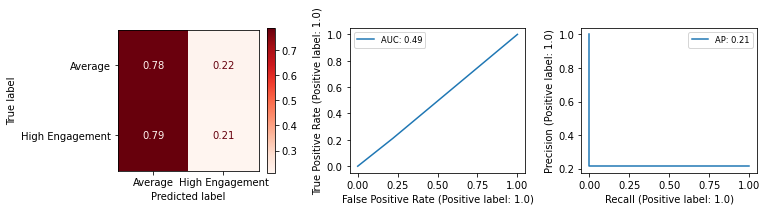

In [761]:
# Let's make a baseline classifier using the dummy model
dummy_clf = DummyClassifier(strategy='stratified')

dummy_clf.fit(X_train_all_t, y_train_all)

model_eval.eval_clf_model(dummy_clf, X_test_all_t, y_test_all, X_train_all_t, 
            y_train_all, labels=class_labels, score='std')

### Multi-class

****************************** Training Data ******************************
              precision    recall  f1-score   support

         0.0       0.22      0.21      0.22      8180
         1.0       0.57      0.58      0.57     21887
         2.0       0.21      0.21      0.21      8225

    accuracy                           0.42     38292
   macro avg       0.33      0.33      0.33     38292
weighted avg       0.42      0.42      0.42     38292


****************************** Test Data ******************************
              precision    recall  f1-score   support

         0.0       0.21      0.21      0.21      2034
         1.0       0.57      0.56      0.56      5483
         2.0       0.21      0.21      0.21      2057

    accuracy                           0.41      9574
   macro avg       0.33      0.33      0.33      9574
weighted avg       0.41      0.41      0.41      9574


****************************** Training Scores ******************************
          

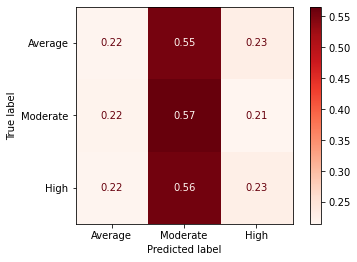

In [762]:
dummy_clf.fit(X_train_all_t, y_train_all_multi)

model_eval.eval_clf_model(dummy_clf, X_test_all_t, y_test_all_multi, 
        X_train_all_t, y_train_all_multi, labels=mclass_labels, score='std')

## Multinomial Bayes

### Baseline Binary

Best on previous best hyper params from gridsearching on slightly different targets.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.0s finished


0.5913677811550152
****************************** Training Data ******************************
              precision    recall  f1-score   support

         0.0       0.91      0.73      0.81     30067
         1.0       0.43      0.73      0.54      8225

    accuracy                           0.73     38292
   macro avg       0.67      0.73      0.67     38292
weighted avg       0.80      0.73      0.75     38292


****************************** Test Data ******************************
              precision    recall  f1-score   support

         0.0       0.86      0.70      0.77      7517
         1.0       0.35      0.59      0.44      2057

    accuracy                           0.68      9574
   macro avg       0.61      0.65      0.61      9574
weighted avg       0.75      0.68      0.70      9574


****************************** Training Scores ******************************
                  Training F1 = [0.8116 0.5383]
              Training Recall = [0.7342 0.7262]
   

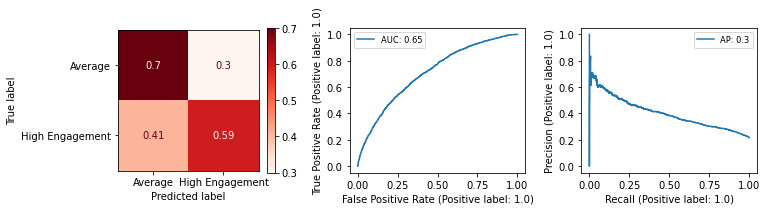

In [763]:
clf_mnb = MultinomialNB(fit_prior=False, alpha=0.5)

cv_scores = cross_val_score(clf_mnb, X_train_all_t, y_train_all, n_jobs=-1, 
                            scoring='recall', verbose=1)
print(np.mean(cv_scores))

clf_mnb.fit(X_train_all_t, y_train_all)

model_eval.eval_clf_model(clf_mnb, X_test_all_t, y_test_all, X_train_all_t, 
            y_train_all, labels=class_labels, score='std')

### Baseline Multi-class

In [764]:
clf_mnb_multi = MultinomialNB(fit_prior=False, alpha=0.5)

cv_scores = cross_val_score(clf_mnb_multi, X_train_all_t, y_train_all_multi, 
            n_jobs=-1, scoring='recall_macro', verbose=1, error_score='raise')
print(np.mean(cv_scores))

clf_mnb_multi.fit(X_train_all_t, y_train_all_multi)

model_eval.eval_clf_model(clf_mnb_multi, X_test_all_t, y_test_all_multi,  
        X_train_all_t, y_train_all_multi, labels=mclass_labels, score='std')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished


0.5057415301922579
****************************** Training Data ******************************
              precision    recall  f1-score   support

         0.0       0.50      0.68      0.58      8180
         1.0       0.76      0.53      0.63     21887
         2.0       0.46      0.66      0.55      8225

    accuracy                           0.59     38292
   macro avg       0.58      0.63      0.58     38292
weighted avg       0.64      0.59      0.60     38292


****************************** Test Data ******************************
              precision    recall  f1-score   support

         0.0       0.40      0.53      0.46      2034
         1.0       0.64      0.45      0.53      5483
         2.0       0.37      0.53      0.43      2057

    accuracy                           0.49      9574
   macro avg       0.47      0.51      0.47      9574
weighted avg       0.53      0.49      0.49      9574


****************************** Training Scores **********************

## Logistic Regression

### Baseline Binary

Best on previous best hyper params from gridsearching on slightly different targets.

In [765]:
clf_lr = LogisticRegression(max_iter=300, 
                            class_weight='balanced',
                            penalty='l2',
                            fit_intercept=False,
                            solver='saga',
                            C=0.1)

cv_scores = cross_val_score(clf_lr, X_train_all_t, y_train_all, n_jobs=-1, 
                            scoring='recall', verbose=1)
print(np.mean(cv_scores))

clf_lr.fit(X_train_all_t, y_train_all)

model_eval.eval_clf_model(clf_lr, X_test_all_t, y_test_all, X_train_all_t, 
            y_train_all, labels=class_labels, score='std')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.4s finished


0.6080243161094225
****************************** Training Data ******************************
              precision    recall  f1-score   support

         0.0       0.90      0.71      0.79     30067
         1.0       0.39      0.70      0.50      8225

    accuracy                           0.70     38292
   macro avg       0.64      0.70      0.65     38292
weighted avg       0.79      0.70      0.73     38292


****************************** Test Data ******************************
              precision    recall  f1-score   support

         0.0       0.87      0.68      0.76      7517
         1.0       0.35      0.62      0.44      2057

    accuracy                           0.67      9574
   macro avg       0.61      0.65      0.60      9574
weighted avg       0.75      0.67      0.69      9574


****************************** Training Scores ******************************
                  Training F1 = [0.789  0.5034]
              Training Recall = [0.7052 0.6988]
   

### Gridsearch for Binary - no lemmas
### *** Best All Binary ***

/Users/jessicamiles/opt/anaconda3/envs/learn-env2a/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator OneHotEncoder from version 0.22.2.post1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/Users/jessicamiles/opt/anaconda3/envs/learn-env2a/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator CountVectorizer from version 0.22.2.post1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/Users/jessicamiles/opt/anaconda3/envs/learn-env2a/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.22.2.post1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/Users/jessicamiles/opt/anaconda3/envs/learn-env2a/lib/python3.8/site-packages/sklearn/base.

[('cols_trans', ColumnTransformer(transformers=[('ohe', OneHotEncoder(drop='first'),
                                 ['post_type', 'hour_cat', 'on_weekend']),
                                ('txt',
                                 Pipeline(steps=[('vect',
                                                  CountVectorizer(max_features=10000,
                                                                  ngram_range=(1,
                                                                               2),
                                                                  stop_words=['a',
                                                                              'about',
                                                                              'above',
                                                                              'after',
                                                                              'again',
                                                            

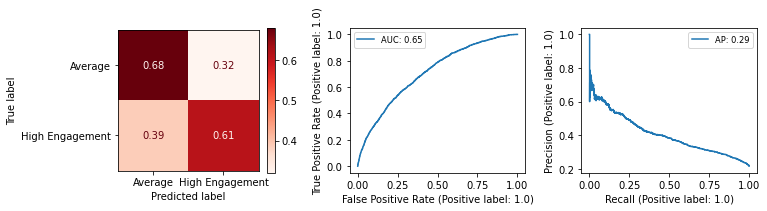

In [766]:
# Gridsearch was run in colab notebook, where I searched vectorization 
# parameters with no lemmatization. This just loads the best estimator.
# using the non-transformed X's since the gridsearch will do the transformation

gsfile_name = 'GSObject_LR_all_binary.joblib.gz'

best_LR_all_binary_pipe, best_LR_all_binary_gs = model_eval.\
        load_rebuild_eval_bestpipe(gsfile_name, X_train_all, y_train_all, 
        X_test_all, y_test_all, class_labels, load_path=save_path)

In [767]:
# what is the version of stopwords used?
best_LR_all_binary_pipe.named_steps['cols_trans'].named_transformers_['txt']\
    .named_steps['vect'].get_stop_words()


frozenset({'!',
           '"',
           '#',
           '$',
           '%',
           '&',
           "'",
           '(',
           ')',
           '*',
           '+',
           ',',
           '-',
           '.',
           '/',
           ':',
           ';',
           '<',
           '=',
           '>',
           '@',
           '[',
           '\\',
           ']',
           '^',
           '_',
           '`',
           'a',
           'about',
           'above',
           'after',
           'again',
           'against',
           'ain',
           'all',
           'am',
           'an',
           'and',
           'any',
           'are',
           'aren',
           "aren't",
           'as',
           'at',
           'be',
           'because',
           'been',
           'before',
           'being',
           'below',
           'between',
           'both',
           'but',
           'by',
           'can',
           'couldn',
           "could

The custom stopwords list (not including `?` or permutations of `your` was best for binary LR with lemmatization.

### Baseline Multi-class

Best on previous best hyper params from gridsearching on slightly different targets.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.1s finished


0.510203081632669
****************************** Training Data ******************************
              precision    recall  f1-score   support

         0.0       0.45      0.70      0.55      8180
         1.0       0.76      0.43      0.55     21887
         2.0       0.42      0.68      0.52      8225

    accuracy                           0.54     38292
   macro avg       0.55      0.60      0.54     38292
weighted avg       0.62      0.54      0.54     38292


****************************** Test Data ******************************
              precision    recall  f1-score   support

         0.0       0.38      0.59      0.46      2034
         1.0       0.65      0.36      0.46      5483
         2.0       0.36      0.59      0.45      2057

    accuracy                           0.46      9574
   macro avg       0.46      0.51      0.46      9574
weighted avg       0.53      0.46      0.46      9574


****************************** Training Scores ***********************

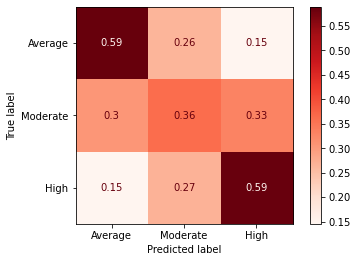

In [768]:
clf_lr = LogisticRegression(max_iter=300, 
                            class_weight='balanced',
                            penalty='l2',
                            fit_intercept=False,
                            solver='saga',
                            C=0.1)

cv_scores = cross_val_score(clf_lr, X_train_all_t, y_train_all_multi, n_jobs=-1, 
                            scoring='recall_macro', verbose=1)
print(np.mean(cv_scores))

clf_lr.fit(X_train_all_t, y_train_all_multi)

model_eval.eval_clf_model(clf_lr, X_test_all_t, y_test_all_multi, X_train_all_t, 
            y_train_all_multi, labels=mclass_labels, score='std')

### Gridsearch for Multi-class - no lemmas
### *** Best All Multi ***

/Users/jessicamiles/opt/anaconda3/envs/learn-env2a/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator OneHotEncoder from version 0.22.2.post1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/Users/jessicamiles/opt/anaconda3/envs/learn-env2a/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator CountVectorizer from version 0.22.2.post1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/Users/jessicamiles/opt/anaconda3/envs/learn-env2a/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.22.2.post1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/Users/jessicamiles/opt/anaconda3/envs/learn-env2a/lib/python3.8/site-packages/sklearn/base.

[('cols_trans', ColumnTransformer(transformers=[('ohe', OneHotEncoder(drop='first'),
                                 ['post_type', 'hour_cat', 'on_weekend']),
                                ('txt',
                                 Pipeline(steps=[('vect',
                                                  CountVectorizer(max_features=10000,
                                                                  ngram_range=(1,
                                                                               2),
                                                                  stop_words=['a',
                                                                              'about',
                                                                              'above',
                                                                              'after',
                                                                              'again',
                                                            

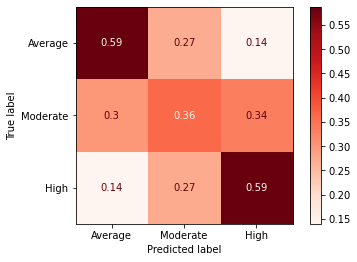

In [769]:
gsfile_name = 'GSObject_LR_all_multi.joblib.gz'

best_LR_all_multi_pipe, best_LR_all_multi_gs = model_eval.\
        load_rebuild_eval_bestpipe(gsfile_name, X_train_all, y_train_all_multi, 
        X_test_all, y_test_all_multi, mclass_labels, load_path=save_path)

In [770]:
# what is the version of stopwords used?
best_LR_all_multi_pipe.named_steps['cols_trans'].named_transformers_['txt']\
    .named_steps['vect'].get_stop_words()

frozenset({'!',
           '"',
           '#',
           '$',
           '%',
           '&',
           "'",
           '(',
           ')',
           '*',
           '+',
           ',',
           '-',
           '.',
           '/',
           ':',
           ';',
           '<',
           '=',
           '>',
           '@',
           '[',
           '\\',
           ']',
           '^',
           '_',
           '`',
           'a',
           'about',
           'above',
           'after',
           'again',
           'against',
           'ain',
           'all',
           'am',
           'an',
           'and',
           'any',
           'are',
           'aren',
           "aren't",
           'as',
           'at',
           'be',
           'because',
           'been',
           'before',
           'being',
           'below',
           'between',
           'both',
           'but',
           'by',
           'can',
           'couldn',
           "could

Custom stopwords again.

### LR results

The best binary LR identifies about 60% of high engagement posts correctly, and about 68% of average engagement posts correctly. As a reminder, for binary target, `high` defines posts with mean percentiles across all three engagement metrics greater than 75.

- Stopwords list that does not include permutations of `your` or `?` performs better than NLTK according to gridsearch optimized for recall.
- TF-IDF transformation does better than regular count or binary
- N-grams (1,2) are still better than (1,1), and max features 10k are better than 100k or no limit
- There is a slight performance difference between lemmatizing versus not, but not very much. Using regular Tweet Tokeniezer is slightly better.

The best multi-class LR finds about ~60% of Average and High engagement posts correctly, but only about 37% of Moderate. For the multi-class target, High engagement is defined the same way as binary, but Average is defined as mean percentile under 25%, and Moderate is mean percentile between 25% and 75%.

In multi-class, posts are mis-classified fairly evenly. Both High and Average are mis-classified as Moderate most frequently (about 30%) but are confused for each other only about 14%.

- As with binary, the best params are custom stopwords TF-IDF text vectorization normalization, (1,2) n-grams, and 10k feature limit.
- Regular tweet-tokenizer actually did slightly better than using lemmatization in this case, although not by much.


# Model Matched Articles

## Preprocessing

In [771]:
cat_cols = ['section_name', 'word_count_cat', 'is_multimedia', 'has_person', 
            'has_org', 'has_geo']

Xmat = df_articles[['cleaned', 'subject'] + cat_cols]
ymat = df_articles['m_binary']

In [772]:
# train test split
X_train_mat, X_test_mat, y_train_mat, y_test_mat = train_test_split(Xmat, ymat, 
                                    test_size=0.2, stratify=ymat)
print(len(X_train_mat))
print(len(y_train_mat))
print(len(X_test_mat))
print(len(y_test_mat))

34581
34581
8646
8646


I will want to be able to use the same train-test split for binary as I do for multi-class, so they will be directly comparable.

Thankfully, the indexes in the split dfs stay the same as the original df, so I should be able to generate the same y_train and y_test splits using the multi-class target.

In [773]:
# Create multi-class y_train using the same indices as binary
y_train_mat_multi = df[df.index.isin(y_train_mat.index)]['all_multi']
y_train_mat_multi = y_train_mat_multi.reindex(index=list(y_train_mat.index))

# Create multi-class y_test using the same indices as binary
y_test_mat_multi = df[df.index.isin(y_test_mat.index)]['all_multi']
y_test_mat_multi = y_test_mat_multi.reindex(index=list(y_test_mat.index))

## Transform X up front

To save time gridsearching and evaluating models based on model hyperparameters only.

In [774]:
# Transform text and cat cols ahead of time to save time when gridsearching
# further
txt_trans_pipe = Pipeline([
    ('vect', CountVectorizer(tokenizer=nlp_prep.tokenize_lemma,
                            stop_words=custom_stopwords + custom_punc,
                            ngram_range=(1, 2),
                            max_features=10000)),
    ('tfidf', TfidfTransformer())
])

def no_analyzer(doc):
    return doc

# creating a column transformer to combine OHE of cat cols, basic count
# vectorization of subject, and tokenizing and vectorization of cleaned text
m_cols_trans = ColumnTransformer([
    ('ohe', OneHotEncoder(drop='first'), cat_cols),
    ('txt_kw', CountVectorizer(analyzer=no_analyzer), 'subject'),
    ('txt', txt_trans_pipe, 'cleaned')
])

X_train_mat_t = m_cols_trans.fit_transform(X_train_mat)
X_test_mat_t = m_cols_trans.transform(X_test_mat)

/Users/jessicamiles/opt/anaconda3/envs/learn-env2a/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


When gridsearching different text vectorization options, using lemmas versus using a basic TweetTokenizer was the only param that was selected differently. Going to transform using TweetTokenizer and try both ways, with all other params held constant, to compare.

In [775]:
# No lemmatization
tweettokenizer = TweetTokenizer(preserve_case=False, strip_handles=True)

txt_trans_pipe2 = Pipeline([
    ('vect', CountVectorizer(tokenizer=tweettokenizer.tokenize,
                            stop_words=custom_stopwords + custom_punc,
                            ngram_range=(1, 2),
                            max_features=10000)),
    ('tfidf', TfidfTransformer())
])

def no_analyzer(doc):
    return doc

# creating a column transformer to combine OHE of cat cols, basic count
# vectorization of subject, and tokenizing and vectorization of cleaned text
m_cols_trans2 = ColumnTransformer([
    ('ohe', OneHotEncoder(drop='first'), cat_cols),
    ('txt_kw', CountVectorizer(analyzer=no_analyzer), 'subject'),
    ('txt', txt_trans_pipe2, 'cleaned')
])

X_train_mat_t2 = m_cols_trans2.fit_transform(X_train_mat)
X_test_mat_t2 = m_cols_trans2.transform(X_test_mat)

## Baseline Dummy Classifier

### Binary

****************************** Training Data ******************************
              precision    recall  f1-score   support

         0.0       0.78      0.78      0.78     27140
         1.0       0.21      0.21      0.21      7441

    accuracy                           0.66     34581
   macro avg       0.50      0.50      0.50     34581
weighted avg       0.66      0.66      0.66     34581


****************************** Test Data ******************************
              precision    recall  f1-score   support

         0.0       0.78      0.78      0.78      6786
         1.0       0.21      0.21      0.21      1860

    accuracy                           0.66      8646
   macro avg       0.49      0.49      0.49      8646
weighted avg       0.66      0.66      0.66      8646


****************************** Training Scores ******************************
                  Training F1 = [0.7846 0.2146]
              Training Recall = [0.7846 0.2146]
            Training A

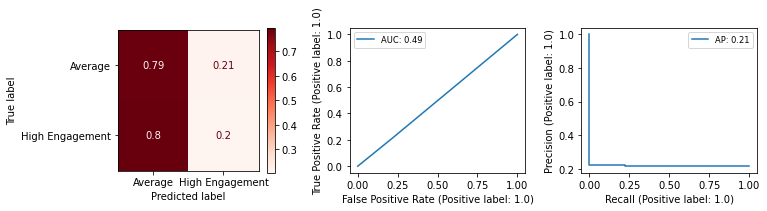

In [776]:
# Let's make a baseline classifier using the dummy model
dummy_clf = DummyClassifier(strategy='stratified')

dummy_clf.fit(X_train_mat_t, y_train_mat)

model_eval.eval_clf_model(dummy_clf, X_test_mat_t, y_test_mat, X_train_mat_t, 
            y_train_mat, labels=class_labels, score='std')

### Multi-class

****************************** Training Data ******************************
              precision    recall  f1-score   support

         0.0       0.21      0.21      0.21      7275
         1.0       0.58      0.58      0.58     20053
         2.0       0.21      0.21      0.21      7253

    accuracy                           0.42     34581
   macro avg       0.33      0.33      0.33     34581
weighted avg       0.42      0.42      0.42     34581


****************************** Test Data ******************************
              precision    recall  f1-score   support

         0.0       0.18      0.18      0.18      1824
         1.0       0.58      0.58      0.58      5005
         2.0       0.22      0.22      0.22      1817

    accuracy                           0.42      8646
   macro avg       0.33      0.33      0.33      8646
weighted avg       0.42      0.42      0.42      8646


****************************** Training Scores ******************************
          

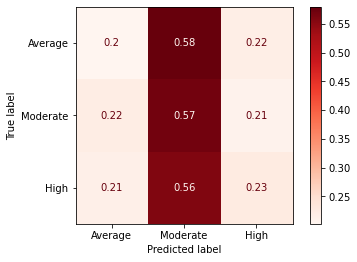

In [777]:
dummy_clf.fit(X_train_mat_t, y_train_mat_multi)

model_eval.eval_clf_model(dummy_clf, X_test_mat_t, y_test_mat_multi,  
        X_train_mat_t, y_train_mat_multi, labels=mclass_labels, score='std')

## Multinomial Bayes

### Baseline Binary

Best on previous best hyper params from gridsearching on slightly different targets.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.2s finished


0.6090586342858382
****************************** Training Data ******************************
              precision    recall  f1-score   support

         0.0       0.90      0.70      0.78     27140
         1.0       0.39      0.71      0.51      7441

    accuracy                           0.70     34581
   macro avg       0.65      0.71      0.65     34581
weighted avg       0.79      0.70      0.72     34581


****************************** Test Data ******************************
              precision    recall  f1-score   support

         0.0       0.86      0.66      0.75      6786
         1.0       0.33      0.62      0.43      1860

    accuracy                           0.65      8646
   macro avg       0.60      0.64      0.59      8646
weighted avg       0.75      0.65      0.68      8646


****************************** Training Scores ******************************
                  Training F1 = [0.7848 0.5065]
              Training Recall = [0.6963 0.7147]
   

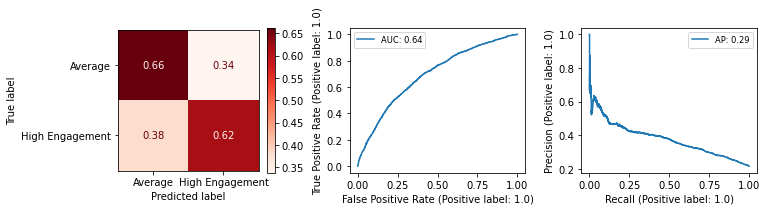

In [778]:
clf_mnb_m = MultinomialNB(fit_prior=False, alpha=0.5)

cv_scores = cross_val_score(clf_mnb_m, X_train_mat_t, y_train_mat, n_jobs=-1, 
                            scoring='recall', verbose=1)
print(np.mean(cv_scores))

clf_mnb_m.fit(X_train_mat_t, y_train_mat)

model_eval.eval_clf_model(clf_mnb_m, X_test_mat_t, y_test_mat, X_train_mat_t, 
            y_train_mat, labels=class_labels, score='std')

### Binary - No lemmas

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished


0.6112091719202467
****************************** Training Data ******************************
              precision    recall  f1-score   support

         0.0       0.90      0.70      0.78     27140
         1.0       0.39      0.72      0.51      7441

    accuracy                           0.70     34581
   macro avg       0.65      0.71      0.65     34581
weighted avg       0.79      0.70      0.73     34581


****************************** Test Data ******************************
              precision    recall  f1-score   support

         0.0       0.86      0.66      0.75      6786
         1.0       0.33      0.62      0.43      1860

    accuracy                           0.65      8646
   macro avg       0.60      0.64      0.59      8646
weighted avg       0.75      0.65      0.68      8646


****************************** Training Scores ******************************
                  Training F1 = [0.7849 0.5075]
              Training Recall = [0.6961 0.7168]
   

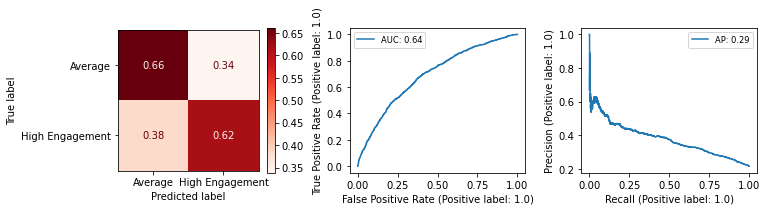

In [779]:
cv_scores = cross_val_score(clf_mnb_m, X_train_mat_t2, y_train_mat, n_jobs=-1, 
                            scoring='recall', verbose=1)
print(np.mean(cv_scores))

clf_mnb_m.fit(X_train_mat_t2, y_train_mat)

model_eval.eval_clf_model(clf_mnb_m, X_test_mat_t2, y_test_mat, X_train_mat_t2, 
            y_train_mat, labels=class_labels, score='std')

### Baseline Multi-class

In [780]:
clf_mnb_m_multi = MultinomialNB(fit_prior=False, alpha=0.5)

clf_mnb_m_multi.fit(X_train_mat_t, y_train_mat_multi)

cv_scores = cross_val_score(clf_mnb_m_multi, X_train_mat_t, y_train_mat_multi, 
                            n_jobs=-1, scoring='recall_macro', verbose=1, )
print(np.mean(cv_scores))

model_eval.eval_clf_model(clf_mnb_m_multi, X_test_mat_t, y_test_mat_multi,  
            X_train_mat_t, y_train_mat_multi, labels=mclass_labels, score='std')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished


0.4974171379104651
****************************** Training Data ******************************
              precision    recall  f1-score   support

         0.0       0.44      0.69      0.53      7275
         1.0       0.77      0.43      0.55     20053
         2.0       0.41      0.67      0.51      7253

    accuracy                           0.53     34581
   macro avg       0.54      0.60      0.53     34581
weighted avg       0.62      0.53      0.54     34581


****************************** Test Data ******************************
              precision    recall  f1-score   support

         0.0       0.37      0.59      0.45      1824
         1.0       0.65      0.35      0.46      5005
         2.0       0.34      0.57      0.43      1817

    accuracy                           0.45      8646
   macro avg       0.45      0.50      0.45      8646
weighted avg       0.53      0.45      0.45      8646


****************************** Training Scores **********************

### Multi-class - No lemmas

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


0.49635785866788745
****************************** Training Data ******************************
              precision    recall  f1-score   support

         0.0       0.44      0.69      0.54      7275
         1.0       0.77      0.43      0.55     20053
         2.0       0.41      0.67      0.51      7253

    accuracy                           0.54     34581
   macro avg       0.54      0.60      0.53     34581
weighted avg       0.62      0.54      0.54     34581


****************************** Test Data ******************************
              precision    recall  f1-score   support

         0.0       0.36      0.58      0.45      1824
         1.0       0.64      0.35      0.45      5005
         2.0       0.34      0.57      0.43      1817

    accuracy                           0.44      8646
   macro avg       0.45      0.50      0.44      8646
weighted avg       0.52      0.44      0.45      8646


****************************** Training Scores *********************

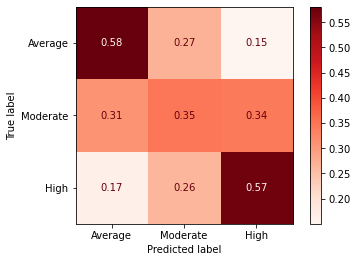

In [781]:
clf_mnb_m_multi.fit(X_train_mat_t2, y_train_mat_multi)

cv_scores = cross_val_score(clf_mnb_m_multi, X_train_mat_t2, y_train_mat_multi, 
                            n_jobs=-1, scoring='recall_macro', verbose=1, )
print(np.mean(cv_scores))

model_eval.eval_clf_model(clf_mnb_m_multi, X_test_mat_t2, y_test_mat_multi,  
            X_train_mat_t2, y_train_mat_multi, labels=mclass_labels, score='std')

## Logistic Regression

### Baseline Binary

Best on previous best hyper params from gridsearching on slightly different targets.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.2s finished


0.5981746066133725
****************************** Training Data ******************************
              precision    recall  f1-score   support

         0.0       0.90      0.71      0.80     27140
         1.0       0.41      0.71      0.52      7441

    accuracy                           0.71     34581
   macro avg       0.65      0.71      0.66     34581
weighted avg       0.79      0.71      0.74     34581


****************************** Test Data ******************************
              precision    recall  f1-score   support

         0.0       0.86      0.69      0.77      6786
         1.0       0.35      0.60      0.44      1860

    accuracy                           0.67      8646
   macro avg       0.61      0.65      0.60      8646
weighted avg       0.75      0.67      0.70      8646


****************************** Training Scores ******************************
                  Training F1 = [0.7964 0.5172]
              Training Recall = [0.7137 0.7131]
   

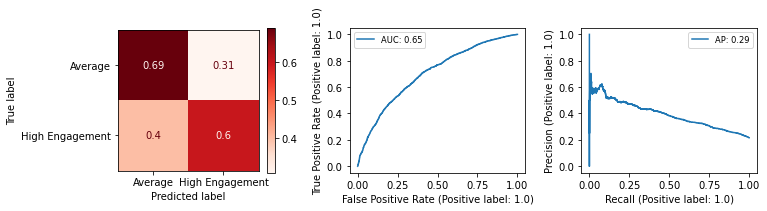

In [782]:
clf_lr_m = LogisticRegression(max_iter=300, 
                            class_weight='balanced',
                            penalty='l2',
                            fit_intercept=False,
                            solver='saga',
                            C=0.1)

clf_lr_m.fit(X_train_mat_t, y_train_mat)

cv_scores = cross_val_score(clf_lr_m, X_train_mat_t, y_train_mat, n_jobs=-1, 
                            scoring='recall', verbose=1)
print(np.mean(cv_scores))

model_eval.eval_clf_model(clf_lr_m, X_test_mat_t, y_test_mat, X_train_mat_t, 
            y_train_mat, labels=class_labels, score='std')

### Binary - No lemmas
### *** Best Matched Binary ***

In [783]:
clf_lr_m.fit(X_train_mat_t2, y_train_mat)

cv_scores = cross_val_score(clf_lr_m, X_train_mat_t2, y_train_mat, n_jobs=-1, 
                            scoring='recall', verbose=1)
print(np.mean(cv_scores))

model_eval.eval_clf_model(clf_lr_m, X_test_mat_t2, y_test_mat, X_train_mat_t2, 
            y_train_mat, labels=class_labels, score='std')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.0s finished


0.5958902019830008
****************************** Training Data ******************************
              precision    recall  f1-score   support

         0.0       0.90      0.71      0.80     27140
         1.0       0.41      0.72      0.52      7441

    accuracy                           0.72     34581
   macro avg       0.65      0.72      0.66     34581
weighted avg       0.80      0.72      0.74     34581


****************************** Test Data ******************************
              precision    recall  f1-score   support

         0.0       0.86      0.70      0.77      6786
         1.0       0.35      0.60      0.44      1860

    accuracy                           0.68      8646
   macro avg       0.61      0.65      0.61      8646
weighted avg       0.75      0.68      0.70      8646


****************************** Training Scores ******************************
                  Training F1 = [0.7976 0.5199]
              Training Recall = [0.7148 0.7166]
   

### Build pipeline for best

In [784]:
txt_trans_pipe = Pipeline([
    ('vect', CountVectorizer(tokenizer=tweettokenizer.tokenize,
                            stop_words=custom_stopwords + custom_punc,
                            ngram_range=(1, 2),
                            max_features=10000)),
    ('tfidf', TfidfTransformer())
])

def no_analyzer(doc):
    return doc

# creating a column transformer to combine OHE of cat cols, basic count
# vectorization of subject, and tokenizing and vectorization of cleaned text
m_cols_trans = ColumnTransformer([
    ('ohe', OneHotEncoder(drop='first'), cat_cols),
    ('txt_kw', CountVectorizer(analyzer=no_analyzer), 'subject'),
    ('txt', txt_trans_pipe, 'cleaned')
])

best_LR_mat_binary_pipe = Pipeline([
    ('cols_trans', m_cols_trans),
    ('clf', LogisticRegression(max_iter=300, 
                            class_weight='balanced',
                            penalty='l2',
                            fit_intercept=False,
                            solver='saga',
                            C=0.1))
])

best_LR_mat_binary_pipe.fit(X_train_mat, y_train_mat)

Pipeline(steps=[('cols_trans',
                 ColumnTransformer(transformers=[('ohe',
                                                  OneHotEncoder(drop='first'),
                                                  ['section_name',
                                                   'word_count_cat',
                                                   'is_multimedia',
                                                   'has_person', 'has_org',
                                                   'has_geo']),
                                                 ('txt_kw',
                                                  CountVectorizer(analyzer=<function no_analyzer at 0x7f989f070820>),
                                                  'subject'),
                                                 ('txt',
                                                  Pipeline(steps=[('vect',
                                                                   CountVectorizer(max_features=10000,
              

### Baseline Multi-class

Best on previous best hyper params from gridsearching on slightly different targets.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.6s finished


0.5025913411309266
****************************** Training Data ******************************
              precision    recall  f1-score   support

         0.0       0.44      0.73      0.55      7275
         1.0       0.78      0.43      0.56     20053
         2.0       0.43      0.69      0.53      7253

    accuracy                           0.55     34581
   macro avg       0.55      0.62      0.55     34581
weighted avg       0.64      0.55      0.55     34581


****************************** Test Data ******************************
              precision    recall  f1-score   support

         0.0       0.36      0.61      0.45      1824
         1.0       0.66      0.35      0.45      5005
         2.0       0.36      0.57      0.44      1817

    accuracy                           0.45      8646
   macro avg       0.46      0.51      0.45      8646
weighted avg       0.53      0.45      0.45      8646


****************************** Training Scores **********************

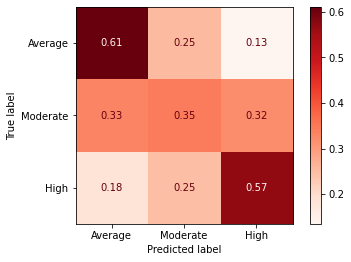

In [785]:
clf_lr_m_multi = LogisticRegression(max_iter=300, 
                            class_weight='balanced',
                            penalty='l2',
                            fit_intercept=False,
                            solver='saga',
                            C=0.1)

clf_lr_m_multi.fit(X_train_mat_t, y_train_mat_multi)

cv_scores = cross_val_score(clf_lr_m_multi, X_train_mat_t, y_train_mat_multi, 
                            n_jobs=-1, scoring='recall_macro', verbose=1)
print(np.mean(cv_scores))

model_eval.eval_clf_model(clf_lr_m_multi, X_test_mat_t, y_test_mat_multi,  
        X_train_mat_t, y_train_mat_multi, labels=mclass_labels, score='std')

### Multi-class - No lemmas
### *** Best Matched Multi ***

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.4s finished


0.5036864970736576
****************************** Training Data ******************************
              precision    recall  f1-score   support

         0.0       0.45      0.73      0.56      7275
         1.0       0.79      0.44      0.57     20053
         2.0       0.44      0.69      0.54      7253

    accuracy                           0.56     34581
   macro avg       0.56      0.62      0.55     34581
weighted avg       0.64      0.56      0.56     34581


****************************** Test Data ******************************
              precision    recall  f1-score   support

         0.0       0.36      0.61      0.45      1824
         1.0       0.65      0.35      0.45      5005
         2.0       0.36      0.57      0.44      1817

    accuracy                           0.45      8646
   macro avg       0.46      0.51      0.45      8646
weighted avg       0.53      0.45      0.45      8646


****************************** Training Scores **********************

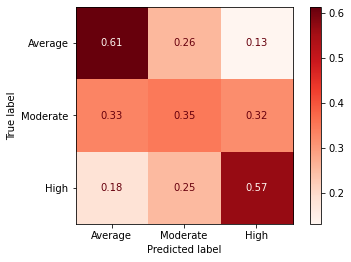

In [786]:
clf_lr_m_multi.fit(X_train_mat_t2, y_train_mat_multi)

cv_scores = cross_val_score(clf_lr_m_multi, X_train_mat_t2, y_train_mat_multi, 
                            n_jobs=-1, scoring='recall_macro', verbose=1)
print(np.mean(cv_scores))

model_eval.eval_clf_model(clf_lr_m_multi, X_test_mat_t2, y_test_mat_multi,  
        X_train_mat_t2, y_train_mat_multi, labels=mclass_labels, score='std')

### Build pipeline for best

In [787]:
best_LR_mat_multi_pipe = Pipeline([
    ('cols_trans', m_cols_trans),
    ('clf', LogisticRegression(max_iter=300, 
                            class_weight='balanced',
                            penalty='l2',
                            fit_intercept=False,
                            solver='saga',
                            C=0.1))
])

best_LR_mat_multi_pipe.fit(X_train_mat, y_train_mat_multi)

Pipeline(steps=[('cols_trans',
                 ColumnTransformer(transformers=[('ohe',
                                                  OneHotEncoder(drop='first'),
                                                  ['section_name',
                                                   'word_count_cat',
                                                   'is_multimedia',
                                                   'has_person', 'has_org',
                                                   'has_geo']),
                                                 ('txt_kw',
                                                  CountVectorizer(analyzer=<function no_analyzer at 0x7f989f070820>),
                                                  'subject'),
                                                 ('txt',
                                                  Pipeline(steps=[('vect',
                                                                   CountVectorizer(max_features=10000,
              

# iNTERPRET

## Best models overview

Binary classifiers performed slightly better on the `High engagement` target than multi-class, although the different is slight. 

Binary classifiers were able to predict about 60% of high engagement posts correctly, and about 70% of average engagement posts correctly. There was little difference in performance between analyzing Facebook text and metadata versus text and metadata from the original NYT articles that I could match.

Multi-class classifiers for all posts using Facebook data were able to predict about 60% of high engagement, 60% of average engagement, and 37% of moderate engagement posts correctly. Classifiers on matched articles were slightly worse at predicting high and moderate engagement, but not by much.

Although the models are not highly accurate, they do all perform quite a bit better on the high/average classes than guessing based on class balance. Rather than pursue more complex models which may achieve better performance but will also be more prone to overfitting on this data and will also be more difficult to interpret, I'm going to use these and see what insights we can get that might be applicable to future data.

In some cases, Multinomial Bayes performed slightly better than Logistic Regression, but again the difference wasn't much. I'm going to use the Logistic Regression models since they are very easy to interpret.

I'm also going to use the versions without lemmatization, as it didn't seem to add much in performance, if anything.

In [788]:
# save out best pipes
joblib.dump(best_LR_all_binary_pipe, 
            f"{save_path}BestPipe_LR_all_binary.joblib.gz")

joblib.dump(best_LR_all_multi_pipe, 
            f"{save_path}BestPipe_LR_all_multi.joblib.gz")

joblib.dump(best_LR_mat_binary_pipe, 
            f"{save_path}BestPipe_LR_mat_binary.joblib.gz")

joblib.dump(best_LR_mat_multi_pipe, 
            f"{save_path}BestPipe_LR_mat_multi.joblib.gz")

['models/BestPipe_LR_mat_multi.joblib.gz']

## Best LR Binary Facebook model

In [789]:
# load it back in from file
best_all_binary_pipe = joblib.load(f"{save_path}BestPipe_LR_all_binary.joblib.gz")


In [860]:
cat_cols = ['post_type', 'hour_cat', 'on_weekend']

# get the feature names from OHE columns
feature_names_ohe = list(best_all_binary_pipe.named_steps['cols_trans']\
    .named_transformers_['ohe'].get_feature_names(cat_cols))

# get the feature names from subject keywords
feature_names_txt = best_all_binary_pipe.named_steps['cols_trans']\
    .named_transformers_['txt'].named_steps['vect'].get_feature_names()

# combine the feature lists
feature_names = feature_names_ohe + feature_names_txt

len(feature_names)

10009

In [861]:
def binary_target_oddsdf(clf, feature_names, class_label, class_int):
    """Generates a dataframe of features from a logistic regression model
    along with odds for that feature.
    
    Feed in a fitted model, list of feature names from get_feature_names() on
    the appropriate transformation step, and the label to use to represent
    the target class.
    
    Specify `class_int` of 0 to get odds of the 0 class, and 1 to get odds of
    the 1 class.
    """
    
    # convert logit coefficients from log odds to odds ratios
    lr_odds = np.exp(clf.coef_[0])
    lr_odds_s = pd.Series(lr_odds, index=feature_names)
    
    # Create dataframe for odds greater than 1 (high engagement). 
    # Higher values represent greater odds of high engagement
    if class_int==1:
        df_odds = np.round(lr_odds_s.loc[lr_odds_s >= 1], 2).to_frame(
            name=class_label)
    elif class_int==0:
        df_odds = np.round(1/(lr_odds_s.loc[lr_odds_s < 1]), 2).to_frame(
            name=class_label)
    else:
        print("Error: `class_int` should be either 0 or 1.")
        return None
        
    df_odds.reset_index(inplace=True)
    df_odds.rename(columns={'index': 'Feature'}, inplace=True)

    # sort the dataframe by frequency
    df_odds.sort_values(by=class_label, ascending=False, inplace=True)
    
    return df_odds

### High Engagement

In [862]:
high_label = 'Odds of High Engagement'

high_eng = binary_target_oddsdf(best_all_binary_pipe.named_steps['clf'], 
                                   feature_names, high_label, class_int=1)
high_eng.head(25)

Feature  Odds of High Engagement
470     breaking news                     7.27
469          breaking                     6.16
3847            trump                     3.44
1049           donald                     3.33
2461             news                     3.17
4138   writes opinion                     3.14
2975           recipe                     2.96
2960     read opinion                     2.89
4097            women                     2.79
373            bernie                     2.79
2519            obama                     2.56
1589              gun                     2.53
3205          sanders                     2.49
2579          opinion                     2.47
4066            white                     2.32
374    bernie sanders                     2.30
3852          trump's                     2.10
1680          hillary                     2.10
1947             kids                     2.07
1625            happy                     2.04
316      barack obama                     2.03
2187              man                     2.01
1681  hillary clinton                     2.00
453               boy                     1.99
315            barack                     1.98

In [863]:
# Create visualizations for words with highest odds of high engagement
nlp_prep.generate_freqs_wordcloud(high_eng, 'Feature', high_label, 
                         cmap="Greens", min_font_size=16)

nlp_prep.plot_wordfreqs(high_eng, 'Feature', high_label, 15, 
               f"Greatest {high_label}")

Of all the Facebook posts, the most common words associated with high engagement are:
- Names associated with the 2016 presidential race, such as Donald Trump, Hillary Clinton, Bernie Sanders, and Obama.
- The phrase `breaking news`
- `Recipe`, which I think mostly refers to recipes
- `read opinion` and `write opinion`, which probably refers to various opinion pieces
- The words `gun`, `women`, and `white`, which sound to me like they could represent the themes of gun violence, gender equality, and racial equality--all of which are hot topics.

### Categorical Features Only

In [864]:
high_eng.loc[high_eng["Feature"].isin(feature_names_ohe)]

Feature  Odds of High Engagement
1             post_type_video                     1.77
0             post_type_photo                     1.52
2  hour_cat_5_Evening (19-23)                     1.28
3              on_weekend_1.0                     1.26

Being a video or photo Facebook post type both increase odds of high engagement compared to a link (which was the category dropped during OHE).

Posting in the evening (from 7 PM to 11 PM Eastern) or on the weekend also increased odds of high engagement somewhat. This may be because new posts would show up in users' feeds when they're online, so they would be seen right away as opposed to being buried under newer posts.

### Average Engagement

In [797]:
avg_label = 'Odds of Average Engagement'

avg_eng = binary_target_oddsdf(best_all_binary_pipe.named_steps['clf'], 
                                   feature_names, avg_label, class_int=0)
avg_eng.head(25)

Feature  Odds of Average Engagement
4028  quotation day                        2.80
4027      quotation                        2.73
1580          ebola                        2.70
5562           week                        2.65
3345            new                        2.45
3479      officials                        2.44
4764         sports                        2.42
24                ?                        2.19
1864        fashion                        2.13
5436          video                        2.13
2194     government                        2.09
5526          watch                        2.01
1910       ferguson                        2.00
3804      political                        1.99
1925          fight                        1.96
4233      residents                        1.93
2013       football                        1.91
4017      questions                        1.91
3326      need know                        1.90
4582          share                        1.88
4842          still                        1.88
2326     here's you                        1.87
5735       you need                        1.87
1191         crisis                        1.86
2913           live                        1.85

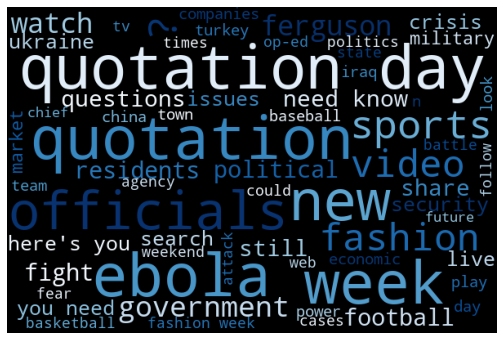

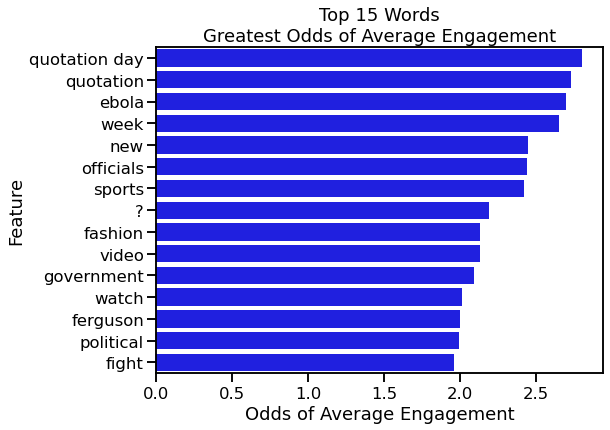

In [795]:
# Create visualizations for words with highest odds of average engagement
nlp_prep.generate_freqs_wordcloud(avg_eng, 'Feature', avg_label, 
                         cmap="Blues", min_font_size=16)

nlp_prep.plot_wordfreqs(avg_eng, 'Feature', avg_label, 15, 
               f"Greatest {avg_label}")

Words and phrases with the highest odds of average engagement are:
- `quotation day`, which is probably `quotation of the day` in full
- `week`, which may be related to weekly recaps or overviews
- `officials`, `government`, and `political`, which sound like terms related to general political happenings
- `ebola`, which is probably related to outbreaks in Africa
- `sports` and `fashion`
- `watch` and `video`
- `ferguson`, which probably refers to the unrest that happened in Ferguson, Missouri in August 2014
- The question mark, which I find interesting.

### Categorical Features Only

In [865]:
avg_eng.loc[avg_eng["Feature"].isin(feature_names_ohe)]

Feature  Odds of Average Engagement
0               post_type_other                        1.28
1     hour_cat_2_Morning (7-11)                        1.19
3  hour_cat_4_Afternoon (15-19)                        1.18
2     hour_cat_3_Midday (11-15)                        1.16
4  hour_cat_6_Late night (23-3)                        1.14

The `Other` post type category consisted of status, event, and note. These have slightly higher odds of resulting in a post with average engagement.

Posting between 7 AM and 7 PM, as well as from 11 PM to 3 AM, have slightly higher odds of average engagement compared to posting very late night (3 AM to 7 AM) which was the category dropped.

## Best LR Article Meta and Text model

In [799]:
# load it back in from file
best_mat_binary_pipe = joblib.load(f"{save_path}BestPipe_LR_mat_binary.joblib.gz")

In [802]:
cat_cols = ['section_name', 'word_count_cat', 'is_multimedia', 'has_person', 
            'has_org', 'has_geo']

# get the feature names from OHE columns
feature_names_ohe = list(best_mat_binary_pipe.named_steps['cols_trans']\
    .named_transformers_['ohe'].get_feature_names(cat_cols))

# get the feature names from subject keywords
feature_names_txt1 = best_mat_binary_pipe.named_steps['cols_trans']\
    .named_transformers_['txt_kw'].get_feature_names()

# add "sub_" to beginning of each subject feature name so they can be told
# apart from article text
feature_names_txt1 = ['sub_' + kw for kw in feature_names_txt1]

# get the feature names from subject keywords
feature_names_txt2 = best_mat_binary_pipe.named_steps['cols_trans']\
    .named_transformers_['txt'].named_steps['vect'].get_feature_names()

# combine the feature lists
feature_names = feature_names_ohe + feature_names_txt1 + feature_names_txt2

len(feature_names)

13273

### High Engagement

In [812]:
high_eng_art = binary_target_oddsdf(best_mat_binary_pipe.named_steps['clf'], 
                                   feature_names, high_label, class_int=1)
high_eng_art.head(25)

Feature  Odds of High Engagement
3943                                 obama                     2.95
0                     section_name_Cooking                     2.90
72        sub_archaeology and anthropology                     2.32
4667                               sanders                     2.19
916      sub_presidential election of 2016                     2.16
5347                                 trump                     2.12
4258                             president                     2.09
218                               sub_cats                     2.04
2431                                donald                     1.99
1690                                bernie                     1.97
1240                           sub_walking                     1.93
557                          sub_happiness                     1.89
832               sub_olympic games (2016)                     1.88
342                sub_deaths (obituaries)                     1.88
782                   sub_muslim americans                     1.84
250   sub_chronic traumatic encephalopathy                     1.84
552                               sub_hair                     1.83
635                             sub_iphone                     1.81
133                    sub_beauty contests                     1.81
474                  sub_first ladies (us)                     1.79
1691                        bernie sanders                     1.78
56    sub_animal abuse, rights and welfare                     1.77
721                        sub_mathematics                     1.77
5630                               world's                     1.75
306           sub_cosmetics and toiletries                     1.75

I see an interesting mix of predictors of high engagement from the matched articles model. The subject metadata definitely made the results differ from the Facebook post data, in which we didn't have subjects.

- As with the Facebook model, words and phrases related to the president and election are top predictors. The subject "Presidential Election of 2016" is also a top predictor.
- Apart from that, we have a pretty eclectic mix of subjects. Some are fairly neutral topics that people probably don't have strong feelings about: Cooking, Archeology and Anthropology, Cats, Walking, Happiness, Mathematics, iPhone.
- Other subjects may be controversial, or at the least subjects that people tend to have strong feelings about: Muslim Americans, Animal Abuse, Rights and Welfare
- Another trend in top subjects is beauty related: Hair, Beauty Contests, Cosmetics and Toiletries
- Although Sports was a top predictor of average engagement in the Facebook model, the 2016 Olympics was a top subject here
- Deaths and Obituaries are also a top predictor of high engagement, which I had seen during EDA

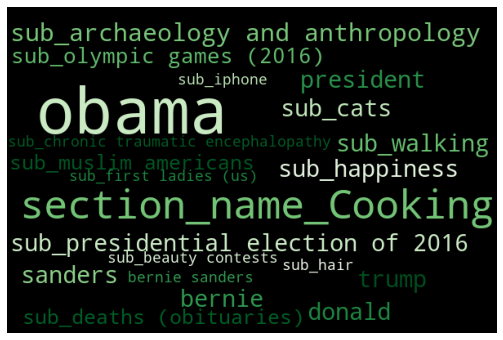

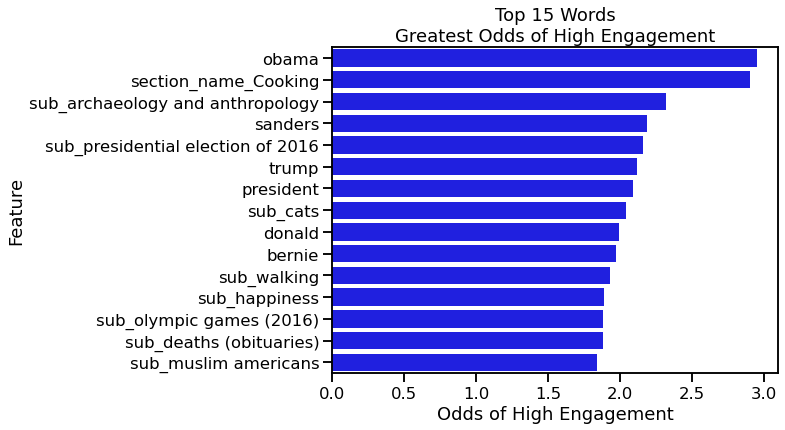

In [804]:
# Create visualizations for words with highest odds of high engagement
nlp_prep.generate_freqs_wordcloud(high_eng_art, 'Feature', high_label, 
                         cmap="Greens", min_font_size=16)

nlp_prep.plot_wordfreqs(high_eng_art, 'Feature', high_label, 15, 
               f"Greatest {high_label}")

### Categorical Features Only

In [805]:
high_eng_art.loc[high_eng_art["Feature"].isin(feature_names_ohe)]

Feature  Odds of High Engagement
0      section_name_Cooking                     2.90
5       section_name_Travel                     1.22
6        word_count_cat_Low                     1.14
4        section_name_Style                     1.13
2      section_name_Opinion                     1.12
8              has_person_1                     1.10
7       word_count_cat_None                     1.08
3  section_name_Real Estate                     1.04
1      section_name_NYT Now                     1.02
9                 has_geo_1                     1.01

Cooking is by far the most popular section, followed by Travel, Style, and Opinion.

Low word count means slightly higher odds of being higher engagement, but not much.

### Subject KWs Only

In [806]:
high_eng_art.loc[high_eng_art["Feature"].isin(feature_names_txt1)].head(25)

Feature  Odds of High Engagement
72             sub_archaeology and anthropology                     2.32
916           sub_presidential election of 2016                     2.16
218                                    sub_cats                     2.04
1240                                sub_walking                     1.93
557                               sub_happiness                     1.89
832                    sub_olympic games (2016)                     1.88
342                     sub_deaths (obituaries)                     1.88
782                        sub_muslim americans                     1.84
250        sub_chronic traumatic encephalopathy                     1.84
552                                    sub_hair                     1.83
635                                  sub_iphone                     1.81
133                         sub_beauty contests                     1.81
474                       sub_first ladies (us)                     1.79
56         sub_animal abuse, rights and welfare                     1.77
721                             sub_mathematics                     1.77
306                sub_cosmetics and toiletries                     1.75
1211           sub_vaccination and immunization                     1.74
272                                  sub_coffee                     1.72
1189                                sub_tuition                     1.68
614                           sub_immune system                     1.67
742   sub_middle east and africa migrant crisis                     1.67
783                          sub_muslim veiling                     1.67
1263                        sub_women and girls                     1.67
717                               sub_marriages                     1.64
548                             sub_gun control                     1.64

### Average Engagement

In [813]:
avg_eng_art = binary_target_oddsdf(best_mat_binary_pipe.named_steps['clf'], 
                                   feature_names, avg_label, class_int=0)
avg_eng_art.head(25)

Feature  \
1141                      sub_midterm elections (2014)   
1160                           sub_mobile applications   
146         sub_automobile safety features and defects   
4927                                               may   
3800                                          ferguson   
556                                    sub_ebola virus   
1192                 sub_murders and attempted murders   
15                             section_name_Technology   
4059                                        government   
1140  sub_middle east and north africa unrest (2010- )   
1384                       sub_politics and government   
1                                   section_name_Books   
1382                         sub_political advertising   
2264                                               art   
1771                               sub_tests (medical)   
132                           sub_athletics and sports   
550                                     sub_e-commerce   
6311                                          security   
5202                                               new   
979                                    sub_jury system   
246                  sub_brussels attacks (march 2016)   
65                sub_alternative and renewable energy   
6293                                            season   
9                       section_name_Multimedia/Photos   
3900                                            forces   

      Odds of Average Engagement  
1141                        2.69  
1160                        2.16  
146                         2.16  
4927                        2.07  
3800                        2.05  
556                         2.00  
1192                        1.99  
15                          1.95  
4059                        1.90  
1140                        1.88  
1384                        1.87  
1                           1.84  
1382                        1.82  
2264                        1.80  
1771                        1.80  
132                         1.79  
550                         1.78  
6311                        1.77  
5202                        1.75  
979                         1.74  
246                         1.74  
65                          1.73  
6293                        1.72  
9                           1.72  
3900                        1.70

- Although the presidential election was a top predictor of high engagement, general words such as `government`, and subjects such as 2014 Midterm Elections, Political Advertising, Jury System, and Politics and Government are top predictors of Average engagement. My reading of this is that the competition of the presidential election drew people in, but every day political events are less engaging.
- Some top predictors are also far away from the US, such as Ebola Virus, Middle East and North Africa Unrest, Brussels Attacks.
- Interestingly, the subject Multimedia/Photos is a top predictor of average, although when looking at the types of Facebook posts videos and photos seemed to get more engagement. It may be there is a difference between these classifications.

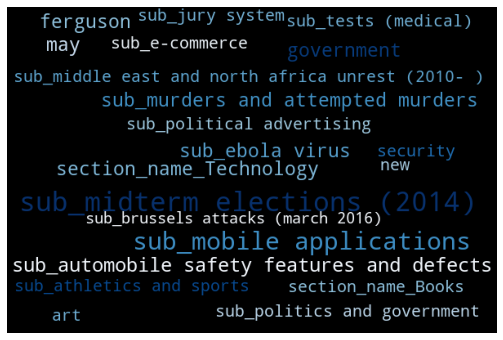

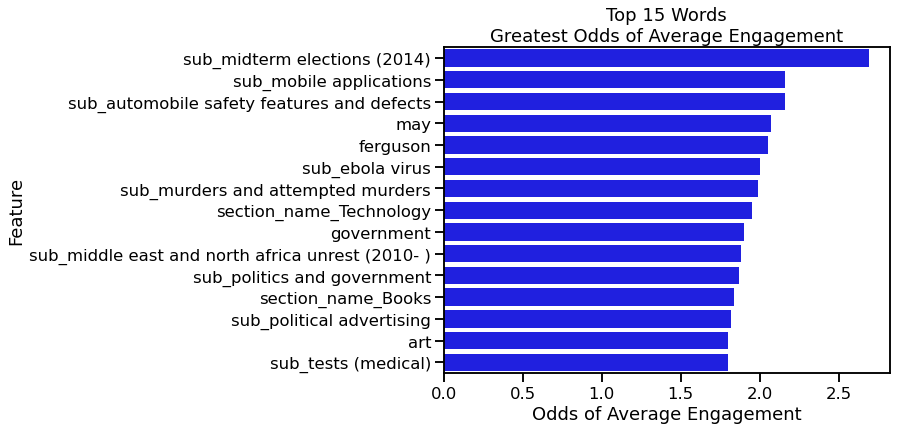

In [809]:
# Create visualizations for words with highest odds of average engagement
nlp_prep.generate_freqs_wordcloud(avg_eng_art, 'Feature', avg_label, 
                         cmap="Blues", min_font_size=16)

nlp_prep.plot_wordfreqs(avg_eng_art, 'Feature', avg_label, 15, 
               f"Greatest {avg_label}")

### Categorical Features Only

In [810]:
avg_eng_art.loc[avg_eng_art["Feature"].isin(feature_names_ohe)]

Feature  Odds of Average Engagement
15         section_name_Technology                        1.95
1               section_name_Books                        1.84
9   section_name_Multimedia/Photos                        1.72
0               section_name_Blogs                        1.70
10           section_name_New York                        1.70
3           section_name_Education                        1.64
13             section_name_Sports                        1.61
12            section_name_Science                        1.58
19              section_name_World                        1.54
5                section_name_Food                        1.53
17            section_name_Theater                        1.53
2        section_name_Business Day                        1.43
16         section_name_The Upshot                        1.34
20         section_name_Your Money                        1.31
14         section_name_T Magazine                        1.27
18               section_name_U.S.                        1.20
11              section_name_Other                        1.19
4     section_name_Fashion & Style                        1.18
8              section_name_Movies                        1.16
6              section_name_Health                        1.14
7            section_name_Magazine                        1.10
22               is_multimedia_1.0                        1.08
23                       has_org_1                        1.07
21             word_count_cat_High                        1.04

### Subject KWs Only

In [811]:
avg_eng_art.loc[avg_eng_art["Feature"].isin(feature_names_txt1)].head(25)

Feature  \
1141                      sub_midterm elections (2014)   
1160                           sub_mobile applications   
146         sub_automobile safety features and defects   
556                                    sub_ebola virus   
1192                 sub_murders and attempted murders   
1140  sub_middle east and north africa unrest (2010- )   
1384                       sub_politics and government   
1382                         sub_political advertising   
1771                               sub_tests (medical)   
132                           sub_athletics and sports   
550                                     sub_e-commerce   
979                                    sub_jury system   
246                  sub_brussels attacks (march 2016)   
65                sub_alternative and renewable energy   
610            sub_espionage and intelligence services   
1289                               sub_organized labor   
504                                      sub_detainees   
1524                                   sub_rural areas   
1576                 sub_september fashion week (2014)   
1288                               sub_organized crime   
425        sub_coups d'etat and attempted coups d'etat   
296                                     sub_censorship   
470             sub_data-mining and database marketing   
1280                                         sub_opera   
1628                  sub_social networking (internet)   

      Odds of Average Engagement  
1141                        2.69  
1160                        2.16  
146                         2.16  
556                         2.00  
1192                        1.99  
1140                        1.88  
1384                        1.87  
1382                        1.82  
1771                        1.80  
132                         1.79  
550                         1.78  
979                         1.74  
246                         1.74  
65                          1.73  
610                         1.69  
1289                        1.67  
504                         1.67  
1524                        1.67  
1576                        1.65  
1288                        1.65  
425                         1.64  
296                         1.64  
470                         1.63  
1280                        1.63  
1628                        1.63

## FB - Review Prediction Accuracy

In [814]:
# Get predictions for X (binary problem)
preds_all = best_all_binary_pipe.predict(X_test_all)

In [818]:
Xtest_all_df = X_test_all.copy()
Xtest_all_df['fb_pred'] = preds_all
Xtest_all_df.tail()

cleaned post_type  \
39417  Yes, There's Doping in Sports, but Do Fans Rea...      link   
28863  Guarding the Prison Guards: New York State's T...      link   
9434   U. S. Says Russia Tested Cruise Missile in Vio...      link   
6153   Your Ancestors, Your Fate. "The compulsion to ...      link   
773    A Quest to Reclaim the World Speed Record : Ki...     video   

                  hour_cat  on_weekend  fb_pred  
39417     2_Morning (7-11)         0.0      0.0  
28863     3_Midday (11-15)         1.0      0.0  
9434     5_Evening (19-23)         0.0      1.0  
6153   4_Afternoon (15-19)         0.0      0.0  
773      5_Evening (19-23)         0.0      1.0

In [823]:
df = df.join(Xtest_all_df[['fb_pred']])
df[['cleaned', 'fb_pred', 'all_binary']].head()

cleaned  fb_pred  all_binary
0  Did Barack Obama Save Ohio?. 'There are severa...      NaN         0.0
1  The Weatherman Is Not a Moron. In , the chance...      NaN         0.0
2  The Organic Fable. 'Organic has long since bec...      NaN         0.0
3  Timeline Photos. Our special Arts & Leisure se...      NaN         0.0
4  Pot for Parents. 'When I'm rolling around the ...      NaN         0.0

In [824]:
predict_cols = ['cleaned', 'fb_pred', 'all_binary',
            'max_pct', 'mean_pct', 'comments_pct', 'comments_count',  
            'shares_pct', 'shares_count', 'likesloves_pct', 'likes_loves']

df.loc[df['fb_pred'].isna()==False, predict_cols]

cleaned  fb_pred  all_binary  \
5      Timeline Photos. During a surprise visit to Ga...      1.0         1.0   
21     Romney's Tax Plan Leaves Key Variables Blank -...      0.0         0.0   
23     'Soda Ban Explained'. Weighing in at just over...      0.0         0.0   
26     Jessica Chastain TimesTalks Live Webcast. Watc...      0.0         0.0   
31     Teachers' Strike in Chicago Tests Mayor and Un...      0.0         0.0   
...                                                  ...      ...         ...   
47827  Your Monday Briefing. Daily Briefing: Here's w...      0.0         0.0   
47828  Donald Trump's Extremist Supporters Feel Like ...      1.0         1.0   
47829  The Biggest Turning Points in a Polarizing Cam...      1.0         0.0   
47830  After Bill Cosby, States Shift on Statutes of ...      0.0         0.0   
47836  Media's Next Challenge: Overcoming the Threat ...      0.0         1.0   

        max_pct  mean_pct  comments_pct  comments_count  shares_pct  \
5      0.967284  0.949853      0.947155             594    0.935121   
21     0.668846  0.325241      0.668846             127    0.248527   
23     0.528465  0.309266      0.528465              80    0.282957   
26     0.024506  0.013096      0.024506               7    0.006069   
31     0.274234  0.201173      0.274234              36    0.182750   
...         ...       ...           ...             ...         ...   
47827  0.456733  0.181562      0.456733              64    0.049576   
47828  0.955072  0.840228      0.955072             657    0.950748   
47829  0.524381  0.234345      0.524381              79    0.115813   
47830  0.346373  0.286849      0.312006              41    0.202169   
47836  0.991685  0.974916      0.966082             786    0.991685   

       shares_count  likesloves_pct  likes_loves  
5              1459        0.967284         9012  
21               57        0.058350          138  
23               66        0.116377          201  
26                0        0.008712           51  
31               42        0.146534          230  
...             ...             ...          ...  
47827            15        0.038378          113  
47828          1810        0.614862          992  
47829            29        0.062842          143  
47830            46        0.346373          452  
47836          5702        0.966981         8956  

[9574 rows x 11 columns]

### Was High, predicted Average

In [825]:
total = len(df.loc[df['fb_pred'].isna()==False])
print(total)

total_wrong = len(df.loc[(df['all_binary']==1) & (df['fb_pred']==0)])
total_wrong

9574


799

In [828]:
df.loc[(df['all_binary']==1) & (df['fb_pred']==0), predict_cols].describe()

fb_pred  all_binary     max_pct    mean_pct  comments_pct  \
count    799.0       799.0  799.000000  799.000000    799.000000   
mean       0.0         1.0    0.917997    0.846320      0.821240   
std        0.0         0.0    0.053715    0.066034      0.117364   
min        0.0         1.0    0.764311    0.750341      0.465905   
25%        0.0         1.0    0.879727    0.790255      0.744307   
50%        0.0         1.0    0.926629    0.834221      0.834663   
75%        0.0         1.0    0.961162    0.896048      0.917415   
max        0.0         1.0    0.999854    0.998447      0.999708   

       comments_count  shares_pct  shares_count  likesloves_pct    likes_loves  
count      799.000000  799.000000    799.000000      799.000000     799.000000  
mean       415.103880    0.867254   1423.765957        0.850466    4938.385482  
std        589.342848    0.089215   3126.180011        0.097398    8599.558549  
min         66.000000    0.560492    185.000000        0.516703     736.000000  
25%        169.000000    0.814158    563.500000        0.786738    1915.500000  
50%        253.000000    0.882923    880.000000        0.863128    2921.000000  
75%        441.000000    0.939221   1539.500000        0.929318    5064.000000  
max       8841.000000    0.999854  80033.000000        0.999770  178813.000000

799 of the 9,574 posts in the test set were incorrectly classified as average engagement although they should have been high (defined as average engagement metric percentile being above 75th). 

The percentiles for comments, shares, and likes/loves are all consistently above 75, so I don't see any particular patterns. The model just wasn't able to pick up on whatever trends these represented.

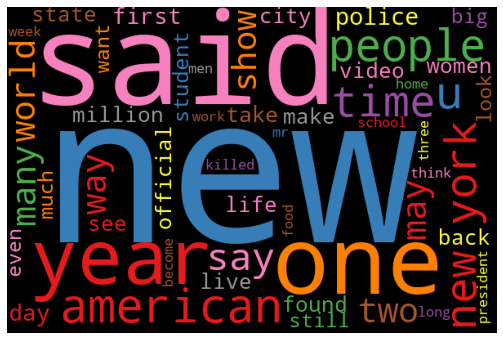

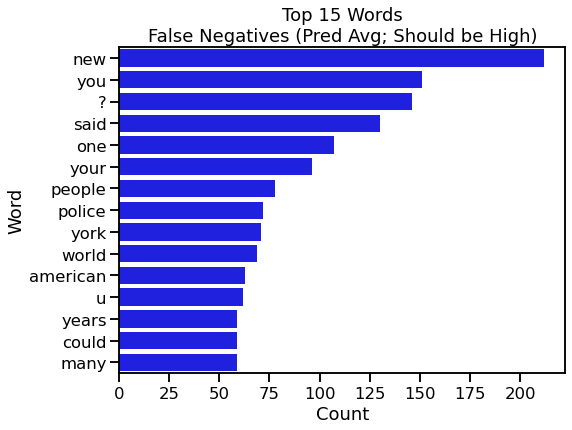

In [844]:
# False Negatives word frequencies
fn_token_dict = nlp_prep.tokenize_corpus_dict_tweet(
    df.loc[(df['all_binary']==1) & (df['fb_pred']==0)], [0, 1], 
    target_col='all_binary', stop_list=custom_stopwords + custom_punc, 
                                                 verbose=False)

fn_tokens = []
[fn_tokens.extend(tokens) for tokens in fn_token_dict.values()]

fn_corpus = FreqDist(fn_tokens)

fn_freq_df = pd.DataFrame(fn_corpus.most_common(100),
                              columns=['Word','Count'])

nlp_prep.generate_wordcloud(docs=fn_tokens, cmap="Set1", 
                   stopwords=None, min_font_size=16, 
                  title='')

nlp_prep.plot_wordfreqs(fn_freq_df, 'Word', 'Count', 15, 
               "False Negatives (Pred Avg; Should be High)")

Even though I removed the you/your permutations from the stopwords list during modeling, the models still didn't pick up on those words being predictors of High engagement. I see here that you and your appear frequently in the posts that should have been classified as High but were mis-classified as Average. It's possible that TF-IDF normalization worked against me in that regard.

Otherwise, the top words look pretty average to me.

### Was Average, predicted High

In [829]:
print(total)

total_wrong2 = len(df.loc[(df['all_binary']==0) & (df['fb_pred']==1)])
total_wrong2

9574


2408

In [830]:
df.loc[(df['all_binary']==0) & (df['fb_pred']==1), predict_cols].describe()

fb_pred  all_binary      max_pct     mean_pct  comments_pct  \
count   2408.0      2408.0  2408.000000  2408.000000   2408.000000   
mean       1.0         0.0     0.622215     0.472416      0.490534   
std        0.0         0.0     0.219749     0.189760      0.250620   
min        1.0         0.0     0.015376     0.009112      0.000460   
25%        1.0         0.0     0.483026     0.333076      0.297476   
50%        1.0         0.0     0.669839     0.506010      0.498015   
75%        1.0         0.0     0.791470     0.629934      0.686030   
max        1.0         0.0     0.993137     0.749836      0.993137   

       comments_count   shares_pct  shares_count  likesloves_pct  likes_loves  
count     2408.000000  2408.000000   2408.000000     2408.000000  2408.000000  
mean       114.219269     0.452410    185.307724        0.474305   896.302741  
std        134.034730     0.235536    174.414373        0.230030   794.879735  
min          0.000000     0.006069      0.000000        0.000731     9.000000  
25%         39.000000     0.267695     62.000000        0.299291   393.750000  
50%         73.000000     0.469911    132.500000        0.493127   689.000000  
75%        135.000000     0.644351    256.000000        0.660364  1158.000000  
max       1883.000000     0.945473   1673.000000        0.961497  8031.000000

2,408 of the 9,574 posts in the test set were incorrectly classified as high engagement although they should have been average (defined as average engagement metric percentile being below 75th). 

The percentiles for comments, shares, and likes/loves are all consistently below 75, so I don't see any particular patterns.

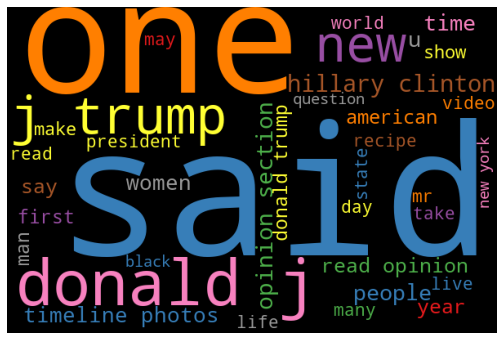

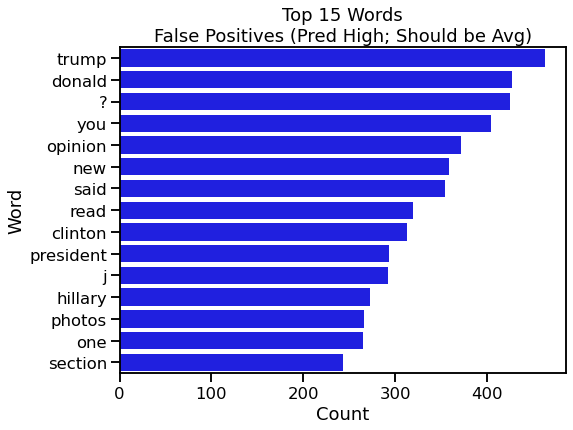

In [845]:
# False Positives word frequencies
fp_token_dict = nlp_prep.tokenize_corpus_dict_tweet(
    df.loc[(df['all_binary']==0) & (df['fb_pred']==1)], [0, 1], 
    target_col='all_binary', stop_list=custom_stopwords + custom_punc, 
                                                 verbose=False)

fp_tokens = []
[fp_tokens.extend(tokens) for tokens in fp_token_dict.values()]

fp_corpus = FreqDist(fp_tokens)

fp_freq_df = pd.DataFrame(fp_corpus.most_common(100),
                              columns=['Word','Count'])

nlp_prep.generate_wordcloud(docs=fp_tokens, cmap="Set1", 
                   stopwords=None, min_font_size=16, 
                  title='False Positives (should be Avg)')

nlp_prep.plot_wordfreqs(fp_freq_df, 'Word', 'Count', 15, 
               "False Positives (Pred High; Should be Avg)")

I see lots of mentions of presidential stuff (Trump, Clinton, President), as well as Opinion. I can see why these might have been mis-classified as High even though they were Average.

## Matched - Review Prediction Accuracy

In [846]:
# Get predictions for X (binary problem)
preds_mat = best_mat_binary_pipe.predict(X_test_mat)

In [847]:
Xtest_mat_df = X_test_mat.copy()
Xtest_mat_df['mat_pred'] = preds_mat
Xtest_mat_df.tail()

cleaned  \
10539  Scouting the Scene. Intent on getting it right...   
12405  How Cigarettes and Sexual Frustration Got Me T...   
22124  No Labels, No Drama, Right?. The winner of thi...   
9098   Don't Laugh: Berkeley Plans to Give Free Marij...   
40855  Looking the Orlando Shooter in the Eyes. Tiara...   

                                                 subject section_name  \
10539  [restaurants, mexican food (cuisine), cooking ...         Food   
12405         [new york city marathon, marathon running]       Sports   
22124  [modern love (times column), dating and relati...        Style   
9098   [marijuana, medical marijuana, law and legisla...   The Upshot   
40855         [orlando, fla, shooting (2016), terrorism]         U.S.   

      word_count_cat  is_multimedia  has_person  has_org  has_geo  mat_pred  
10539           High            0.0           1        1        1       0.0  
12405           High            0.0           0        0        1       0.0  
22124           High            0.0           0        0        0       1.0  
9098             Low            0.0           0        1        1       0.0  
40855           None            1.0           1        0        0       1.0

In [851]:
df = df.join(Xtest_mat_df[['mat_pred']])
df[['cleaned', 'mat_pred', 'm_binary']].head()

cleaned  mat_pred  m_binary
0  Did Barack Obama Save Ohio?. 'There are severa...       0.0       0.0
1  The Weatherman Is Not a Moron. In , the chance...       NaN       0.0
2  The Organic Fable. 'Organic has long since bec...       1.0       0.0
3  Timeline Photos. Our special Arts & Leisure se...       NaN       0.0
4  Pot for Parents. 'When I'm rolling around the ...       NaN       0.0

In [852]:
predict_cols = ['cleaned', 'mat_pred', 'm_binary',
            'max_pct', 'mean_pct', 'comments_pct', 'comments_count',  
            'shares_pct', 'shares_count', 'likesloves_pct', 'likes_loves']

df.loc[df['mat_pred'].isna()==False, predict_cols]

cleaned  mat_pred  m_binary  \
0      Did Barack Obama Save Ohio?. 'There are severa...       0.0       0.0   
2      The Organic Fable. 'Organic has long since bec...       1.0       0.0   
5      Timeline Photos. During a surprise visit to Ga...       1.0       1.0   
6      Debt Collectors Cashing In on Student Loan Rou...       1.0       0.0   
16     A Tight Election May Be Tangled in Legal Battl...       0.0       0.0   
...                                                  ...       ...       ...   
47845  The Chopped Cheese's Sharp Rise to Fame. Grab ...       0.0       0.0   
47854  An Unfinished Presidency: Obama Passes the Bat...       1.0       1.0   
47860  Woman Thrown in Front of Train at Times Square...       0.0       1.0   
47861  'Westworld' Season , Episode : The Tipping Poi...       0.0       0.0   
47865  Harry Belafonte: What Do We Have to Lose? Ever...       1.0       1.0   

        max_pct  mean_pct  comments_pct  comments_count  shares_pct  \
0      0.334089  0.313796      0.334089              44    0.291167   
2      0.858710  0.722702      0.858710             290    0.759057   
5      0.967284  0.949853      0.947155             594    0.935121   
6      0.502789  0.354319      0.502789              74    0.383727   
16     0.147046  0.118435      0.094942              16    0.147046   
...         ...       ...           ...             ...         ...   
47845  0.392763  0.286710      0.392763              53    0.305833   
47854  0.860705  0.755721      0.860705             294    0.592675   
47860  0.985992  0.861715      0.985992            1318    0.955386   
47861  0.436552  0.297020      0.282058              37    0.172450   
47865  0.979735  0.903160      0.764311             183    0.979735   

       shares_count  likesloves_pct  likes_loves  
0                68        0.316133          413  
2               421        0.550338          812  
5              1459        0.967284         9012  
6                96        0.176440          260  
16               35        0.113316          198  
...             ...             ...          ...  
47845            72        0.161534          245  
47854           209        0.813782         2190  
47860          1936        0.643766         1093  
47861            40        0.436552          586  
47865          3283        0.965435         8673  

[8646 rows x 11 columns]

### Was High, predicted Average

In [853]:
total = len(df.loc[df['mat_pred'].isna()==False])
print(total)

total_wrong = len(df.loc[(df['m_binary']==1) & (df['mat_pred']==0)])
total_wrong

8646


744

In [854]:
df.loc[(df['m_binary']==1) & (df['mat_pred']==0), predict_cols].describe()

mat_pred  m_binary     max_pct    mean_pct  comments_pct  \
count     744.0     744.0  744.000000  744.000000    744.000000   
mean        0.0       1.0    0.914620    0.845018      0.825360   
std         0.0       0.0    0.054224    0.065848      0.110026   
min         0.0       1.0    0.754178    0.745104      0.493482   
25%         0.0       1.0    0.876551    0.789565      0.755865   
50%         0.0       1.0    0.921129    0.838140      0.845799   
75%         0.0       1.0    0.958413    0.897050      0.910524   
max         0.0       1.0    0.999687    0.998127      0.999102   

       comments_count  shares_pct  shares_count  likesloves_pct   likes_loves  
count      744.000000  744.000000    744.000000      744.000000    744.000000  
mean       376.838710    0.862559   1419.986559        0.847135   4630.626344  
std        419.479683    0.093682   2543.144601        0.101777   5765.554028  
min         72.000000    0.445817    121.000000        0.495665    694.000000  
25%        176.500000    0.813618    561.750000        0.788809   1935.750000  
50%        269.000000    0.875642    831.000000        0.863818   2932.000000  
75%        415.500000    0.933828   1433.750000        0.926456   4898.000000  
max       4647.000000    0.999687  43953.000000        0.998454  59206.000000

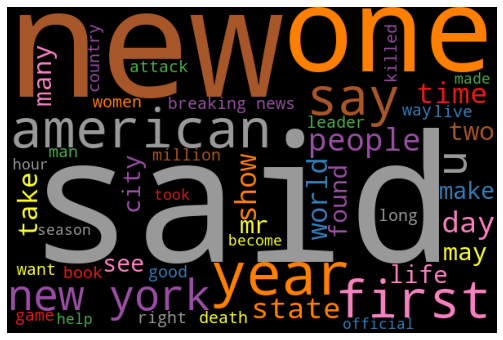

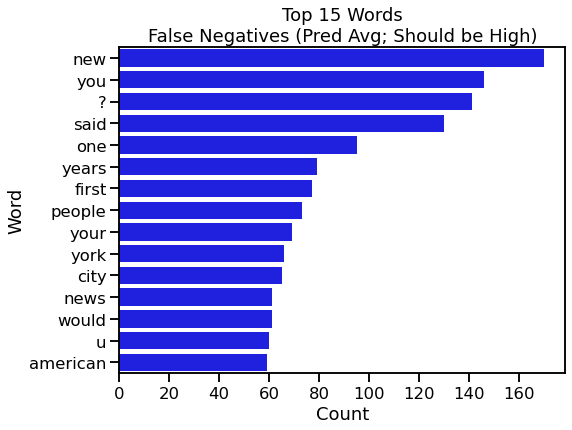

In [855]:
# False Negatives word frequencies
fn_token_dict = nlp_prep.tokenize_corpus_dict_tweet(
    df.loc[(df['m_binary']==1) & (df['mat_pred']==0)], [0, 1], 
    target_col='m_binary', stop_list=custom_stopwords + custom_punc, 
                                                 verbose=False)

fn_tokens = []
[fn_tokens.extend(tokens) for tokens in fn_token_dict.values()]

fn_corpus = FreqDist(fn_tokens)

fn_freq_df = pd.DataFrame(fn_corpus.most_common(100),
                              columns=['Word','Count'])

nlp_prep.generate_wordcloud(docs=fn_tokens, cmap="Set1", 
                   stopwords=None, min_font_size=16, 
                  title='')

nlp_prep.plot_wordfreqs(fn_freq_df, 'Word', 'Count', 15, 
               "False Negatives (Pred Avg; Should be High)")

Even though I removed the you/your permutations from the stopwords list during modeling, the models still didn't pick up on those words being predictors of High engagement. I see here that you and your appear frequently in the posts that should have been classified as High but were mis-classified as Average. It's possible that TF-IDF normalization worked against me in that regard.

Otherwise, the top words look pretty average to me.

### Was Average, predicted High

In [857]:
print(total)

total_wrong2 = len(df.loc[(df['m_binary']==0) & (df['mat_pred']==1)])
total_wrong2

8646


2065

In [858]:
df.loc[(df['m_binary']==0) & (df['mat_pred']==1), predict_cols].describe()

mat_pred  m_binary      max_pct     mean_pct  comments_pct  \
count    2065.0    2065.0  2065.000000  2065.000000   2065.000000   
mean        1.0       0.0     0.626703     0.476168      0.500640   
std         0.0       0.0     0.210526     0.182972      0.244214   
min         1.0       0.0     0.006069     0.002594      0.000460   
25%         1.0       0.0     0.502904     0.345635      0.304653   
50%         1.0       0.0     0.673631     0.508618      0.512044   
75%         1.0       0.0     0.785787     0.625928      0.690083   
max         1.0       0.0     0.979589     0.746563      0.979589   

       comments_count   shares_pct  shares_count  likesloves_pct  likes_loves  
count     2065.000000  2065.000000   2065.000000     2065.000000  2065.000000  
mean       113.471186     0.467190    189.791768        0.460674   829.860533  
std        120.226249     0.223097    169.862656        0.227270   661.650450  
min          0.000000     0.006069      0.000000        0.000439     7.000000  
25%         40.000000     0.298824     70.000000        0.281567   373.000000  
50%         76.000000     0.489397    142.000000        0.478241   660.000000  
75%        137.000000     0.644351    256.000000        0.648644  1112.000000  
max       1061.000000     0.912422   1128.000000        0.953809  7071.000000

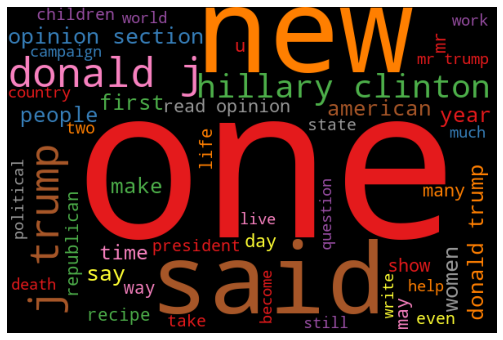

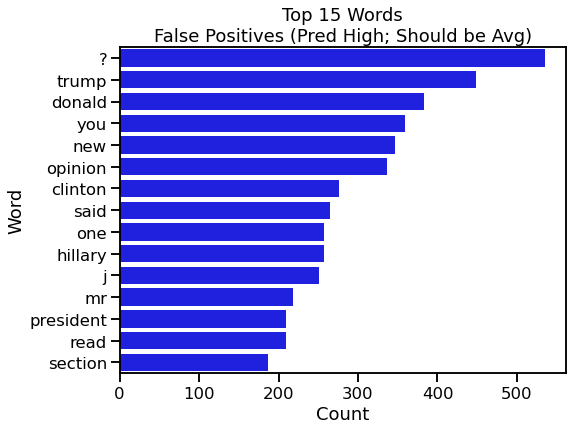

In [859]:
# False Positives word frequencies
fp_token_dict = nlp_prep.tokenize_corpus_dict_tweet(
    df.loc[(df['m_binary']==0) & (df['mat_pred']==1)], [0, 1], 
    target_col='m_binary', stop_list=custom_stopwords + custom_punc, 
                                                 verbose=False)

fp_tokens = []
[fp_tokens.extend(tokens) for tokens in fp_token_dict.values()]

fp_corpus = FreqDist(fp_tokens)

fp_freq_df = pd.DataFrame(fp_corpus.most_common(100),
                              columns=['Word','Count'])

nlp_prep.generate_wordcloud(docs=fp_tokens, cmap="Set1", 
                   stopwords=None, min_font_size=16, 
                  title='False Positives (should be Avg)')

nlp_prep.plot_wordfreqs(fp_freq_df, 'Word', 'Count', 15, 
               "False Positives (Pred High; Should be Avg)")

I see lots of mentions of presidential stuff (Trump, Clinton, President), as well as Opinion. I can see why these might have been mis-classified as High even though they were Average.

### Performance Insights

The binary classifiers performed slightly better than the multi-class, but looking at the confusion matrices for the multi-class classifiers, they show that High and Average posts are most often classified as Moderate.

I think one challenge to achieve better performance with these models is that there is no clear delineation between High engagement and any other level. I chose a reasonable cutoff point, but it could easily have been drawn elsewhere. Initially I also tried calling outliers in terms of any engagement category high engagement, but that didn't perform any better. The engagement metric distributions all had a pretty smooth taper off, so I'm not surprised that the models uniformly got confused.

The posts that were misclassified in both the Facebook and the matched article models shared most frequent words in common with the other class, so I can see why the models got confused.

Facebook has its own algorithm that ultimately decides what content is presented to users in their feed in what priority. I think it's likely the effect of their algorithm (which we can't model here) is the reason some posts got less engagement than others with similar words and topics.

Since the two models based on slightly different text agreed on many words, I think that although these models didn't achieve a high degree of accuracy, they did pick up on the strongest signals in the data. Because they only picked up on the strongest signals, with a little interpretation I think the results will be fairly applicable to future articles.

However, since the specific terms associated with topical themes will differ over time (candidates for a given presidential election year, for example) the model would probably not be very accurate in predicting future high engagement articles unless it was continually retrained. I believe that a general understanding of the topics and themes of highly engaging content is much more useful than using the model itself to choose which articles to post.

# CONCLUSIONS & RECOMMENDATIONS

## Highly Engaging Topics

### Divisive Topics
- 2016 presidential election
- Opinion pieces
- Pieces involving gun violence, racial justice and equality, and gender equality

### Timely topics
- Breaking news

### Other neutral topics can also be engaging
- Obituaries
- Recipes
- Health and Beauty

## How and When posts are added to Facebook makes a difference
- Posting as a video or photo gets more high engagement than posting a regular message with a link to the article (even though most of these do also have photos). The ultimate format of the content (whether the piece is an article, video, interactive, etc) is less relevant than how the content is presented on Facebook.
- Posting in the evening (7 PM to 11 PM) and on weekends increased odds of high engagement compared to other times of day and week.

## Less engaging

- Although the US 2016 presidential election was highly engaging, general political content is less so.
- Recurring posts, such as info to start your day, or quotations of the day, are less engaging.
- Sports in general are less engaging; die-hard sports fans may receive their updates from other providers or platforms. However, the 2016 Olympics were highly engaging.

## Caveats

The model results are more useful to understand themes as opposed to making accurate predictions. Key terms and names will change, so a model trained to pick up on high engagement using the names of the 2016 presidential election candidates, for instance, would perform worse on the 2020 presidential election.

This analysis defines `high engagement` by taking the percentile for engagement in comments count, shares count and likes/loves count, and then getting the mean of those engagement percentiles. Anything over a mean percentile of 75 was considered high. 
-  Engagement went up over time, and this is not accounted for; all posts were considered as a single corpus and not normalized for level of engagement per year, for example.
- The 75th percentile was somewhat arbitrary, and a different choice may yield different results. The distributions did not have a clear change to indicate the most appropriate cutoff point.
- If the New York Times would benefit more from certain types of engagement (for example shares, which might spread content farther beyond direct followers) these models do not capture that. Modeling individual engagement metrics may provide different results.

The results were pulled from two slightly different populations, since I was not able to match up all of the Facebook posts to NYT articles to get the metadata such as subject keywords and section name. The posts that I could not match  tended to be more highly engaging than average.

## Future Steps

- Perform sentiment analysis on articles with different levels of engagement, to see if that plays a role.
- Compare Facebook engagement to NYT comment counts to see if there is a difference.